# CM 50270 Reinforcement Learning: Coursework 2 

**Date set:** March 12, 2018 

**Date due:** 8 pm on March 21, 2018 

**Total number of marks:** 100. (This coursework will determine 20% of your final grade for CM 50270.)

**What to submit:** Completed Jupyter notebook (.ipynb file) that includes all source code. Please do not change the file name.

**Where to submit:** CM50270 Moodle page

This coursework will be __marked anonymously__. Please do not include any identifying information on the files you submit. 

You are required to __work individually__. You are welcome to discuss ideas with others but you must design your own implementation and write your own code.

__Do not plagiarise__. Plagiarism is a serious academic offence. For details on what it is and how to avoid it, please visit the following webpage: http://www.bath.ac.uk/library/help/infoguides/plagiarism.html

Restart the kernel and run all cells before submitting the notebook. This will guarantee that we will be able to run your code for testing.

Remember to save your work regularly. 

## Exercise 1: Blackjack (20 marks)

In this first exercise, you will implement **Monte Carlo Policy Evaluation (MCPE)** to learn the state-value function $V(s)$ for a given policy in the game of [blackjack](https://en.wikipedia.org/wiki/Blackjack).

### The game

**Rules.** We will use the version of the game discussed in the lectures where a single player (the agent) plays against the dealer. The player's objective is to obtain cards whose sum is as large as possible without exceeding 21. All face cards count as 10; an ace can count as either 1 or 11.

The game begins with two cards dealt to both the dealer and the player. The first of the dealer’s cards is face down and the second is face up. If the player has 21 immediately (for example, an ace and a face card), it is called a "blackjack". The player then wins unless the dealer also has a blackjack, in which case the game is a draw. If the player does not have a blackjack, then she can request additional cards, one by one (_hits_), until she either stops (_sticks_) or exceeds 21 (_goes bust_). If the player goes bust, she loses; if she sticks, then it becomes the dealer’s turn. 

The dealer hits or sticks according to a fixed strategy without choice: he sticks on any sum of 17 or greater, hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome (win, lose, or draw) is determined by whose final sum is closer to 21.

**MDP formulation.** Playing blackjack is naturally formulated as an episodic finite MDP. Each game of blackjack is an episode. Rewards of +1, −1, and 0 are given for winning, losing, and drawing, respectively. All rewards until the end of the game are zero. We do not discount ($\gamma = 1$); therefore these terminal rewards are also the returns. The player’s actions are to `"hit"` or to `"stick"`. 

The states depend on the player’s cards and the dealer’s showing card. Assume that cards are dealt from an infinite deck (that is, with replacement) so that there is no advantage to keeping track of the cards already dealt. If the player holds an ace that she could count as 11 without going bust, then the ace is said to be _usable_. In this case it is always counted as 11 because counting it as 1 would make the sum 11 or less, in which case there is no decision to be made because, obviously, the player should always hit. Thus, the player makes decisions on the basis of three variables: 
- the player's current sum (an integer between 12 and 21);
- the dealer’s one showing card (an integer between 1 and 10; note that the ace is counted as 1 here); and
- whether or not the player holds a usable ace (a boolean). 

This makes for a total of 200 states. We represent the state as a numpy-array of length 3 that combines the just mentioned three variables in the given order. For example, if the player is given a 6 and a _jack_, and the dealer's showing card is an ace, the corresponding state will be the numpy array `[16, 1, False]`. The terminal state of the game will be denoted by the numpy array `[-1, -1, -1]`.

###  Blackjack code you may use if you wish

** Please feel free to skip this section and implement your own blackjack code **

We provide a `Blackjack` class that you can use to simulate blackjack games. The following cells in this section will walk you through the basic usage of this class by playing a couple of blackjack games.  

We import the blackjack module and create a blackjack environmnet called `env`. The constructor method has one argument called `verbose`. If `verbose=True`, the blackjack object will regularly print the progress of the game. This is useful for getting to know the game and the provided code or if you just want to play around. You may want to set `verbose=False` when you run thousands of episodes to complete the exercise below.

In [1]:
import blackjack
env = blackjack.Blackjack(verbose=True)

You can interact with the blackjack environment using the `make_step()` method. This method takes an `action` as input and computes the response of the environment. Specifically, this method returns the resulting `new_state` and the corresponding `reward` signal.

Before the player can perform actions, we have to start the game (e.g., draw starting hands). In order to start or reset a blackjack game, call the `make_step()` without specifying a specific action or by setting `action="reset"`.

We will now walk through several example games. We will specify a [random seed](https://en.wikipedia.org/wiki/Random_seed) for the NumPy pseudo random number generator every time before we reset the game. This allows us to keep these examples reproducible.

In [2]:
import numpy as np
np.random.seed(8)
new_state, reward = env.make_step(action="reset")
print("Initial state:", new_state)
print("Reward:", reward)

The game is reset.
Player's cards: [10, 10]
Dealer's showing card: [7]
Initial state: [20  7  0]
Reward: 0


The player drew two cards with face value 10 each. The dealer also drew two cards, but we can only see the second card, a 7. The player now can choose to "hit" or "stick". Most players would stick if they had 20 on their hand. We call again the `make_step()` method and specify `action="stick"`.

In [3]:
new_state, reward = env.make_step(action = "stick")
print("The player obtains a reward of", reward)
print("The new (terminal) state is:", new_state)

The dealer's cards are: [10, 7]
The dealer has 17 points.
PLAYER WINS!
The player obtains a reward of 1
The new (terminal) state is: [-1 -1 -1]


The player won and received a reward of 1. Whenever an episode ends, the environment object sets the internal variable `self.active` to `False`. This variable is set to `True` again when we _reset_ the game. You can use the `self.active` variable to check whether an episode has ended or not.

In [4]:
np.random.seed(9)
new_state, reward = env.make_step(action="reset")
print("New state:", new_state)

The game is reset.
Player's cards: [11, 7]
Dealer's showing card: [2]
New state: [18  2  1]


The player has already 18 points but has a _usable ace_, which she can transfer into a 1 whenever she would _go bust_. The player can thus "hit" and hope that she gets closer to 21. 

In [5]:
new_state, reward = env.make_step(action = "hit")

Player draws card: [2]
New sum of player's cards: [20]


Great! The player got another 2 points and has again 20 points. The player would probably want to "stick" again...

In [6]:
new_state, reward = env.make_step(action = "stick")

The dealer's cards are: [7, 2]
The dealer has 9 points.
Dealer draws card: [3]
New dealer sum [12]
Dealer draws card: [6]
New dealer sum [18]
PLAYER WINS!


The player won again! Let's play a last one.

In [7]:
np.random.seed(7)
new_state, reward = env.make_step()
print("Reward:", reward)

The game is reset.
Player's cards: [11, 10]
Dealer's showing card: [10]
Player has Blackjack!
The dealer's cards are: [6, 10]
PLAYER WINS!
Reward: 1


The player drew a "Blackjack", that is, an ace and a 10. The dealer's cards valued 16. The player won again and received a reward without having performed an action. Try out some more games to get familiar with the code!

### Instructions

Your task is to learn the state-value function for the policy **"Stick if the player's sum is 19 or higher, and hit otherwise."**. Your code should compute these state values using **Monte Carlo Policy Evaluation (MCPE)**. For your reference, the pseudo-code for MCPE is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 5.1).
<img src="images/MCPE.png" style="width: 400px;"/>
The provided pseudo-code shows _first-visit_ MCPE. No state occurs twice during one game (episode) of Blackjack. In this case, first-visit MCPE and every-visit MCPE are identical.

You will have to provide a function `get_state_value(s, v)` that takes as input a state `s` (a numpy array of length 3 as described in the MDP formulation of blackjack) and the state values `v` that you computed. The `get_state_value(s, v)` should return the correponding state value $V(s)$ as a float. There are no restrictions on how you store the state values `v`.

We will mark your code by calling `get_state_value(s, v)` for different states valid states `s` in the _test cell_.

In [30]:
# This cell should compute the state values 'v' using MCPE.
import blackjack

env = blackjack.Blackjack(verbose=False)

def policy(state):
    if state[0] >= 19:
        action = "stick"
    else:
        action = "hit"
    return action

num_episodes = 10000

v = {}

for player_sum in range(12, 22):
    for dealer_sum in range(1, 11):
        for usable_ace in range(0, 2):
            v[(player_sum, dealer_sum, usable_ace)] = 0

#print(len(v))
#print(v)

rewards = v.copy()
visited_states = v.copy()

for episode in range(1, num_episodes + 1):
    state, _ = env.make_step(action="reset")
    while state[0] != -1:
        action = policy(state)
        new_state, reward = env.make_step(action)
        rewards[tuple(state)] += reward
        visited_states[tuple(state)] += 1
        state = new_state
 
#print(rewards)
#print(visited_states)

for key, value in v.items():
    v[key] = rewards[key] / visited_states[key]
for key, value in v.items():
    print("State: ", key, "\tValue: ", value)
    
#print(v)

State:  (12, 1, 0) 	Value:  -0.41935483870967744
State:  (12, 1, 1) 	Value:  0.0
State:  (12, 2, 0) 	Value:  -0.35789473684210527
State:  (12, 2, 1) 	Value:  0.0
State:  (12, 3, 0) 	Value:  -0.3854166666666667
State:  (12, 3, 1) 	Value:  0.0
State:  (12, 4, 0) 	Value:  -0.308411214953271
State:  (12, 4, 1) 	Value:  0.0
State:  (12, 5, 0) 	Value:  -0.2926829268292683
State:  (12, 5, 1) 	Value:  0.0
State:  (12, 6, 0) 	Value:  -0.3125
State:  (12, 6, 1) 	Value:  0.0
State:  (12, 7, 0) 	Value:  -0.18085106382978725
State:  (12, 7, 1) 	Value:  0.0
State:  (12, 8, 0) 	Value:  -0.32051282051282054
State:  (12, 8, 1) 	Value:  0.0
State:  (12, 9, 0) 	Value:  -0.2882882882882883
State:  (12, 9, 1) 	Value:  0.0
State:  (12, 10, 0) 	Value:  -0.2784090909090909
State:  (12, 10, 1) 	Value:  0.0
State:  (13, 1, 0) 	Value:  -0.4482758620689655
State:  (13, 1, 1) 	Value:  0.0
State:  (13, 2, 0) 	Value:  -0.4574468085106383
State:  (13, 2, 1) 	Value:  0.0
State:  (13, 3, 0) 	Value:  -0.4042553191489361

In [36]:
# Complete the function definition for get_state_value(s,v) in this cell.
def get_state_value(s, v):
    
    state = tuple(s)
    value_of_s = v[state]
    
    return value_of_s

print(get_state_value([20,8,0], v))


0.835820895522388


In [ ]:
# This is the TEST CELL for Exercise 1. We will use it to mark your solution. 
# All of your code for Exercise 1 must be written above this cell. 

## Exercise 2: Tic-Tac-Toe (80 marks)

In this exercise you will implement the game of [Tic-Tac-Toe](https://en.wikipedia.org/wiki/Tic-tac-toe) (also known as _noughts and crosses_) and learn an optimal policy using **Q-learning**. You will then implement **SARSA** and compare the two learning approaches with each other.

### The game

Tic-Tac-Toe is a paper-and-pencil game for two players, O and X, who take turns marking the spaces in a 3×3 grid. The player who succeeds in placing three of their marks in a horizontal, vertical, or diagonal row wins the game. The following example game is won by player X (example from [Wikipedia](https://en.wikipedia.org/wiki/Tic-tac-toe)):
<img src="images/tic-tac-toe_WIKI.png" style="width: 600px;"/> 

### Instructions
Implement the game of Tic-Tac-Toe. The first-moving player is randomly chosen at the beginning of each episode. Rewards of +1, −1, and 0 are given for winning, losing, and drawing, respectively. All rewards within a game are zero; do not discount ($\gamma = 1$). Player X will always be played by a _random agent_. This agent randomly chooses one of the empty grid spaces and marks it with "X". You will implement different agents for Player O.

We will ask you to plot your results and to discuss the produced plots. Please make sure to **label your figures appropriately**. Please only use plotting packages that come pre-installed with Anaconda 3. We recommend the package `matplotlib` (the tutorial provided in the first lab contains a whole section on matplotlib).

### Exercise 2a: Random policy against a random policy (10 marks)
Test your Tic-Tac-Toe implementation by letting two random agents play against each other. Plot the cumulative rewards of both O and X as a function of the number of episodes played. 

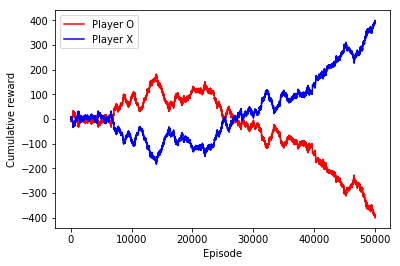

In [8]:
### Your code for Exercise 2a
import random
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

class Tictactoe():
    
    def __init__(self):
        self.players = {"O": 1, "X": 2}
        self.winners = np.array([
            [0, 1, 2], [3, 4, 5], [6, 7, 8],
            [0, 3, 6], [1, 4, 7], [2, 5, 8],
            [0, 4, 8], [2, 4, 6]
            ])
        self.board = self.create_board()

    def create_board(self):
        return np.zeros(9, dtype=int)

    def print_board(self):
        b = np.reshape(self.board, (3,3))
        print(b)

    def choose_move(self):
        valid_moves = []

        for i in range(9):
            if self.board[i] == 0:
                valid_moves.append(i)
        
        move = random.choice(valid_moves)
        return move

    def make_move(self, player, move):
        piece = self.players[player]
        #print(piece)
        self.board[move] = piece

    def check_win(self):
        for _, player in self.players.items():
            for row in self.winners:
                if all([self.board[cell] == player for cell in row]):
                    return player

        for i in range(9):
            if self.board[i] == 0:
                return None # No one has won yet

        # Otherwise, game is a draw
        return 0

    def play(self):
        #board = create_board()
        #print_board(board)
        p = list(self.players.items())
        random.shuffle(p)
        #print(p[0])
        for player, _ in itertools.cycle(p):
            move = self.choose_move()
            self.make_move(player, move)
            winner = self.check_win()
            if winner != None:
                #if winner == 0:
                    # Game is a draw
                    #print("Game is a draw")
                #elif winner == 1:
                    #print("Player O wins")
                #elif winner == 2:
                    #print("Player X wins")
                #print(winner)
                return winner
    



num_episodes = 50000

results_O = np.zeros(num_episodes)
results_X = np.zeros(num_episodes)

for episode in range(num_episodes):
    t = Tictactoe()
    result = t.play()
    #print(t.board)
    if result == 0:
        results_O[episode] = 0
        results_X[episode] = 0
    elif result == 1:
        results_O[episode] = 1
        results_X[episode] = -1
    elif result == 2:
        results_O[episode] = -1
        results_X[episode] = 1

#print(results_O)
#print(results_X)

cum_results_O = np.cumsum(results_O)
cum_results_X = np.cumsum(results_X)

#print(cum_results_O)
#print(cum_results_X)

plt.plot(cum_results_O, color="red", label="Player O")
plt.plot(cum_results_X, color="blue", label="Player X")
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.legend()
plt.show()

In a few sentences, discuss your results. Did you expect these results? Why or why not? (We will mark only the first three sentences. Please do not write any longer than that.) 

The cumulative returns of player O and X are equal and opposite, as expected for Tic-tac-toe which is a zero-sum game. Neither player has a clear advantage as the number of episodes increases because both players are random and who moves first is also random.



### Exercise 2b: Q-learning (20 marks)
Use Q-learning to learn an optimal policy for playing Tic-Tac-Toe against a random opponent. Produce a learning curve for your agent. That is, (1) plot average return as a function of episodes, (2) the learning curve should plot the average return of many agents (please specify how many agents you are averaging). 

For your reference, the pseudo-code for Q-learning is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 6.5).
<img src="images/q_learning.png" style="width: 600px;"/>
 

In [68]:
import numpy as np
import random

class Tictactoe_Q():
    
    def __init__(self):
        self.players = {"Q": 1, "R": 2}
        self.winners = np.array([
            [0, 1, 2], [3, 4, 5], [6, 7, 8],
            [0, 3, 6], [1, 4, 7], [2, 5, 8],
            [0, 4, 8], [2, 4, 6]
            ])
        self.board = self.create_board()
        self.done = 0

    def create_board(self):
        return np.zeros(9, dtype=int)

    def print_board(self):
        b = np.reshape(self.board, (3,3))
        print(b)

    def get_available_actions(self):
        valid_moves = []

        for i in range(9):
            if self.board[i] == 0:
                valid_moves.append(i)
        
        return valid_moves

    def make_move(self, player, move):
        piece = self.players[player]
        #print(piece)
        self.board[move] = piece
    
    def is_done(self):
        return self.done
    
    def get_reward(self, winner):
        if winner == 0:
            return 0
        elif winner == 1:
            return 1
        elif winner == 2:
            return -1

    def check_win(self): # check
        for _, player in self.players.items():
            for row in self.winners:
                if all([self.board[cell] == player for cell in row]):
                    self.done = 1
                    return player

        for i in range(9):
            if self.board[i] == 0:
                return None # No one has won yet

        # Otherwise, game is a draw
        self.done = 1
        return 0


[0 0 0 0 2 0 0 0 0] [1 0 0 0 2 0 0 0 2] 0 0 [1, 2, 3, 5, 6, 7]
[1 0 0 0 2 0 0 0 2] [1 0 0 1 2 0 2 0 2] 0 3 [1, 2, 5, 7]
[1 0 0 1 2 0 2 0 2] [1 0 1 1 2 0 2 2 2] -1 2 [1, 5]
[0 0 0 0 0 0 0 0 2] [0 2 1 0 0 0 0 0 2] 0 2 [0, 3, 4, 5, 6, 7]
[0 2 1 0 0 0 0 0 2] [2 2 1 0 0 0 0 1 2] 0 7 [3, 4, 5, 6]
[2 2 1 0 0 0 0 1 2] [2 2 1 0 2 1 0 1 2] -1 5 [3, 6]
[0 0 0 0 0 0 2 0 0] [0 0 2 0 1 0 2 0 0] 0 4 [0, 1, 3, 5, 7, 8]
[0 0 2 0 1 0 2 0 0] [0 0 2 1 1 0 2 0 2] 0 3 [0, 1, 5, 7]
[0 0 2 1 1 0 2 0 2] [2 1 2 1 1 0 2 0 2] 0 1 [5, 7]
[2 1 2 1 1 0 2 0 2] [2 1 2 1 1 0 2 1 2] 1 7 [5]
[0 0 0 0 0 0 0 0 0] [0 0 0 0 0 1 2 0 0] 0 5 [0, 1, 2, 3, 4, 7, 8]
[0 0 0 0 0 1 2 0 0] [0 0 0 1 2 1 2 0 0] 0 3 [0, 1, 2, 7, 8]
[0 0 0 1 2 1 2 0 0] [1 0 0 1 2 1 2 2 0] 0 0 [1, 2, 8]
[1 0 0 1 2 1 2 2 0] [1 1 0 1 2 1 2 2 2] -1 1 [2]
[0 0 0 0 0 0 0 0 0] [0 1 0 0 2 0 0 0 0] 0 1 [0, 2, 3, 5, 6, 7, 8]
[0 1 0 0 2 0 0 0 0] [0 1 1 0 2 2 0 0 0] 0 2 [0, 3, 6, 7, 8]
[0 1 1 0 2 2 0 0 0] [1 1 1 0 2 2 0 0 0] 1 0 [3, 6, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 2 

[2 1 1 2 2 1 1 2 0] [2 1 1 2 2 1 1 2 1] 1 8 []
[0 0 2 0 0 0 0 0 0] [1 0 2 0 0 0 0 2 0] 0 0 [1, 3, 4, 5, 6, 8]
[1 0 2 0 0 0 0 2 0] [1 0 2 0 2 0 1 2 0] 0 6 [1, 3, 5, 8]
[1 0 2 0 2 0 1 2 0] [1 0 2 2 2 0 1 2 1] 0 8 [1, 5]
[1 0 2 2 2 0 1 2 1] [1 2 2 2 2 1 1 2 1] -1 5 []
[0 0 0 0 0 0 2 0 0] [0 0 1 0 0 0 2 0 2] 0 2 [0, 1, 3, 4, 5, 7]
[0 0 1 0 0 0 2 0 2] [0 0 1 1 2 0 2 0 2] 0 3 [0, 1, 5, 7]
[0 0 1 1 2 0 2 0 2] [0 0 1 1 2 1 2 2 2] -1 5 [0, 1]
[0 0 2 0 0 0 0 0 0] [1 2 2 0 0 0 0 0 0] 0 0 [3, 4, 5, 6, 7, 8]
[1 2 2 0 0 0 0 0 0] [1 2 2 0 0 1 0 2 0] 0 5 [3, 4, 6, 8]
[1 2 2 0 0 1 0 2 0] [1 2 2 0 2 1 0 2 1] -1 8 [3, 6]
[0 0 0 2 0 0 0 0 0] [0 2 0 2 1 0 0 0 0] 0 4 [0, 2, 5, 6, 7, 8]
[0 2 0 2 1 0 0 0 0] [2 2 0 2 1 1 0 0 0] 0 5 [2, 6, 7, 8]
[2 2 0 2 1 1 0 0 0] [2 2 0 2 1 1 1 2 0] 0 6 [2, 8]
[2 2 0 2 1 1 1 2 0] [2 2 1 2 1 1 1 2 0] 1 2 [8]
[0 0 0 0 0 0 0 0 0] [0 0 0 2 0 0 1 0 0] 0 6 [0, 1, 2, 4, 5, 7, 8]
[0 0 0 2 0 0 1 0 0] [0 0 0 2 2 0 1 1 0] 0 7 [0, 1, 2, 5, 8]
[0 0 0 2 2 0 1 1 0] [0 1 0 2 2 2 1 1 0] -1 1 

[2 0 0 1 2 0 2 0 1] [2 1 0 1 2 0 2 2 1] 0 1 [2, 5]
[2 1 0 1 2 0 2 2 1] [2 1 1 1 2 2 2 2 1] 0 2 []
[0 0 0 0 0 0 0 0 0] [0 0 2 1 0 0 0 0 0] 0 3 [0, 1, 4, 5, 6, 7, 8]
[0 0 2 1 0 0 0 0 0] [1 0 2 1 0 0 2 0 0] 0 0 [1, 4, 5, 7, 8]
[1 0 2 1 0 0 2 0 0] [1 0 2 1 0 1 2 2 0] 0 5 [1, 4, 8]
[1 0 2 1 0 1 2 2 0] [1 0 2 1 2 1 2 2 1] -1 8 [1]
[0 0 0 0 0 0 0 0 0] [0 0 0 0 0 2 0 1 0] 0 7 [0, 1, 2, 3, 4, 6, 8]
[0 0 0 0 0 2 0 1 0] [0 1 0 0 0 2 0 1 2] 0 1 [0, 2, 3, 4, 6]
[0 1 0 0 0 2 0 1 2] [1 1 2 0 0 2 0 1 2] -1 0 [3, 4, 6]
[0 0 0 0 0 0 0 2 0] [0 1 0 0 2 0 0 2 0] 0 1 [0, 2, 3, 5, 6, 8]
[0 1 0 0 2 0 0 2 0] [0 1 0 0 2 2 0 2 1] 0 8 [0, 2, 3, 6]
[0 1 0 0 2 2 0 2 1] [0 1 2 1 2 2 0 2 1] 0 3 [0, 6]
[0 1 2 1 2 2 0 2 1] [2 1 2 1 2 2 1 2 1] 0 6 []
[0 0 0 0 0 0 0 0 0] [1 2 0 0 0 0 0 0 0] 0 0 [2, 3, 4, 5, 6, 7, 8]
[1 2 0 0 0 0 0 0 0] [1 2 0 1 0 0 0 2 0] 0 3 [2, 4, 5, 6, 8]
[1 2 0 1 0 0 0 2 0] [1 2 0 1 2 0 0 2 1] -1 8 [2, 5, 6]
[2 0 0 0 0 0 0 0 0] [2 1 0 0 0 2 0 0 0] 0 1 [2, 3, 4, 6, 7, 8]
[2 1 0 0 0 2 0 0 0] [2 1 0 0 1

[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 2 0 0 0] 0 0 [1, 3, 6, 7, 8]
[1 0 1 0 2 2 0 0 0] [1 0 1 1 2 2 0 2 0] 0 3 [1, 6, 8]
[1 0 1 1 2 2 0 2 0] [1 0 1 1 2 2 1 2 0] 1 6 [1, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [1 0 1 2 0 0 0 2 0] 0 0 [1, 4, 5, 6, 8]
[1 0 1 2 0 0 0 2 0] [1 2 1 2 0 0 1 2 0] 0 6 [4, 5, 8]
[1 2 1 2 0 0 1 2 0] [1 2 1 2 0 1 1 2 2] 0 5 [4]
[1 2 1 2 0 1 1 2 2] [1 2 1 2 1 1 1 2 2] 1 4 []
[0 0 0 0 0 0 0 0 2] [0 0 1 0 0 0 2 0 2] 0 2 [0, 1, 3, 4, 5, 7]
[0 0 1 0 0 0 2 0 2] [2 0 1 1 0 0 2 0 2] 0 3 [1, 4, 5, 7]
[2 0 1 1 0 0 2 0 2] [2 0 1 1 0 1 2 2 2] -1 5 [1, 4]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 2 0 0 2 0] 0 1 [0, 3, 5, 6, 8]
[0 1 1 0 2 0 0 2 0] [2 1 1 0 2 0 0 2 1] 0 8 [3, 5, 6]
[2 1 1 0 2 0 0 2 1] [2 1 1 1 2 0 2 2 1] 0 3 [5]
[2 1 1 1 2 0 2 2 1] [2 1 1 1 2 1 2 2 1] 1 5 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [2 0 1 0 0 0 0 1 2] 0 7 [1,

[0 1 0 2 0 0 2 0 0] [1 1 0 2 2 0 2 0 0] 0 0 [2, 5, 7, 8]
[1 1 0 2 2 0 2 0 0] [1 1 2 2 2 0 2 1 0] -1 7 [5, 8]
[0 2 0 0 0 0 0 0 0] [2 2 1 0 0 0 0 0 0] 0 2 [3, 4, 5, 6, 7, 8]
[2 2 1 0 0 0 0 0 0] [2 2 1 1 0 0 0 0 2] 0 3 [4, 5, 6, 7]
[2 2 1 1 0 0 0 0 2] [2 2 1 1 0 0 1 2 2] 0 6 [4, 5]
[2 2 1 1 0 0 1 2 2] [2 2 1 1 2 1 1 2 2] -1 5 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 2 1 1 0 0 2 0 0] 0 3 [0, 4, 5, 7, 8]
[0 2 1 1 0 0 2 0 0] [0 2 1 1 0 0 2 1 2] 0 7 [0, 4, 5]
[0 2 1 1 0 0 2 1 2] [1 2 1 1 0 2 2 1 2] 0 0 [4]
[1 2 1 1 0 2 2 1 2] [1 2 1 1 1 2 2 1 2] 0 4 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [2 0 1 0 0 0 1 2 0] 0 6 [1, 3, 4, 5, 8]
[2 0 1 0 0 0 1 2 0] [2 0 1 1 0 0 1 2 2] 0 3 [1, 4, 5]
[2 0 1 1 0 0 1 2 2] [2 0 1 1 2 1 1 2 2] -1 5 [1]
[0 0 0 0 2 0 0 0 0] [0 2 0 0 2 1 0 0 0] 0 5 [0, 2, 3, 6, 7, 8]
[0 2 0 0 2 1 0 0 0] [2 2 1 0 2 1 0 0 0] 0 2 [3, 6, 7, 8]
[2 2 1 0 2 1 0 0 0] [2 2 1 0 2 1 2 1 0] 0 7 [3, 

[1 0 1 1 2 2 2 1 2] [1 1 1 1 2 2 2 1 2] 1 1 []
[0 0 0 0 2 0 0 0 0] [0 0 2 0 2 0 0 0 1] 0 8 [0, 1, 3, 5, 6, 7]
[0 0 2 0 2 0 0 0 1] [2 0 2 0 2 0 1 0 1] 0 6 [1, 3, 5, 7]
[2 0 2 0 2 0 1 0 1] [2 1 2 0 2 2 1 0 1] 0 1 [3, 7]
[2 1 2 0 2 2 1 0 1] [2 1 2 0 2 2 1 1 1] 1 7 [3]
[0 2 0 0 0 0 0 0 0] [2 2 1 0 0 0 0 0 0] 0 2 [3, 4, 5, 6, 7, 8]
[2 2 1 0 0 0 0 0 0] [2 2 1 0 0 2 0 0 1] 0 8 [3, 4, 6, 7]
[2 2 1 0 0 2 0 0 1] [2 2 1 0 1 2 0 2 1] 0 4 [3, 6]
[2 2 1 0 1 2 0 2 1] [2 2 1 1 1 2 2 2 1] 0 3 []
[0 0 0 0 0 0 2 0 0] [0 0 0 0 2 1 2 0 0] 0 5 [0, 1, 2, 3, 7, 8]
[0 0 0 0 2 1 2 0 0] [2 0 0 0 2 1 2 1 0] 0 7 [1, 2, 3, 8]
[2 0 0 0 2 1 2 1 0] [2 2 1 0 2 1 2 1 0] 0 2 [3, 8]
[2 2 1 0 2 1 2 1 0] [2 2 1 0 2 1 2 1 1] 1 8 [3]
[0 0 0 2 0 0 0 0 0] [2 0 0 2 0 0 1 0 0] 0 6 [1, 2, 4, 5, 7, 8]
[2 0 0 2 0 0 1 0 0] [2 0 2 2 0 1 1 0 0] 0 5 [1, 4, 7, 8]
[2 0 2 2 0 1 1 0 0] [2 1 2 2 2 1 1 0 0] 0 1 [7, 8]
[2 1 2 2 2 1 1 0 0] [2 1 2 2 2 1 1 2 1] 0 8 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 

[0 0 1 0 0 2 0 0 0] [1 0 1 2 0 2 0 0 0] 0 0 [1, 4, 6, 7, 8]
[1 0 1 2 0 2 0 0 0] [1 0 1 2 2 2 0 1 0] -1 7 [1, 6, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 1 0 2 0 0 2] 0 3 [0, 1, 4, 6, 7]
[0 0 1 1 0 2 0 0 2] [0 0 1 1 2 2 0 1 2] 0 7 [0, 1, 6]
[0 0 1 1 2 2 0 1 2] [0 1 1 1 2 2 2 1 2] 0 1 [0]
[0 1 1 1 2 2 2 1 2] [1 1 1 1 2 2 2 1 2] 1 0 []
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 1 0 0 0 0 2] 0 3 [0, 4, 5, 6, 7]
[0 2 1 1 0 0 0 0 2] [2 2 1 1 0 0 0 1 2] 0 7 [4, 5, 6]
[2 2 1 1 0 0 0 1 2] [2 2 1 1 2 0 1 1 2] -1 6 [5]
[0 0 0 2 0 0 0 0 0] [2 0 0 2 0 1 0 0 0] 0 5 [1, 2, 4, 6, 7, 8]
[2 0 0 2 0 1 0 0 0] [2 1 2 2 0 1 0 0 0] 0 1 [4, 6, 7, 8]
[2 1 2 2 0 1 0 0 0] [2 1 2 2 2 1 0 1 0] 0 7 [6, 8]
[2 1 2 2 2 1 0 1 0] [2 1 2 2 2 1 2 1 1] -1 8 []
[0 0 0 0 0 0 0 0 2] [0 0 0 1 2 0 0 0 2] 0 3 [0, 1, 2, 5, 6, 7]
[0 0 0 1 2 0 0 0 2] [2 0 0 1 2 1 0 0 2] -1 5 [1, 2, 6, 7]
[0 2 0 0 0 0 0 0 0] [0 2 0 0 1 0 0 0 2] 0

[0 2 1 2 0 0 1 0 0] [0 2 1 2 1 0 1 0 0] 1 4 [0, 5, 7, 8]
[0 0 0 0 2 0 0 0 0] [2 0 0 1 2 0 0 0 0] 0 3 [1, 2, 5, 6, 7, 8]
[2 0 0 1 2 0 0 0 0] [2 0 0 1 2 0 0 1 2] -1 7 [1, 2, 5, 6]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [2 0 1 2 0 0 1 0 0] 0 6 [1, 4, 5, 7, 8]
[2 0 1 2 0 0 1 0 0] [2 0 1 2 1 0 1 0 0] 1 4 [1, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 0 0 0 1 0 2 0] 0 5 [0, 1, 2, 3, 4, 6, 8]
[0 0 0 0 0 1 0 2 0] [2 0 0 0 0 1 1 2 0] 0 6 [1, 2, 3, 4, 8]
[2 0 0 0 0 1 1 2 0] [2 0 1 0 0 1 1 2 2] 0 2 [1, 3, 4]
[2 0 1 0 0 1 1 2 2] [2 1 1 0 2 1 1 2 2] -1 1 [3]
[0 0 0 2 0 0 0 0 0] [1 2 0 2 0 0 0 0 0] 0 0 [2, 4, 5, 6, 7, 8]
[1 2 0 2 0 0 0 0 0] [1 2 0 2 0 0 0 2 1] 0 8 [2, 4, 5, 6]
[1 2 0 2 0 0 0 2 1] [1 2 2 2 0 1 0 2 1] 0 5 [4, 6]
[1 2 2 2 0 1 0 2 1] [1 2 2 2 2 1 1 2 1] -1 6 []
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 2 0 1 0 0] 0 6 [0, 3, 5, 7, 8]
[0 2 1 0 2 0 1 0 0] [0 2 1 0 2 0 1 2 1] -1 8 [0, 3, 5]
[0 0 0 0 0

[0 0 2 0 0 0 0 0 0] [0 0 2 0 0 1 0 2 0] 0 5 [0, 1, 3, 4, 6, 8]
[0 0 2 0 0 1 0 2 0] [0 0 2 1 2 1 0 2 0] 0 3 [0, 1, 6, 8]
[0 0 2 1 2 1 0 2 0] [2 0 2 1 2 1 0 2 1] 0 8 [1, 6]
[2 0 2 1 2 1 0 2 1] [2 2 2 1 2 1 1 2 1] -1 6 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 0 2 0 0] 0 0 [1, 3, 5, 7, 8]
[1 0 1 0 2 0 2 0 0] [1 1 1 0 2 0 2 0 0] 1 1 [3, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [2 0 1 0 1 2 0 0 0] 0 4 [1, 3, 6, 7, 8]
[2 0 1 0 1 2 0 0 0] [2 0 1 2 1 2 0 0 1] 0 8 [1, 6, 7]
[2 0 1 2 1 2 0 0 1] [2 2 1 2 1 2 0 1 1] 0 7 [6]
[2 2 1 2 1 2 0 1 1] [2 2 1 2 1 2 1 1 1] 1 6 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 0 1 2 0 0 2] 0 4 [0, 1, 3, 6, 7]
[0 0 1 0 1 2 0 0 2] [2 1 1 0 1 2 0 0 2] 0 1 [3, 6, 7]
[2 1 1 0 1 2 0 0 2] [2 1 1 0 1 2 1 0 2] 1 6 [3, 7]
[2 0 0 0 0 0 0 0 0] [2 2 0 0 1 0 0 0 0] 0 4 [2, 3, 5, 6, 7, 8]
[2 2 0 0 1 0 0 0 0] [2 2 0 0 

[0 1 2 2 1 1 0 2 2] [1 1 2 2 1 1 2 2 2] -1 0 []
[0 0 0 0 0 0 0 0 2] [2 0 0 1 0 0 0 0 2] 0 3 [1, 2, 4, 5, 6, 7]
[2 0 0 1 0 0 0 0 2] [2 0 2 1 0 0 1 0 2] 0 6 [1, 4, 5, 7]
[2 0 2 1 0 0 1 0 2] [2 0 2 1 2 1 1 0 2] -1 5 [1, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 0 0 2 0] 0 0 [1, 3, 5, 6, 8]
[1 0 1 0 2 0 0 2 0] [1 1 1 0 2 0 0 2 0] 1 1 [3, 5, 6, 8]
[0 0 0 0 0 0 0 2 0] [0 0 0 0 0 0 2 2 1] 0 8 [0, 1, 2, 3, 4, 5]
[0 0 0 0 0 0 2 2 1] [2 0 0 0 0 1 2 2 1] 0 5 [1, 2, 3, 4]
[2 0 0 0 0 1 2 2 1] [2 0 1 0 0 1 2 2 1] 1 2 [1, 3, 4]
[0 0 0 0 0 0 0 0 0] [0 1 0 2 0 0 0 0 0] 0 1 [0, 2, 4, 5, 6, 7, 8]
[0 1 0 2 0 0 0 0 0] [0 1 0 2 0 0 2 0 1] 0 8 [0, 2, 4, 5, 7]
[0 1 0 2 0 0 2 0 1] [2 1 0 2 1 0 2 0 1] -1 4 [2, 5, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 0 2 0 0] 0 0 [1, 3, 5, 7, 8]
[1 0 1 0 2 0 2 0 0] [1 1 1 0 2 0 2 0 0] 1 1 [3, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5,

[1 0 0 0 0 0 0 2 2] [1 0 0 0 1 0 2 2 2] -1 4 [1, 2, 3, 5]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 0 1 2 0] 0 6 [0, 3, 4, 5, 8]
[0 2 1 0 0 0 1 2 0] [0 2 1 0 1 0 1 2 0] 1 4 [0, 3, 5, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 0 1 0 2] 0 6 [0, 1, 4, 5, 7]
[0 0 1 2 0 0 1 0 2] [0 0 1 2 1 0 1 0 2] 1 4 [0, 1, 5, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [2 0 1 0 0 2 0 0 1] 0 8 [1, 3, 4, 6, 7]
[2 0 1 0 0 2 0 0 1] [2 0 1 2 0 2 1 0 1] 0 6 [1, 4, 7]
[2 0 1 2 0 2 1 0 1] [2 1 1 2 0 2 1 2 1] 0 1 [4]
[2 1 1 2 0 2 1 2 1] [2 1 1 2 1 2 1 2 1] 1 4 []
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 2 0 1 0 0] 0 6 [0, 3, 5, 7, 8]
[0 2 1 0 2 0 1 0 0] [0 2 1 2 2 0 1 1 0] 0 7 [0, 5, 8]
[0 2 1 2 2 0 1 1 0] [1 2 1 2 2 2 1 1 0] -1 0 [8]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1

[2 2 0 1 0 0 0 0 0] [2 2 2 1 0 0 0 0 1] -1 8 [4, 5, 6, 7]
[0 0 0 2 0 0 0 0 0] [2 0 1 2 0 0 0 0 0] 0 2 [1, 4, 5, 6, 7, 8]
[2 0 1 2 0 0 0 0 0] [2 0 1 2 1 0 0 0 2] 0 4 [1, 5, 6, 7]
[2 0 1 2 1 0 0 0 2] [2 0 1 2 1 0 1 0 2] 1 6 [1, 5, 7]
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 2 1 0 0 0 0] 0 4 [1, 5, 6, 7, 8]
[2 0 1 2 1 0 0 0 0] [2 1 1 2 1 0 2 0 0] -1 1 [5, 7, 8]
[0 0 0 2 0 0 0 0 0] [0 1 0 2 0 2 0 0 0] 0 1 [0, 2, 4, 6, 7, 8]
[0 1 0 2 0 2 0 0 0] [0 1 0 2 0 2 0 1 2] 0 7 [0, 2, 4, 6]
[0 1 0 2 0 2 0 1 2] [0 1 2 2 0 2 1 1 2] -1 6 [0, 4]
[0 0 0 0 0 0 0 0 0] [1 0 0 2 0 0 0 0 0] 0 0 [1, 2, 4, 5, 6, 7, 8]
[1 0 0 2 0 0 0 0 0] [1 1 0 2 0 0 0 0 2] 0 1 [2, 4, 5, 6, 7]
[1 1 0 2 0 0 0 0 2] [1 1 0 2 0 0 2 1 2] 0 7 [2, 4, 5]
[1 1 0 2 0 0 2 1 2] [1 1 1 2 0 0 2 1 2] 1 2 [4, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 2 0 1 0 0] 0 6 [0, 1, 5, 7, 8]
[0 0 1 2 2 0 1 0 0] [0 1 1 2 2 2 1 0 0] -1 1 [0, 7, 8]
[0 

[0 0 0 0 0 0 0 0 2] [0 0 2 1 0 0 0 0 2] 0 3 [0, 1, 4, 5, 6, 7]
[0 0 2 1 0 0 0 0 2] [0 0 2 1 0 2 1 0 2] -1 6 [0, 1, 4, 7]
[0 2 0 0 0 0 0 0 0] [1 2 0 0 2 0 0 0 0] 0 0 [2, 3, 5, 6, 7, 8]
[1 2 0 0 2 0 0 0 0] [1 2 0 0 2 1 0 0 2] 0 5 [2, 3, 6, 7]
[1 2 0 0 2 1 0 0 2] [1 2 0 0 2 1 1 2 2] -1 6 [2, 3]
[0 0 0 2 0 0 0 0 0] [0 0 0 2 1 0 2 0 0] 0 4 [0, 1, 2, 5, 7, 8]
[0 0 0 2 1 0 2 0 0] [2 0 0 2 1 0 2 0 1] -1 8 [1, 2, 5, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 0 1 2 0] 0 6 [0, 1, 4, 5, 8]
[0 0 1 2 0 0 1 2 0] [1 0 1 2 0 2 1 2 0] 0 0 [1, 4, 8]
[1 0 1 2 0 2 1 2 0] [1 1 1 2 0 2 1 2 0] 1 1 [4, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 2 1 0 1 0 0 0 2] 0 4 [0, 3, 5, 6, 7]
[0 2 1 0 1 0 0 0 2] [0 2 1 0 1 0 1 0 2] 1 6 [0, 3, 5, 7]
[0 0 0 0 0 2 0 0 0] [0 0 1 0 2 2 0 0 0] 0 2 [0, 1, 3, 6, 7, 8]
[0 0 1 0 2 2 0 0 0] [0 0 1 2 2 2 0 0 1] -1 8 [0, 1, 6, 7]
[0 2 0 0 0 0 0 0 0] [0 2 1 2 0 0 0 0 0] 0 2 [0, 4, 

[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 0 0 2 2] 0 1 [0, 3, 4, 5, 6]
[0 1 1 0 0 0 0 2 2] [1 1 1 0 0 0 0 2 2] 1 0 [3, 4, 5, 6]
[0 0 0 0 0 0 0 0 2] [0 0 0 1 0 2 0 0 2] 0 3 [0, 1, 2, 4, 6, 7]
[0 0 0 1 0 2 0 0 2] [2 0 0 1 0 2 1 0 2] 0 6 [1, 2, 4, 7]
[2 0 0 1 0 2 1 0 2] [2 0 0 1 2 2 1 1 2] -1 7 [1, 2]
[0 0 0 0 0 2 0 0 0] [0 1 0 2 0 2 0 0 0] 0 1 [0, 2, 4, 6, 7, 8]
[0 1 0 2 0 2 0 0 0] [0 1 0 2 2 2 0 0 1] -1 8 [0, 2, 6, 7]
[0 0 0 0 0 0 0 2 0] [0 1 0 0 0 0 2 2 0] 0 1 [0, 2, 3, 4, 5, 8]
[0 1 0 0 0 0 2 2 0] [0 1 2 0 0 0 2 2 1] 0 8 [0, 3, 4, 5]
[0 1 2 0 0 0 2 2 1] [1 1 2 0 2 0 2 2 1] -1 0 [3, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 0 0 1 2 2 0] 0 5 [0, 1, 3, 4, 8]
[0 0 1 0 0 1 2 2 0] [0 0 1 0 0 1 2 2 1] 1 8 [0, 1, 3, 4]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 0 2 2 0] 0 1 [0, 3, 4, 5, 8]
[0 1 1 0 0 0 2 2 0] [1 1 1 0 0 0 2 2 0] 1 0 [3, 4, 5, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3

[0 1 1 2 1 2 0 0 2] [0 1 1 2 1 2 1 0 2] 1 6 [0, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 2 1 0 1 2 0 0 0] 0 4 [0, 3, 6, 7, 8]
[0 2 1 0 1 2 0 0 0] [1 2 1 2 1 2 0 0 0] 0 0 [6, 7, 8]
[1 2 1 2 1 2 0 0 0] [1 2 1 2 1 2 0 1 2] 0 7 [6]
[1 2 1 2 1 2 0 1 2] [1 2 1 2 1 2 1 1 2] 1 6 []
[0 2 0 0 0 0 0 0 0] [0 2 0 0 0 2 0 0 1] 0 8 [0, 2, 3, 4, 6, 7]
[0 2 0 0 0 2 0 0 1] [0 2 1 0 0 2 0 2 1] 0 2 [0, 3, 4, 6]
[0 2 1 0 0 2 0 2 1] [2 2 1 1 0 2 0 2 1] 0 3 [4, 6]
[2 2 1 1 0 2 0 2 1] [2 2 1 1 2 2 1 2 1] -1 6 []
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [2 0 1 2 0 0 1 0 0] 0 6 [1, 4, 5, 7, 8]
[2 0 1 2 0 0 1 0 0] [2 2 1 2 0 1 1 0 0] 0 5 [4, 7, 8]
[2 2 1 2 0 1 1 0 0] [2 2 1 2 0 1 1 1 2] 0 7 [4]
[2 2 1 2 0 1 1 1 2] [2 2 1 2 1 1 1 1 2] 1 4 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 0 1 0 2 0 2] 0 4 [0, 1, 3, 5, 7]
[0 0 1 0 1 0 2 0 2] [0 1 1 0 1 2 2 0 2] 0 1 [0, 3, 7]


[0 0 2 0 0 2 0 0 1] [2 0 2 0 0 2 0 1 1] 0 7 [1, 3, 4, 6]
[2 0 2 0 0 2 0 1 1] [2 0 2 0 0 2 1 1 1] 1 6 [1, 3, 4]
[0 0 0 0 2 0 0 0 0] [0 0 0 0 2 0 0 2 1] 0 8 [0, 1, 2, 3, 5, 6]
[0 0 0 0 2 0 0 2 1] [0 2 1 0 2 0 0 2 1] -1 2 [0, 3, 5, 6]
[0 0 2 0 0 0 0 0 0] [0 2 2 0 0 0 0 0 1] 0 8 [0, 3, 4, 5, 6, 7]
[0 2 2 0 0 0 0 0 1] [0 2 2 0 2 0 1 0 1] 0 6 [0, 3, 5, 7]
[0 2 2 0 2 0 1 0 1] [0 2 2 1 2 2 1 0 1] 0 3 [0, 7]
[0 2 2 1 2 2 1 0 1] [1 2 2 1 2 2 1 0 1] 1 0 [7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 0 1 0 0 2 2] 0 4 [0, 1, 3, 5, 6]
[0 0 1 0 1 0 0 2 2] [0 0 1 0 1 0 1 2 2] 1 6 [0, 1, 3, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [1 0 1 2 0 0 0 0 2] 0 0 [1, 4, 5, 6, 7]
[1 0 1 2 0 0 0 0 2] [1 0 1 2 1 0 2 0 2] 0 4 [1, 5, 7]
[1 0 1 2 1 0 2 0 2] [1 1 1 2 1 0 2 0 2] 1 1 [5, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 0 2 0 0] 0 0 [1, 3, 5, 7, 8]
[1 0 1 0 

[1 0 2 0 0 0 0 0 2] [1 0 2 1 2 0 0 0 2] 0 3 [1, 5, 6, 7]
[1 0 2 1 2 0 0 0 2] [1 0 2 1 2 0 1 0 2] 1 6 [1, 5, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 0 1 2 0 2 0] 0 4 [0, 1, 3, 6, 8]
[0 0 1 0 1 2 0 2 0] [0 0 1 1 1 2 0 2 2] 0 3 [0, 1, 6]
[0 0 1 1 1 2 0 2 2] [0 0 1 1 1 2 1 2 2] 1 6 [0, 1]
[0 0 0 0 2 0 0 0 0] [0 0 0 2 2 0 0 1 0] 0 7 [0, 1, 2, 5, 6, 8]
[0 0 0 2 2 0 0 1 0] [0 2 0 2 2 1 0 1 0] 0 5 [0, 2, 6, 8]
[0 2 0 2 2 1 0 1 0] [0 2 0 2 2 1 2 1 1] 0 8 [0, 2]
[0 2 0 2 2 1 2 1 1] [0 2 1 2 2 1 2 1 1] 1 2 [0]
[0 0 0 0 2 0 0 0 0] [0 0 0 0 2 0 1 0 2] 0 6 [0, 1, 2, 3, 5, 7]
[0 0 0 0 2 0 1 0 2] [2 0 1 0 2 0 1 0 2] -1 2 [1, 3, 5, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 0 1 2 0 2 0] 0 4 [0, 1, 3, 6, 8]
[0 0 1 0 1 2 0 2 0] [2 0 1 1 1 2 0 2 0] 0 3 [1, 6, 8]
[2 0 1 1 1 2 0 2 0] [2 2 1 1 1 2 0 2 1] 0 8 [6]
[2 2 1 1 1 2 0 2 1] [2 2 1 1 1 2 1 2 1] 1 6 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2

[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 0 1 0 2] 0 6 [0, 1, 4, 5, 7]
[0 0 1 2 0 0 1 0 2] [0 0 1 2 1 0 1 0 2] 1 4 [0, 1, 5, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 0 1 0 0 2 2] 0 4 [0, 1, 3, 5, 6]
[0 0 1 0 1 0 0 2 2] [0 0 1 0 1 0 1 2 2] 1 6 [0, 1, 3, 5]
[0 0 0 2 0 0 0 0 0] [0 0 0 2 2 0 1 0 0] 0 6 [0, 1, 2, 5, 7, 8]
[0 0 0 2 2 0 1 0 0] [0 2 0 2 2 1 1 0 0] 0 5 [0, 2, 7, 8]
[0 2 0 2 2 1 1 0 0] [2 2 0 2 2 1 1 1 0] 0 7 [2, 8]
[2 2 0 2 2 1 1 1 0] [2 2 0 2 2 1 1 1 1] 1 8 [2]
[0 0 0 0 0 0 0 2 0] [0 0 0 0 0 0 1 2 2] 0 6 [0, 1, 2, 3, 4, 5]
[0 0 0 0 0 0 1 2 2] [0 0 2 1 0 0 1 2 2] 0 3 [0, 1, 4, 5]
[0 0 2 1 0 0 1 2 2] [1 0 2 1 0 0 1 2 2] 1 0 [1, 4, 5]
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 0 1 0 0 2 0] 0 4 [1, 3, 5, 6, 8]
[2 0 1 0 1 0 0 2 0] [2 0 1 2 1 1 0 2 0] 0 5 [1, 6, 8]
[2 0 1 2 1 1 0 2 0] [2 0 1 2 1 1 1 2 0] 1 6 [1, 8]
[0 0 0 2 0 0 0 0 0] [2 0 0 2 0 0 1 0 0] 0 6 [1, 2, 4, 5, 7, 8]
[2 0 0 2 0 0 

[0 2 1 0 0 2 1 2 0] [2 2 1 0 0 2 1 2 1] 0 8 [3, 4]
[2 2 1 0 0 2 1 2 1] [2 2 1 0 1 2 1 2 1] 1 4 [3]
[0 0 0 0 0 2 0 0 0] [0 0 0 0 2 2 0 1 0] 0 7 [0, 1, 2, 3, 6, 8]
[0 0 0 0 2 2 0 1 0] [0 0 1 2 2 2 0 1 0] -1 2 [0, 1, 6, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 2 1 0 0 1 2 0 0] 0 5 [0, 3, 4, 7, 8]
[0 2 1 0 0 1 2 0 0] [0 2 1 0 0 1 2 0 1] 1 8 [0, 3, 4, 7]
[0 0 0 0 0 0 0 2 0] [0 0 2 0 0 0 1 2 0] 0 6 [0, 1, 3, 4, 5, 8]
[0 0 2 0 0 0 1 2 0] [2 0 2 0 0 0 1 2 1] 0 8 [1, 3, 4, 5]
[2 0 2 0 0 0 1 2 1] [2 0 2 1 0 2 1 2 1] 0 3 [1, 4]
[2 0 2 1 0 2 1 2 1] [2 2 2 1 1 2 1 2 1] -1 4 []
[0 0 0 0 2 0 0 0 0] [1 0 0 0 2 0 0 2 0] 0 0 [1, 2, 3, 5, 6, 8]
[1 0 0 0 2 0 0 2 0] [1 0 2 0 2 0 1 2 0] 0 6 [1, 3, 5, 8]
[1 0 2 0 2 0 1 2 0] [1 2 2 0 2 0 1 2 1] -1 8 [3, 5]
[0 0 0 0 0 0 2 0 0] [0 0 0 0 2 0 2 0 1] 0 8 [0, 1, 2, 3, 5, 7]
[0 0 0 0 2 0 2 0 1] [0 2 1 0 2 0 2 0 1] 0 2 [0, 3, 5, 7]
[0 2 1 0 2 0 2 0 1] [1 2 1 2 2 0 2 0 1] 0 0 [5, 7]
[1 2 1 2 2 0 2 0 1] [1 2 1 2 2 2 2 

[0 0 1 2 0 1 2 0 0] [1 0 1 2 2 1 2 0 0] 0 0 [1, 7, 8]
[1 0 1 2 2 1 2 0 0] [1 0 1 2 2 1 2 0 1] 1 8 [1, 7]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 2 0 0 1 0 0] 0 6 [0, 4, 5, 7, 8]
[0 2 1 2 0 0 1 0 0] [1 2 1 2 0 0 1 2 0] 0 0 [4, 5, 8]
[1 2 1 2 0 0 1 2 0] [1 2 1 2 1 0 1 2 0] 1 4 [5, 8]
[0 0 0 0 0 0 0 2 0] [0 0 0 0 0 2 1 2 0] 0 6 [0, 1, 2, 3, 4, 8]
[0 0 0 0 0 2 1 2 0] [0 2 0 0 1 2 1 2 0] 0 4 [0, 2, 3, 8]
[0 2 0 0 1 2 1 2 0] [0 2 1 0 1 2 1 2 0] 1 2 [0, 3, 8]
[0 0 2 0 0 0 0 0 0] [0 0 2 0 2 0 0 0 1] 0 8 [0, 1, 3, 5, 6, 7]
[0 0 2 0 2 0 0 0 1] [0 1 2 2 2 0 0 0 1] 0 1 [0, 5, 6, 7]
[0 1 2 2 2 0 0 0 1] [2 1 2 2 2 0 1 0 1] 0 6 [5, 7]
[2 1 2 2 2 0 1 0 1] [2 1 2 2 2 1 1 2 1] 0 5 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 0 0 2 0] 0 0 [1, 3, 5, 6, 8]
[1 0 1 0 2 0 0 2 0] [1 1 1 0 2 0 0 2 0] 1 1 [3, 5, 6, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 

[0 0 0 0 0 0 2 0 0] [1 0 2 0 0 0 2 0 0] 0 0 [1, 3, 4, 5, 7, 8]
[1 0 2 0 0 0 2 0 0] [1 0 2 0 2 0 2 1 0] -1 7 [1, 3, 5, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [2 1 1 0 0 0 0 2 0] 0 1 [3, 4, 5, 6, 8]
[2 1 1 0 0 0 0 2 0] [2 1 1 0 2 1 0 2 0] 0 5 [3, 6, 8]
[2 1 1 0 2 1 0 2 0] [2 1 1 1 2 1 2 2 0] 0 3 [8]
[2 1 1 1 2 1 2 2 0] [2 1 1 1 2 1 2 2 1] 1 8 []
[0 2 0 0 0 0 0 0 0] [1 2 0 0 0 0 0 2 0] 0 0 [2, 3, 4, 5, 6, 8]
[1 2 0 0 0 0 0 2 0] [1 2 0 0 0 0 2 2 1] 0 8 [2, 3, 4, 5]
[1 2 0 0 0 0 2 2 1] [1 2 0 0 1 0 2 2 1] 1 4 [2, 3, 5]
[0 0 0 0 0 0 2 0 0] [1 0 0 0 0 2 2 0 0] 0 0 [1, 2, 3, 4, 7, 8]
[1 0 0 0 0 2 2 0 0] [1 0 2 0 0 2 2 0 1] 0 8 [1, 3, 4, 7]
[1 0 2 0 0 2 2 0 1] [1 0 2 0 1 2 2 0 1] 1 4 [1, 3, 7]
[0 0 0 0 2 0 0 0 0] [0 0 0 0 2 2 0 0 1] 0 8 [0, 1, 2, 3, 6, 7]
[0 0 0 0 2 2 0 0 1] [0 1 0 0 2 2 2 0 1] 0 1 [0, 2, 3, 7]
[0 1 0 0 2 2 2 0 1] [0 1 0 2 2 2 2 1 1] -1 7 [0, 2]
[0 0 0 0 0 0 0 0 0] [0 0 0 1 0 0 0 0 2] 0 3 [0, 1, 2, 4, 5, 6, 7]
[0 0 0 1 0 0 0 0 2

[1 0 1 2 2 1 2 0 2] [1 1 1 2 2 1 2 0 2] 1 1 [7]
[0 0 0 0 0 0 0 0 2] [1 0 0 2 0 0 0 0 2] 0 0 [1, 2, 4, 5, 6, 7]
[1 0 0 2 0 0 0 0 2] [1 0 2 2 1 0 0 0 2] 0 4 [1, 5, 6, 7]
[1 0 2 2 1 0 0 0 2] [1 0 2 2 1 1 2 0 2] 0 5 [1, 7]
[1 0 2 2 1 1 2 0 2] [1 1 2 2 1 1 2 2 2] -1 1 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 2 0 1 2 0 0] 0 5 [0, 1, 4, 7, 8]
[0 0 1 2 0 1 2 0 0] [1 0 1 2 0 1 2 0 2] 0 0 [1, 4, 7]
[1 0 1 2 0 1 2 0 2] [1 1 1 2 0 1 2 0 2] 1 1 [4, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 0 1 2 0] 0 6 [0, 1, 4, 5, 8]
[0 0 1 2 0 0 1 2 0] [1 0 1 2 2 0 1 2 0] 0 0 [1, 5, 8]
[1 0 1 2 2 0 1 2 0] [1 1 1 2 2 0 1 2 0] 1 1 [5, 8]
[0 0 0 0 0 0 0 0 2] [1 0 0 2 0 0 0 0 2] 0 0 [1, 2, 4, 5, 6, 7]
[1 0 0 2 0 0 0 0 2] [1 0 0 2 1 0 0 2 2] 0 4 [1, 2, 5, 6]
[1 0 0 2 1 0 0 2 2] [1 0 1 2 1 2 0 2 2] 0 2 [1, 6]
[1 0 1 2 1 2 0 2 2] [1 1 1 2 1 2 0 2 2] 1 1 [6]
[0 0 0 0 0 0 0 0 0] [0 0 0 0 1 0 0 2 0] 0 4 [0, 1, 2

[0 0 2 2 0 0 1 2 1] [2 0 2 2 0 1 1 2 1] 0 5 [1, 4]
[2 0 2 2 0 1 1 2 1] [2 1 2 2 2 1 1 2 1] 0 1 []
[0 0 0 0 0 0 0 0 2] [0 0 0 2 0 0 0 1 2] 0 7 [0, 1, 2, 4, 5, 6]
[0 0 0 2 0 0 0 1 2] [0 0 1 2 0 0 2 1 2] 0 2 [0, 1, 4, 5]
[0 0 1 2 0 0 2 1 2] [0 2 1 2 0 1 2 1 2] 0 5 [0, 4]
[0 2 1 2 0 1 2 1 2] [2 2 1 2 1 1 2 1 2] -1 4 []
[0 0 0 0 0 0 0 0 2] [1 0 2 0 0 0 0 0 2] 0 0 [1, 3, 4, 5, 6, 7]
[1 0 2 0 0 0 0 0 2] [1 2 2 1 0 0 0 0 2] 0 3 [4, 5, 6, 7]
[1 2 2 1 0 0 0 0 2] [1 2 2 1 2 1 0 0 2] 0 5 [6, 7]
[1 2 2 1 2 1 0 0 2] [1 2 2 1 2 1 2 1 2] -1 7 []
[2 0 0 0 0 0 0 0 0] [2 0 1 0 0 2 0 0 0] 0 2 [1, 3, 4, 6, 7, 8]
[2 0 1 0 0 2 0 0 0] [2 2 1 0 0 2 0 0 1] 0 8 [3, 4, 6, 7]
[2 2 1 0 0 2 0 0 1] [2 2 1 0 2 2 0 1 1] 0 7 [3, 6]
[2 2 1 0 2 2 0 1 1] [2 2 1 1 2 2 2 1 1] 0 3 []
[0 0 0 2 0 0 0 0 0] [0 2 0 2 0 0 1 0 0] 0 6 [0, 2, 4, 5, 7, 8]
[0 2 0 2 0 0 1 0 0] [2 2 1 2 0 0 1 0 0] 0 2 [4, 5, 7, 8]
[2 2 1 2 0 0 1 0 0] [2 2 1 2 1 0 1 0 0] 1 4 [5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1

[1 2 0 0 0 0 0 0 2] [1 2 0 0 1 0 0 2 2] 0 4 [2, 3, 5, 6]
[1 2 0 0 1 0 0 2 2] [1 2 0 0 1 2 1 2 2] 0 6 [2, 3]
[1 2 0 0 1 2 1 2 2] [1 2 0 1 1 2 1 2 2] 1 3 [2]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 2 0 0 0] 0 0 [1, 3, 6, 7, 8]
[1 0 1 0 2 2 0 0 0] [1 1 1 0 2 2 0 0 0] 1 1 [3, 6, 7, 8]
[0 0 0 0 2 0 0 0 0] [0 2 0 1 2 0 0 0 0] 0 3 [0, 2, 5, 6, 7, 8]
[0 2 0 1 2 0 0 0 0] [2 2 0 1 2 0 0 1 0] 0 7 [2, 5, 6, 8]
[2 2 0 1 2 0 0 1 0] [2 2 0 1 2 1 2 1 0] 0 5 [2, 8]
[2 2 0 1 2 1 2 1 0] [2 2 2 1 2 1 2 1 1] -1 8 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 2 2 0 0 0 0] 0 0 [1, 5, 6, 7, 8]
[1 0 1 2 2 0 0 0 0] [1 0 1 2 2 1 0 2 0] 0 5 [1, 6, 8]
[1 0 1 2 2 1 0 2 0] [1 1 1 2 2 1 0 2 0] 1 1 [6, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 2 0 0 2 0] 0 1 [0, 3, 5, 6, 8]
[0 1 1 0 2 0 0 2 0] [2 1 1 0 2 1 0 2 0] 0 5 [3, 6, 8]
[2 1 1 0 2 1 0 2 0] [2 1 1 0 2 

[0 0 1 2 0 0 1 0 2] [0 0 1 2 1 0 1 0 2] 1 4 [0, 1, 5, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 2 0 2 0] 0 1 [0, 3, 4, 6, 8]
[0 1 1 0 0 2 0 2 0] [1 1 1 0 0 2 0 2 0] 1 0 [3, 4, 6, 8]
[2 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 2 0 0] 0 2 [1, 3, 4, 5, 7, 8]
[2 0 1 0 0 0 2 0 0] [2 0 1 0 1 2 2 0 0] 0 4 [1, 3, 7, 8]
[2 0 1 0 1 2 2 0 0] [2 1 1 0 1 2 2 2 0] 0 1 [3, 8]
[2 1 1 0 1 2 2 2 0] [2 1 1 2 1 2 2 2 1] -1 8 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 0 1 0 0 2 2] 0 4 [0, 1, 3, 5, 6]
[0 0 1 0 1 0 0 2 2] [0 0 1 0 1 0 1 2 2] 1 6 [0, 1, 3, 5]
[0 0 0 0 0 2 0 0 0] [1 2 0 0 0 2 0 0 0] 0 0 [2, 3, 4, 6, 7, 8]
[1 2 0 0 0 2 0 0 0] [1 2 0 0 1 2 2 0 0] 0 4 [2, 3, 7, 8]
[1 2 0 0 1 2 2 0 0] [1 2 1 0 1 2 2 0 2] 0 2 [3, 7]
[1 2 1 0 1 2 2 0 2] [1 2 1 1 1 2 2 2 2] -1 3 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 0 2 1 2 0 0] 0 5 [0, 1, 3, 7, 8]
[0 0 1 0 2 1 

[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 0 1 2 0] 0 6 [0, 3, 4, 5, 8]
[0 2 1 0 0 0 1 2 0] [0 2 1 0 1 0 1 2 0] 1 4 [0, 3, 5, 8]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 0 1 0 2] 0 6 [0, 3, 4, 5, 7]
[0 2 1 0 0 0 1 0 2] [1 2 1 0 0 0 1 2 2] 0 0 [3, 4, 5]
[1 2 1 0 0 0 1 2 2] [1 2 1 0 2 1 1 2 2] -1 5 [3]
[0 2 0 0 0 0 0 0 0] [0 2 1 0 0 0 2 0 0] 0 2 [0, 3, 4, 5, 7, 8]
[0 2 1 0 0 0 2 0 0] [0 2 1 0 2 0 2 1 0] 0 7 [0, 3, 5, 8]
[0 2 1 0 2 0 2 1 0] [0 2 1 0 2 1 2 1 2] 0 5 [0, 3]
[0 2 1 0 2 1 2 1 2] [2 2 1 1 2 1 2 1 2] -1 3 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 2 1 0 0 1 2 0 0] 0 5 [0, 3, 4, 7, 8]
[0 2 1 0 0 1 2 0 0] [0 2 1 0 0 1 2 0 1] 1 8 [0, 3, 4, 7]
[2 0 0 0 0 0 0 0 0] [2 0 0 0 0 0 1 0 2] 0 6 [1, 2, 3, 4, 5, 7]
[2 0 0 0 0 0 1 0 2] [2 0 0 0 1 0 1 2 2] 0 4 [1, 2, 3, 5]
[2 0 0 0 1 0 1 2 2] [2 0 1 0 1 0 1 2 2] 1 2 [1, 3, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0

[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [2 0 1 0 0 1 2 0 0] 0 5 [1, 3, 4, 7, 8]
[2 0 1 0 0 1 2 0 0] [2 0 1 0 0 1 2 1 2] 0 7 [1, 3, 4]
[2 0 1 0 0 1 2 1 2] [2 0 1 2 1 1 2 1 2] -1 4 [1]
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 2 1 0 0 0 0] 0 4 [1, 5, 6, 7, 8]
[2 0 1 2 1 0 0 0 0] [2 0 1 2 1 0 1 0 0] 1 6 [1, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 0 2 1 2 0 0] 0 5 [0, 1, 3, 7, 8]
[0 0 1 0 2 1 2 0 0] [0 0 1 0 2 1 2 0 1] 1 8 [0, 1, 3, 7]
[0 0 0 2 0 0 0 0 0] [0 0 0 2 0 2 1 0 0] 0 6 [0, 1, 2, 4, 7, 8]
[0 0 0 2 0 2 1 0 0] [0 2 0 2 1 2 1 0 0] 0 4 [0, 2, 7, 8]
[0 2 0 2 1 2 1 0 0] [0 2 1 2 1 2 1 0 0] 1 2 [0, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 0 0 2 1 0 0 0] 0 5 [0, 1, 2, 3, 6, 7, 8]
[0 0 0 0 2 1 0 0 0] [1 2 0 0 2 1 0 0 0] 0 0 [2, 3, 6, 7, 8]
[1 2 0 0 2 1 0 0 0] [1 2 0 2 2 1 1 0 0] 0 6 [2, 7, 8]
[1 2 0 2 2 1 1 0 0] [1 2 1 2 2 1 1 0 2] 0 2 [7]
[1 

[2 0 0 0 2 0 1 0 0] [2 0 0 2 2 0 1 0 1] 0 8 [1, 2, 5, 7]
[2 0 0 2 2 0 1 0 1] [2 2 0 2 2 1 1 0 1] 0 5 [2, 7]
[2 2 0 2 2 1 1 0 1] [2 2 0 2 2 1 1 1 1] 1 7 [2]
[2 0 0 0 0 0 0 0 0] [2 0 2 0 0 0 1 0 0] 0 6 [1, 3, 4, 5, 7, 8]
[2 0 2 0 0 0 1 0 0] [2 0 2 2 0 0 1 1 0] 0 7 [1, 4, 5, 8]
[2 0 2 2 0 0 1 1 0] [2 0 2 2 0 0 1 1 1] 1 8 [1, 4, 5]
[0 0 0 0 0 0 0 0 2] [1 2 0 0 0 0 0 0 2] 0 0 [2, 3, 4, 5, 6, 7]
[1 2 0 0 0 0 0 0 2] [1 2 0 0 0 2 0 1 2] 0 7 [2, 3, 4, 6]
[1 2 0 0 0 2 0 1 2] [1 2 0 1 0 2 2 1 2] 0 3 [2, 4]
[1 2 0 1 0 2 2 1 2] [1 2 2 1 1 2 2 1 2] -1 4 []
[0 0 0 0 0 0 0 0 0] [2 0 0 1 0 0 0 0 0] 0 3 [1, 2, 4, 5, 6, 7, 8]
[2 0 0 1 0 0 0 0 0] [2 0 0 1 2 0 0 1 0] 0 7 [1, 2, 5, 6, 8]
[2 0 0 1 2 0 0 1 0] [2 2 0 1 2 1 0 1 0] 0 5 [2, 6, 8]
[2 2 0 1 2 1 0 1 0] [2 2 2 1 2 1 1 1 0] -1 6 [8]
[0 0 0 0 2 0 0 0 0] [0 0 0 1 2 2 0 0 0] 0 3 [0, 1, 2, 6, 7, 8]
[0 0 0 1 2 2 0 0 0] [0 2 1 1 2 2 0 0 0] 0 2 [0, 6, 7, 8]
[0 2 1 1 2 2 0 0 0] [0 2 1 1 2 2 0 2 1] -1 8 [0, 6]
[2 0 0 0 0 0 0 0 0] [2 0 0 2 0 0 1 0 0] 0 6 [1, 2,

[1 0 0 0 2 2 0 0 0] [1 2 0 0 2 2 1 0 0] 0 6 [2, 3, 7, 8]
[1 2 0 0 2 2 1 0 0] [1 2 0 0 2 2 1 2 1] -1 8 [2, 3]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 2 1 2 0 0 0] 0 4 [0, 1, 6, 7, 8]
[0 0 1 2 1 2 0 0 0] [0 0 1 2 1 2 0 1 2] 0 7 [0, 1, 6]
[0 0 1 2 1 2 0 1 2] [1 2 1 2 1 2 0 1 2] 0 0 [6]
[1 2 1 2 1 2 0 1 2] [1 2 1 2 1 2 1 1 2] 1 6 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [1 0 1 0 0 0 2 2 0] 0 0 [1, 3, 4, 5, 8]
[1 0 1 0 0 0 2 2 0] [1 1 1 0 0 0 2 2 0] 1 1 [3, 4, 5, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 0 1 0 2] 0 6 [0, 1, 4, 5, 7]
[0 0 1 2 0 0 1 0 2] [0 0 1 2 1 0 1 0 2] 1 4 [0, 1, 5, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [2 0 1 0 1 0 0 0 2] 0 4 [1, 3, 5, 6, 7]
[2 0 1 0 1 0 0 0 2] [2 1 1 0 1 2 0 0 2] 0 1 [3, 6, 7]
[2 1 1 0 1 2 0 0 2] [2 1 1 0 1 2 1 0 2] 1 6 [3, 7]
[0 0 0 0 0 0 0 0 0]

[2 0 1 2 0 0 1 0 0] [2 0 1 2 1 0 1 0 0] 1 4 [1, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 2 0 2 0] 0 1 [0, 3, 4, 6, 8]
[0 1 1 0 0 2 0 2 0] [1 1 1 0 0 2 0 2 0] 1 0 [3, 4, 6, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 0 0 1 2 2 0] 0 5 [0, 1, 3, 4, 8]
[0 0 1 0 0 1 2 2 0] [0 0 1 0 0 1 2 2 1] 1 8 [0, 1, 3, 4]
[0 2 0 0 0 0 0 0 0] [0 2 0 2 0 0 1 0 0] 0 6 [0, 2, 4, 5, 7, 8]
[0 2 0 2 0 0 1 0 0] [0 2 0 2 1 2 1 0 0] 0 4 [0, 2, 7, 8]
[0 2 0 2 1 2 1 0 0] [0 2 1 2 1 2 1 0 0] 1 2 [0, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 2 1 2 0 0 0] 0 4 [0, 1, 6, 7, 8]
[0 0 1 2 1 2 0 0 0] [0 0 1 2 1 2 2 1 0] 0 7 [0, 1, 8]
[0 0 1 2 1 2 2 1 0] [0 1 1 2 1 2 2 1 0] 1 1 [0, 8]
[0 0 0 0 2 0 0 0 0] [0 0 2 1 2 0 0 0 0] 0 3 [0, 1, 5, 6, 7, 8]
[0 0 2 1 2 0 0 0 0] [1 0 2 1 2 0 0 0 2] 0 0 [1, 5, 6, 7]
[1 0 2 1 2 0 0 0 2] [1 0 2 1 2 0 1 0 2] 1 6 [1, 5, 7

[2 0 1 0 0 0 0 0 0] [2 0 1 2 1 0 0 0 0] 0 4 [1, 5, 6, 7, 8]
[2 0 1 2 1 0 0 0 0] [2 0 1 2 1 0 1 0 0] 1 6 [1, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 0 1 2 0 0 0] 0 4 [1, 3, 6, 7, 8]
[2 0 1 0 1 2 0 0 0] [2 0 1 0 1 2 1 0 0] 1 6 [1, 3, 7, 8]
[0 0 0 0 0 0 0 2 0] [0 0 0 2 0 0 1 2 0] 0 6 [0, 1, 2, 4, 5, 8]
[0 0 0 2 0 0 1 2 0] [0 0 2 2 1 0 1 2 0] 0 4 [0, 1, 5, 8]
[0 0 2 2 1 0 1 2 0] [2 1 2 2 1 0 1 2 0] 0 1 [5, 8]
[2 1 2 2 1 0 1 2 0] [2 1 2 2 1 2 1 2 1] 0 8 []
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 0 1 0 0 0 2] 0 4 [1, 3, 5, 6, 7]
[2 0 1 0 1 0 0 0 2] [2 1 1 0 1 0 0 2 2] 0 1 [3, 5, 6]
[2 1 1 0 1 0 0 2 2] [2 1 1 0 1 0 1 2 2] 1 6 [3, 5]
[0 0 0 0 2 0 0 0 0] [2 0 0 1 2 0 0 0 0] 0 3 [1, 2, 5, 6, 7, 8]
[2 0 0 1 2 0 0 0 0] [2 0 0 1 2 0 2 0 1] 0 8 [1, 2, 5, 7]
[2 0 0 1 2 0 2 0 1] [2 1 0 1 2 2 2 0 1] 0 1 [2, 7]
[2 1 0 1 2 2 2 0 1] [2 1 1 1 2 2 2 2 1] 0 2 []
[2 0 0 0 0 0 0 0 0] [2 2 0 0 0 0 

[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 2 1 2 0 0 1 0 0] 0 6 [0, 4, 5, 7, 8]
[0 2 1 2 0 0 1 0 0] [0 2 1 2 1 0 1 0 0] 1 4 [0, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 0 1 2 0 0 2] 0 4 [0, 1, 3, 6, 7]
[0 0 1 0 1 2 0 0 2] [0 1 1 0 1 2 0 2 2] 0 1 [0, 3, 6]
[0 1 1 0 1 2 0 2 2] [0 1 1 0 1 2 1 2 2] 1 6 [0, 3]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 2 1 0 0 0 2] 0 4 [0, 1, 5, 6, 7]
[0 0 1 2 1 0 0 0 2] [0 0 1 2 1 0 1 0 2] 1 6 [0, 1, 5, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 2 0 1 2 0 0] 0 5 [0, 1, 4, 7, 8]
[0 0 1 2 0 1 2 0 0] [1 2 1 2 0 1 2 0 0] 0 0 [4, 7, 8]
[1 2 1 2 0 1 2 0 0] [1 2 1 2 1 1 2 2 0] 0 4 [8]
[1 2 1 2 1 1 2 2 0] [1 2 1 2 1 1 2 2 1] 1 8 []
[0 0 0 0 0 0 0 2 0] [0 0 0 2 0 0 1 2 0] 0 6 [0, 1, 2, 4, 5, 8]
[0 0 0 2 0 0 1 2 0] [0 0 2 2 1 0 1 2 0] 0 4 [0, 1, 5, 8]
[0 0 2 2

[0 0 1 2 1 2 0 0 0] [0 0 1 2 1 2 2 1 0] 0 7 [0, 1, 8]
[0 0 1 2 1 2 2 1 0] [0 1 1 2 1 2 2 1 0] 1 1 [0, 8]
[0 0 0 0 0 0 0 0 0] [0 0 0 0 2 0 1 0 0] 0 6 [0, 1, 2, 3, 5, 7, 8]
[0 0 0 0 2 0 1 0 0] [0 0 0 2 2 0 1 0 1] 0 8 [0, 1, 2, 5, 7]
[0 0 0 2 2 0 1 0 1] [0 0 0 2 2 1 1 2 1] 0 5 [0, 1, 2]
[0 0 0 2 2 1 1 2 1] [0 0 1 2 2 1 1 2 1] 1 2 [0, 1]
[0 0 2 0 0 0 0 0 0] [0 0 2 0 2 0 0 0 1] 0 8 [0, 1, 3, 5, 6, 7]
[0 0 2 0 2 0 0 0 1] [0 2 2 0 2 0 0 1 1] 0 7 [0, 3, 5, 6]
[0 2 2 0 2 0 0 1 1] [0 2 2 0 2 0 1 1 1] 1 6 [0, 3, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 0 0 2 2] 0 1 [0, 3, 4, 5, 6]
[0 1 1 0 0 0 0 2 2] [1 1 1 0 0 0 0 2 2] 1 0 [3, 4, 5, 6]
[2 0 0 0 0 0 0 0 0] [2 0 0 0 2 0 1 0 0] 0 6 [1, 2, 3, 5, 7, 8]
[2 0 0 0 2 0 1 0 0] [2 0 0 0 2 0 1 2 1] 0 8 [1, 2, 3, 5]
[2 0 0 0 2 0 1 2 1] [2 0 1 0 2 2 1 2 1] 0 2 [1, 3]
[2 0 1 0 2 2 1 2 1] [2 1 1 2 2 2 1 2 1] -1 1 []
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2

[2 2 1 0 0 0 1 0 0] [2 2 1 0 1 0 1 0 0] 1 4 [3, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 0 2 1 2 0 0] 0 5 [0, 1, 3, 7, 8]
[0 0 1 0 2 1 2 0 0] [0 0 1 0 2 1 2 0 1] 1 8 [0, 1, 3, 7]
[2 0 0 0 0 0 0 0 0] [2 0 0 0 0 2 1 0 0] 0 6 [1, 2, 3, 4, 7, 8]
[2 0 0 0 0 2 1 0 0] [2 0 0 0 2 2 1 0 1] 0 8 [1, 2, 3, 7]
[2 0 0 0 2 2 1 0 1] [2 2 1 0 2 2 1 0 1] 0 2 [3, 7]
[2 2 1 0 2 2 1 0 1] [2 2 1 0 2 2 1 1 1] 1 7 [3]
[0 0 0 0 0 2 0 0 0] [1 0 0 2 0 2 0 0 0] 0 0 [1, 2, 4, 6, 7, 8]
[1 0 0 2 0 2 0 0 0] [1 0 2 2 1 2 0 0 0] 0 4 [1, 6, 7, 8]
[1 0 2 2 1 2 0 0 0] [1 0 2 2 1 2 0 0 1] 1 8 [1, 6, 7]
[0 0 0 0 2 0 0 0 0] [0 0 0 1 2 0 0 2 0] 0 3 [0, 1, 2, 5, 6, 8]
[0 0 0 1 2 0 0 2 0] [1 0 0 1 2 2 0 2 0] 0 0 [1, 2, 6, 8]
[1 0 0 1 2 2 0 2 0] [1 0 1 1 2 2 0 2 2] 0 2 [1, 6]
[1 0 1 1 2 2 0 2 2] [1 0 1 1 2 2 1 2 2] 1 6 [1]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 2 0 0 0] 0 0 [1, 3, 6, 7, 8]
[1 0 1 0 2 2 0 0 0] [1

[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 2 0 0 2 0] 0 1 [0, 3, 5, 6, 8]
[0 1 1 0 2 0 0 2 0] [1 1 1 0 2 0 0 2 0] 1 0 [3, 5, 6, 8]
[0 0 0 0 0 0 0 0 2] [2 0 0 0 0 0 1 0 2] 0 6 [1, 2, 3, 4, 5, 7]
[2 0 0 0 0 0 1 0 2] [2 0 0 0 1 0 1 2 2] 0 4 [1, 2, 3, 5]
[2 0 0 0 1 0 1 2 2] [2 0 1 0 1 0 1 2 2] 1 2 [1, 3, 5]
[0 0 0 0 2 0 0 0 0] [0 0 0 1 2 2 0 0 0] 0 3 [0, 1, 2, 6, 7, 8]
[0 0 0 1 2 2 0 0 0] [1 0 2 1 2 2 0 0 0] 0 0 [1, 6, 7, 8]
[1 0 2 1 2 2 0 0 0] [1 0 2 1 2 2 1 0 0] 1 6 [1, 7, 8]
[0 0 0 0 0 0 0 2 0] [0 0 0 0 0 0 1 2 2] 0 6 [0, 1, 2, 3, 4, 5]
[0 0 0 0 0 0 1 2 2] [0 0 2 0 1 0 1 2 2] 0 4 [0, 1, 3, 5]
[0 0 2 0 1 0 1 2 2] [1 0 2 0 1 2 1 2 2] -1 0 [1, 3]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 2 1 0 0] 0 6 [0, 1, 4, 7, 8]
[0 0 1 2 0 2 1 0 0] [0 0 1 2 1 2 1 0 0] 1 4 [0, 1, 7, 8]
[0 0 0 2 0 0 0 0 0] [0 0 2 2 1 0 0 0 0] 0 4 [0, 1, 5, 6, 7, 8]
[0 0 2 2 1 0 0 0 0] [2 0 2 2 1 1 0 0 0] 0 5 [1, 6, 

[0 0 1 0 2 0 0 0 0] [1 0 1 2 2 0 0 0 0] 0 0 [1, 5, 6, 7, 8]
[1 0 1 2 2 0 0 0 0] [1 2 1 2 2 1 0 0 0] 0 5 [6, 7, 8]
[1 2 1 2 2 1 0 0 0] [1 2 1 2 2 1 0 0 1] 1 8 [6, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 0 1 0 0 2 2] 0 4 [0, 1, 3, 5, 6]
[0 0 1 0 1 0 0 2 2] [1 0 1 2 1 0 0 2 2] 0 0 [1, 5, 6]
[1 0 1 2 1 0 0 2 2] [1 0 1 2 1 0 1 2 2] 1 6 [1, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [2 0 1 0 1 0 0 0 2] 0 4 [1, 3, 5, 6, 7]
[2 0 1 0 1 0 0 0 2] [2 1 1 2 1 0 0 0 2] 0 1 [5, 6, 7]
[2 1 1 2 1 0 0 0 2] [2 1 1 2 1 0 1 0 2] 1 6 [5, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [2 0 1 2 0 0 1 0 0] 0 6 [1, 4, 5, 7, 8]
[2 0 1 2 0 0 1 0 0] [2 0 1 2 1 0 1 0 0] 1 4 [1, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 2 0 0 0] 0 0 [1, 3, 6, 7, 8]
[1 0 1 0 2 2 0 0 0] [1 1 1 0 2 2 0 0 0] 1 1 [3, 6, 7, 8]
[0 0 0 

[0 0 1 0 1 0 2 0 2] [0 0 1 2 1 0 2 1 2] 0 7 [0, 1, 5]
[0 0 1 2 1 0 2 1 2] [1 0 1 2 1 2 2 1 2] 0 0 [1]
[1 0 1 2 1 2 2 1 2] [1 1 1 2 1 2 2 1 2] 1 1 []
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 1 1 0 0 0 0 2 0] 0 1 [3, 4, 5, 6, 8]
[2 1 1 0 0 0 0 2 0] [2 1 1 2 0 1 0 2 0] 0 5 [4, 6, 8]
[2 1 1 2 0 1 0 2 0] [2 1 1 2 2 1 1 2 0] 0 6 [8]
[2 1 1 2 2 1 1 2 0] [2 1 1 2 2 1 1 2 1] 1 8 []
[0 0 0 0 0 0 0 0 2] [0 2 0 0 0 0 1 0 2] 0 6 [0, 2, 3, 4, 5, 7]
[0 2 0 0 0 0 1 0 2] [0 2 0 1 2 0 1 0 2] 0 3 [0, 2, 5, 7]
[0 2 0 1 2 0 1 0 2] [1 2 0 1 2 0 1 0 2] 1 0 [2, 5, 7]
[0 0 0 0 0 0 0 0 2] [0 0 0 0 2 0 1 0 2] 0 6 [0, 1, 2, 3, 5, 7]
[0 0 0 0 2 0 1 0 2] [0 0 2 0 2 1 1 0 2] 0 5 [0, 1, 3, 7]
[0 0 2 0 2 1 1 0 2] [2 1 2 0 2 1 1 0 2] -1 1 [3, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 2 2 0 0 0 0] 0 0 [1, 5, 6, 7, 8]
[1 0 1 2 2 0 0 0 0] [1 0 1 2 2 1 2 0 0] 0 5 [1, 7, 8]
[1 0 1 2 2 1 2 0 0] [1 0 1 2 2 1 2 0 1] 1 8 [1, 7]

[0 0 0 2 0 0 0 0 0] [0 0 0 2 0 1 2 0 0] 0 5 [0, 1, 2, 4, 7, 8]
[0 0 0 2 0 1 2 0 0] [0 1 0 2 0 1 2 2 0] 0 1 [0, 2, 4, 8]
[0 1 0 2 0 1 2 2 0] [0 1 2 2 0 1 2 2 1] 0 8 [0, 4]
[0 1 2 2 0 1 2 2 1] [2 1 2 2 1 1 2 2 1] -1 4 []
[0 0 0 0 2 0 0 0 0] [0 2 0 1 2 0 0 0 0] 0 3 [0, 2, 5, 6, 7, 8]
[0 2 0 1 2 0 0 0 0] [2 2 0 1 2 0 0 0 1] 0 8 [2, 5, 6, 7]
[2 2 0 1 2 0 0 0 1] [2 2 1 1 2 2 0 0 1] 0 2 [6, 7]
[2 2 1 1 2 2 0 0 1] [2 2 1 1 2 2 2 1 1] 0 7 []
[0 0 0 0 0 2 0 0 0] [1 0 0 0 0 2 0 2 0] 0 0 [1, 2, 3, 4, 6, 8]
[1 0 0 0 0 2 0 2 0] [1 0 0 0 2 2 1 2 0] 0 6 [1, 2, 3, 8]
[1 0 0 0 2 2 1 2 0] [1 1 0 2 2 2 1 2 0] -1 1 [2, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 2 0 0 0] 0 0 [1, 3, 6, 7, 8]
[1 0 1 0 2 2 0 0 0] [1 0 1 1 2 2 0 0 2] 0 3 [1, 6, 7]
[1 0 1 1 2 2 0 0 2] [1 2 1 1 2 2 0 1 2] 0 7 [6]
[1 2 1 1 2 2 0 1 2] [1 2 1 1 2 2 1 1 2] 1 6 []
[0 0 0 0 0 0 0 0 0] [0 0 0 2 0 0 1 0 0] 0 6 [0, 1, 2, 4, 5, 7, 8]
[0 0 0 2 0 0 1 0 0] [0 0 2 2 0 0 1 0 1] 0 8 [0, 1,

[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 0 1 0 2] 0 6 [0, 1, 4, 5, 7]
[0 0 1 2 0 0 1 0 2] [0 0 1 2 2 1 1 0 2] 0 5 [0, 1, 7]
[0 0 1 2 2 1 1 0 2] [0 2 1 2 2 1 1 1 2] 0 7 [0]
[0 2 1 2 2 1 1 1 2] [1 2 1 2 2 1 1 1 2] 0 0 []
[0 2 0 0 0 0 0 0 0] [2 2 0 0 0 0 1 0 0] 0 6 [2, 3, 4, 5, 7, 8]
[2 2 0 0 0 0 1 0 0] [2 2 0 2 0 1 1 0 0] 0 5 [2, 4, 7, 8]
[2 2 0 2 0 1 1 0 0] [2 2 0 2 0 1 1 2 1] 0 8 [2, 4]
[2 2 0 2 0 1 1 2 1] [2 2 1 2 0 1 1 2 1] 1 2 [4]
[0 0 0 0 0 2 0 0 0] [1 0 0 2 0 2 0 0 0] 0 0 [1, 2, 4, 6, 7, 8]
[1 0 0 2 0 2 0 0 0] [1 0 2 2 0 2 1 0 0] 0 6 [1, 4, 7, 8]
[1 0 2 2 0 2 1 0 0] [1 0 2 2 2 2 1 1 0] -1 7 [1, 8]
[2 0 0 0 0 0 0 0 0] [2 0 0 2 0 0 1 0 0] 0 6 [1, 2, 4, 5, 7, 8]
[2 0 0 2 0 0 1 0 0] [2 0 2 2 0 0 1 1 0] 0 7 [1, 4, 5, 8]
[2 0 2 2 0 0 1 1 0] [2 0 2 2 0 0 1 1 1] 1 8 [1, 4, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [1 2 1 0 0 0 0 0 2] 0 0 [3, 4, 5, 6, 7]
[1 2 1 0 0 0 0 0 2] [1 2 1 0 2 1 0

[2 0 1 0 0 0 0 0 0] [2 0 1 1 0 0 0 2 0] 0 3 [1, 4, 5, 6, 8]
[2 0 1 1 0 0 0 2 0] [2 0 1 1 1 2 0 2 0] 0 4 [1, 6, 8]
[2 0 1 1 1 2 0 2 0] [2 1 1 1 1 2 0 2 2] 0 1 [6]
[2 1 1 1 1 2 0 2 2] [2 1 1 1 1 2 1 2 2] 1 6 []
[0 0 0 0 0 0 0 2 0] [0 0 0 0 2 0 1 2 0] 0 6 [0, 1, 2, 3, 5, 8]
[0 0 0 0 2 0 1 2 0] [0 1 0 2 2 0 1 2 0] 0 1 [0, 2, 5, 8]
[0 1 0 2 2 0 1 2 0] [2 1 0 2 2 1 1 2 0] 0 5 [2, 8]
[2 1 0 2 2 1 1 2 0] [2 1 2 2 2 1 1 2 1] 0 8 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 0 1 2 0 0 2] 0 4 [0, 1, 3, 6, 7]
[0 0 1 0 1 2 0 0 2] [0 1 1 2 1 2 0 0 2] 0 1 [0, 6, 7]
[0 1 1 2 1 2 0 0 2] [0 1 1 2 1 2 0 1 2] 1 7 [0, 6]
[0 0 0 0 0 0 2 0 0] [0 0 0 0 0 2 2 0 1] 0 8 [0, 1, 2, 3, 4, 7]
[0 0 0 0 0 2 2 0 1] [0 1 2 0 0 2 2 0 1] 0 1 [0, 3, 4, 7]
[0 1 2 0 0 2 2 0 1] [0 1 2 0 2 2 2 1 1] -1 7 [0, 3]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 0 1 2 0 0 2] 0 4 [0, 1, 3, 6, 7]
[0 0 1 0 1 2 0 0 2] [0 1 1 2 1 2 0 0 2] 0 1 

[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 2 0 0 0] 0 0 [1, 3, 6, 7, 8]
[1 0 1 0 2 2 0 0 0] [1 1 1 0 2 2 0 0 0] 1 1 [3, 6, 7, 8]
[0 2 0 0 0 0 0 0 0] [0 2 0 1 2 0 0 0 0] 0 3 [0, 2, 5, 6, 7, 8]
[0 2 0 1 2 0 0 0 0] [1 2 0 1 2 0 0 2 0] -1 0 [2, 5, 6, 8]
[0 0 0 0 0 2 0 0 0] [1 0 2 0 0 2 0 0 0] 0 0 [1, 3, 4, 6, 7, 8]
[1 0 2 0 0 2 0 0 0] [1 0 2 1 2 2 0 0 0] 0 3 [1, 6, 7, 8]
[1 0 2 1 2 2 0 0 0] [1 0 2 1 2 2 1 0 0] 1 6 [1, 7, 8]
[0 0 0 2 0 0 0 0 0] [0 0 2 2 0 0 1 0 0] 0 6 [0, 1, 4, 5, 7, 8]
[0 0 2 2 0 0 1 0 0] [0 2 2 2 0 0 1 1 0] 0 7 [0, 4, 5, 8]
[0 2 2 2 0 0 1 1 0] [0 2 2 2 1 0 1 1 2] 0 4 [0, 5]
[0 2 2 2 1 0 1 1 2] [1 2 2 2 1 2 1 1 2] -1 0 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 2 0 0 0] 0 0 [1, 3, 6, 7, 8]
[1 0 1 0 2 2 0 0 0] [1 1 1 0 2 2 0 0 0] 1 1 [3, 6, 7, 8]
[0 0 2 0 0 0 0 0 0] [0 0 2 0 2 0 0 0 1] 0 8 [0, 1, 3, 5, 6, 7]
[0 0 2 0 2 0 0 0 1] [1 0 2 0 2 0 2 0 1] -1 0 [1, 3, 5, 7]

[0 0 2 0 0 0 2 0 1] [2 0 2 0 1 0 2 0 1] 0 4 [1, 3, 5, 7]
[2 0 2 0 1 0 2 0 1] [2 1 2 0 1 0 2 2 1] 0 1 [3, 5]
[2 1 2 0 1 0 2 2 1] [2 1 2 1 1 2 2 2 1] 0 3 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 0 0 0 2] 0 0 [1, 3, 5, 6, 7]
[1 0 1 0 2 0 0 0 2] [1 1 1 0 2 0 0 0 2] 1 1 [3, 5, 6, 7]
[0 0 0 0 0 0 0 0 0] [0 0 0 1 0 0 0 2 0] 0 3 [0, 1, 2, 4, 5, 6, 8]
[0 0 0 1 0 0 0 2 0] [0 0 1 1 2 0 0 2 0] 0 2 [0, 1, 5, 6, 8]
[0 0 1 1 2 0 0 2 0] [0 0 1 1 2 0 1 2 2] 0 6 [0, 1, 5]
[0 0 1 1 2 0 1 2 2] [1 0 1 1 2 0 1 2 2] 1 0 [1, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 2 1 0 0 0 2] 0 4 [0, 1, 5, 6, 7]
[0 0 1 2 1 0 0 0 2] [0 1 1 2 1 0 2 0 2] 0 1 [0, 5, 7]
[0 1 1 2 1 0 2 0 2] [0 1 1 2 1 0 2 1 2] 1 7 [0, 5]
[2 0 0 0 0 0 0 0 0] [2 2 0 0 0 0 1 0 0] 0 6 [2, 3, 4, 5, 7, 8]
[2 2 0 0 0 0 1 0 0] [2 2 1 2 0 0 1 0 0] 0 2 [4, 5, 7, 8]
[2 2 1 2 0 0 1 0 0] [2 2 1 2 1 0 1 0 0] 1 4 [5, 7, 8]
[0 0 0 0 0 0 0 2 0] [0 0 0

[0 0 2 0 0 0 0 0 0] [0 0 2 0 0 2 0 0 1] 0 8 [0, 1, 3, 4, 6, 7]
[0 0 2 0 0 2 0 0 1] [0 2 2 0 0 2 1 0 1] 0 6 [0, 3, 4, 7]
[0 2 2 0 0 2 1 0 1] [1 2 2 0 2 2 1 0 1] 0 0 [3, 7]
[1 2 2 0 2 2 1 0 1] [1 2 2 1 2 2 1 0 1] 1 3 [7]
[0 0 0 0 0 0 0 0 2] [0 0 0 2 0 0 1 0 2] 0 6 [0, 1, 2, 4, 5, 7]
[0 0 0 2 0 0 1 0 2] [0 0 2 2 1 0 1 0 2] 0 4 [0, 1, 5, 7]
[0 0 2 2 1 0 1 0 2] [0 1 2 2 1 0 1 2 2] 0 1 [0, 5]
[0 1 2 2 1 0 1 2 2] [2 1 2 2 1 1 1 2 2] 0 5 []
[0 0 0 0 0 2 0 0 0] [1 0 2 0 0 2 0 0 0] 0 0 [1, 3, 4, 6, 7, 8]
[1 0 2 0 0 2 0 0 0] [1 0 2 1 0 2 2 0 0] 0 3 [1, 4, 7, 8]
[1 0 2 1 0 2 2 0 0] [1 2 2 1 0 2 2 0 1] 0 8 [4, 7]
[1 2 2 1 0 2 2 0 1] [1 2 2 1 2 2 2 1 1] -1 7 []
[0 0 0 0 0 0 0 0 0] [0 0 0 1 0 0 0 0 2] 0 3 [0, 1, 2, 4, 5, 6, 7]
[0 0 0 1 0 0 0 0 2] [2 0 1 1 0 0 0 0 2] 0 2 [1, 4, 5, 6, 7]
[2 0 1 1 0 0 0 0 2] [2 0 1 1 1 0 2 0 2] 0 4 [1, 5, 7]
[2 0 1 1 1 0 2 0 2] [2 0 1 1 1 1 2 0 2] 1 5 [1, 7]
[0 0 0 0 0 0 0 0 0] [0 0 0 0 1 0 2 0 0] 0 4 [0, 1, 2, 3, 5, 7, 8]
[0 0 0 0 1 0 2 0 0] [1 0 2 0 1 0 2 0 0] 0 0 [1,

[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 0 1 2 0] 0 6 [0, 1, 4, 5, 8]
[0 0 1 2 0 0 1 2 0] [1 0 1 2 2 0 1 2 0] 0 0 [1, 5, 8]
[1 0 1 2 2 0 1 2 0] [1 1 1 2 2 0 1 2 0] 1 1 [5, 8]
[0 0 0 0 2 0 0 0 0] [0 0 0 1 2 0 0 2 0] 0 3 [0, 1, 2, 5, 6, 8]
[0 0 0 1 2 0 0 2 0] [1 0 0 1 2 0 0 2 2] 0 0 [1, 2, 5, 6]
[1 0 0 1 2 0 0 2 2] [1 0 0 1 2 0 1 2 2] 1 6 [1, 2, 5]
[0 0 0 0 2 0 0 0 0] [0 0 0 1 2 0 2 0 0] 0 3 [0, 1, 2, 5, 7, 8]
[0 0 0 1 2 0 2 0 0] [0 2 1 1 2 0 2 0 0] 0 2 [0, 5, 7, 8]
[0 2 1 1 2 0 2 0 0] [0 2 1 1 2 0 2 2 1] -1 8 [0, 5]
[0 0 2 0 0 0 0 0 0] [0 0 2 0 0 2 0 0 1] 0 8 [0, 1, 3, 4, 6, 7]
[0 0 2 0 0 2 0 0 1] [0 0 2 0 0 2 1 2 1] 0 6 [0, 1, 3, 4]
[0 0 2 0 0 2 1 2 1] [1 0 2 0 2 2 1 2 1] 0 0 [1, 3]
[1 0 2 0 2 2 1 2 1] [1 0 2 1 2 2 1 2 1] 1 3 [1]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 2 1 0 1 0 0 0 2] 0 4 [0, 3, 5, 6, 7]
[0 2 1 0 1 0 0 0 2] [0 2 1 0 1 0 1 0 2] 1 6 [0, 3, 5, 7]
[0 0 0 0 0 2 0 0 0] [

[0 0 2 0 2 1 0 2 1] [1 0 2 0 2 1 2 2 1] -1 0 [1, 3]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 0 1 2 0 2 0] 0 4 [0, 1, 3, 6, 8]
[0 0 1 0 1 2 0 2 0] [0 0 1 0 1 2 1 2 0] 1 6 [0, 1, 3, 8]
[0 0 0 0 0 0 0 0 2] [0 0 0 0 0 2 1 0 2] 0 6 [0, 1, 2, 3, 4, 7]
[0 0 0 0 0 2 1 0 2] [0 0 1 0 2 2 1 0 2] 0 2 [0, 1, 3, 7]
[0 0 1 0 2 2 1 0 2] [1 2 1 0 2 2 1 0 2] 0 0 [3, 7]
[1 2 1 0 2 2 1 0 2] [1 2 1 2 2 2 1 1 2] -1 7 []
[0 0 2 0 0 0 0 0 0] [0 2 2 0 0 0 0 0 1] 0 8 [0, 3, 4, 5, 6, 7]
[0 2 2 0 0 0 0 0 1] [0 2 2 0 2 0 0 1 1] 0 7 [0, 3, 5, 6]
[0 2 2 0 2 0 0 1 1] [0 2 2 0 2 0 1 1 1] 1 6 [0, 3, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 0 0 0 2] 0 0 [1, 3, 5, 6, 7]
[1 0 1 0 2 0 0 0 2] [1 1 1 0 2 0 0 0 2] 1 1 [3, 5, 6, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 2 0 2 0] 0 1 [0, 3, 4, 6, 8]
[0 1 1 0 0 2 0 2 0] [1 1 1 0 0 2 0 2 0] 1 0 [3, 4, 6, 8]
[0 0 2

[0 0 1 0 0 2 0 0 0] [0 2 1 0 1 2 0 0 0] 0 4 [0, 3, 6, 7, 8]
[0 2 1 0 1 2 0 0 0] [2 2 1 0 1 2 0 1 0] 0 7 [3, 6, 8]
[2 2 1 0 1 2 0 1 0] [2 2 1 0 1 2 1 1 0] 1 6 [3, 8]
[0 0 2 0 0 0 0 0 0] [0 0 2 2 0 0 0 0 1] 0 8 [0, 1, 4, 5, 6, 7]
[0 0 2 2 0 0 0 0 1] [1 0 2 2 0 0 0 2 1] 0 0 [1, 4, 5, 6]
[1 0 2 2 0 0 0 2 1] [1 0 2 2 1 0 0 2 1] 1 4 [1, 5, 6]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 2 1 0 1 2 0 0 0] 0 4 [0, 3, 6, 7, 8]
[0 2 1 0 1 2 0 0 0] [1 2 1 2 1 2 0 0 0] 0 0 [6, 7, 8]
[1 2 1 2 1 2 0 0 0] [1 2 1 2 1 2 2 1 0] 0 7 [8]
[1 2 1 2 1 2 2 1 0] [1 2 1 2 1 2 2 1 1] 1 8 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 0 1 0 2 0 2] 0 4 [0, 1, 3, 5, 7]
[0 0 1 0 1 0 2 0 2] [0 2 1 0 1 0 2 1 2] 0 7 [0, 3, 5]
[0 2 1 0 1 0 2 1 2] [2 2 1 1 1 0 2 1 2] 0 3 [5]
[2 2 1 1 1 0 2 1 2] [2 2 1 1 1 1 2 1 2] 1 5 []
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 2 1 0 0] 0 6 [

[0 0 0 1 2 0 0 2 0] [1 0 2 1 2 0 0 2 0] 0 0 [1, 5, 6, 8]
[1 0 2 1 2 0 0 2 0] [1 2 2 1 2 0 0 2 1] -1 8 [5, 6]
[2 0 0 0 0 0 0 0 0] [2 0 0 0 0 2 1 0 0] 0 6 [1, 2, 3, 4, 7, 8]
[2 0 0 0 0 2 1 0 0] [2 0 0 0 1 2 1 2 0] 0 4 [1, 2, 3, 8]
[2 0 0 0 1 2 1 2 0] [2 0 1 0 1 2 1 2 0] 1 2 [1, 3, 8]
[0 0 0 0 0 0 2 0 0] [0 0 0 0 0 0 2 2 1] 0 8 [0, 1, 2, 3, 4, 5]
[0 0 0 0 0 0 2 2 1] [0 2 0 0 1 0 2 2 1] 0 4 [0, 2, 3, 5]
[0 2 0 0 1 0 2 2 1] [2 2 1 0 1 0 2 2 1] 0 2 [3, 5]
[2 2 1 0 1 0 2 2 1] [2 2 1 0 1 1 2 2 1] 1 5 [3]
[0 0 0 0 0 0 0 0 2] [0 0 0 0 1 2 0 0 2] 0 4 [0, 1, 2, 3, 6, 7]
[0 0 0 0 1 2 0 0 2] [0 0 0 0 1 2 1 2 2] 0 6 [0, 1, 2, 3]
[0 0 0 0 1 2 1 2 2] [0 0 1 0 1 2 1 2 2] 1 2 [0, 1, 3]
[0 0 0 2 0 0 0 0 0] [0 2 0 2 0 0 1 0 0] 0 6 [0, 2, 4, 5, 7, 8]
[0 2 0 2 0 0 1 0 0] [0 2 2 2 1 0 1 0 0] 0 4 [0, 5, 7, 8]
[0 2 2 2 1 0 1 0 0] [0 2 2 2 1 0 1 2 1] 0 8 [0, 5]
[0 2 2 2 1 0 1 2 1] [1 2 2 2 1 0 1 2 1] 1 0 [5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 0 1 2 0 2 0]

[2 2 1 0 0 0 2 0 1] [2 2 1 2 1 0 2 0 1] -1 4 [5, 7]
[2 0 0 0 0 0 0 0 0] [2 0 0 2 0 0 1 0 0] 0 6 [1, 2, 4, 5, 7, 8]
[2 0 0 2 0 0 1 0 0] [2 0 0 2 2 0 1 1 0] 0 7 [1, 2, 5, 8]
[2 0 0 2 2 0 1 1 0] [2 2 1 2 2 0 1 1 0] 0 2 [5, 8]
[2 2 1 2 2 0 1 1 0] [2 2 1 2 2 0 1 1 1] 1 8 [5]
[0 0 0 0 0 2 0 0 0] [1 0 0 0 0 2 2 0 0] 0 0 [1, 2, 3, 4, 7, 8]
[1 0 0 0 0 2 2 0 0] [1 0 0 0 0 2 2 2 1] 0 8 [1, 2, 3, 4]
[1 0 0 0 0 2 2 2 1] [1 1 2 0 0 2 2 2 1] 0 1 [3, 4]
[1 1 2 0 0 2 2 2 1] [1 1 2 1 2 2 2 2 1] -1 3 []
[0 0 0 2 0 0 0 0 0] [0 0 0 2 2 0 1 0 0] 0 6 [0, 1, 2, 5, 7, 8]
[0 0 0 2 2 0 1 0 0] [0 1 0 2 2 2 1 0 0] -1 1 [0, 2, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 2 0 0 0 2 0] 0 1 [0, 4, 5, 6, 8]
[0 1 1 2 0 0 0 2 0] [0 1 1 2 0 1 0 2 2] 0 5 [0, 4, 6]
[0 1 1 2 0 1 0 2 2] [2 1 1 2 1 1 0 2 2] 0 4 [6]
[2 1 1 2 1 1 0 2 2] [2 1 1 2 1 1 1 2 2] 1 6 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 1 1 0 0 2 0 0 2] 0 1 [0, 

[0 0 0 0 0 0 0 2 0] [0 0 0 0 0 0 1 2 2] 0 6 [0, 1, 2, 3, 4, 5]
[0 0 0 0 0 0 1 2 2] [0 0 0 0 1 2 1 2 2] 0 4 [0, 1, 2, 3]
[0 0 0 0 1 2 1 2 2] [0 0 1 0 1 2 1 2 2] 1 2 [0, 1, 3]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 2 1 0 0 0 2] 0 4 [0, 1, 5, 6, 7]
[0 0 1 2 1 0 0 0 2] [0 0 1 2 1 0 1 0 2] 1 6 [0, 1, 5, 7]
[0 0 0 2 0 0 0 0 0] [0 0 0 2 2 0 1 0 0] 0 6 [0, 1, 2, 5, 7, 8]
[0 0 0 2 2 0 1 0 0] [0 0 2 2 2 0 1 0 1] 0 8 [0, 1, 5, 7]
[0 0 2 2 2 0 1 0 1] [0 2 2 2 2 1 1 0 1] 0 5 [0, 7]
[0 2 2 2 2 1 1 0 1] [0 2 2 2 2 1 1 1 1] 1 7 [0]
[0 0 0 0 0 0 0 2 0] [0 0 0 0 0 2 1 2 0] 0 6 [0, 1, 2, 3, 4, 8]
[0 0 0 0 0 2 1 2 0] [0 2 0 0 1 2 1 2 0] 0 4 [0, 2, 3, 8]
[0 2 0 0 1 2 1 2 0] [0 2 1 0 1 2 1 2 0] 1 2 [0, 3, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 0 1 0 0 2 2] 0 4 [0, 1, 3, 5, 6]
[0 0 1 0 1 0 0 2 2] [0 0 1 0 1 0 1 2 2] 1 6 [0, 1, 3, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[

[2 0 0 0 0 0 0 0 0] [2 0 0 0 1 0 0 2 0] 0 4 [1, 2, 3, 5, 6, 8]
[2 0 0 0 1 0 0 2 0] [2 2 0 0 1 1 0 2 0] 0 5 [2, 3, 6, 8]
[2 2 0 0 1 1 0 2 0] [2 2 1 0 1 1 0 2 2] 0 2 [3, 6]
[2 2 1 0 1 1 0 2 2] [2 2 1 0 1 1 1 2 2] 1 6 [3]
[0 0 0 0 0 2 0 0 0] [1 0 0 0 2 2 0 0 0] 0 0 [1, 2, 3, 6, 7, 8]
[1 0 0 0 2 2 0 0 0] [1 0 2 1 2 2 0 0 0] 0 3 [1, 6, 7, 8]
[1 0 2 1 2 2 0 0 0] [1 0 2 1 2 2 1 0 0] 1 6 [1, 7, 8]
[0 0 0 0 0 0 0 2 0] [0 2 0 0 0 0 1 2 0] 0 6 [0, 2, 3, 4, 5, 8]
[0 2 0 0 0 0 1 2 0] [2 2 0 0 1 0 1 2 0] 0 4 [2, 3, 5, 8]
[2 2 0 0 1 0 1 2 0] [2 2 1 0 1 0 1 2 0] 1 2 [3, 5, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 1 0 2 2 0 0] 0 3 [0, 1, 4, 7, 8]
[0 0 1 1 0 2 2 0 0] [0 0 1 1 1 2 2 2 0] 0 4 [0, 1, 8]
[0 0 1 1 1 2 2 2 0] [0 2 1 1 1 2 2 2 1] 0 8 [0]
[0 2 1 1 1 2 2 2 1] [1 2 1 1 1 2 2 2 1] 1 0 []
[2 0 0 0 0 0 0 0 0] [2 0 0 2 0 0 1 0 0] 0 6 [1, 2, 4, 5, 7, 8]
[2 0 0 2 0 0 1 0 0] [2 0 0 2 2 0 1 1 0] 0 7 [1, 2, 5, 8]
[2 0 0 2 2 0 1 1 0] [2 0 1 2 2 2 1 1 0

[0 2 0 1 2 1 2 1 2] [1 2 2 1 2 1 2 1 2] -1 0 []
[0 0 0 0 0 0 2 0 0] [0 2 0 0 1 0 2 0 0] 0 4 [0, 2, 3, 5, 7, 8]
[0 2 0 0 1 0 2 0 0] [2 2 0 1 1 0 2 0 0] 0 3 [2, 5, 7, 8]
[2 2 0 1 1 0 2 0 0] [2 2 0 1 1 2 2 0 1] 0 8 [2, 7]
[2 2 0 1 1 2 2 0 1] [2 2 1 1 1 2 2 2 1] 0 2 []
[0 0 2 0 0 0 0 0 0] [0 0 2 0 0 2 0 0 1] 0 8 [0, 1, 3, 4, 6, 7]
[0 0 2 0 0 2 0 0 1] [0 0 2 0 2 2 1 0 1] 0 6 [0, 1, 3, 7]
[0 0 2 0 2 2 1 0 1] [0 0 2 0 2 2 1 1 1] 1 7 [0, 1, 3]
[0 0 2 0 0 0 0 0 0] [0 0 2 0 0 0 0 2 1] 0 8 [0, 1, 3, 4, 5, 6]
[0 0 2 0 0 0 0 2 1] [0 0 2 0 1 2 0 2 1] 0 4 [0, 1, 3, 6]
[0 0 2 0 1 2 0 2 1] [1 0 2 0 1 2 0 2 1] 1 0 [1, 3, 6]
[2 0 0 0 0 0 0 0 0] [2 0 0 2 0 0 1 0 0] 0 6 [1, 2, 4, 5, 7, 8]
[2 0 0 2 0 0 1 0 0] [2 0 0 2 0 2 1 1 0] 0 7 [1, 2, 4, 8]
[2 0 0 2 0 2 1 1 0] [2 1 0 2 0 2 1 1 2] 0 1 [2, 4]
[2 1 0 2 0 2 1 1 2] [2 1 0 2 1 2 1 1 2] 1 4 [2]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 0 1 2 0 0 2] 0 4 [0, 1, 3, 6, 7]
[0 0 1 0 1 2 0 0 2] [0 1 1 0 1 2 2 0 2] 0

[0 0 0 1 2 1 2 0 2] [2 0 0 1 2 1 2 1 2] -1 7 [1, 2]
[0 0 0 2 0 0 0 0 0] [0 0 2 2 0 0 1 0 0] 0 6 [0, 1, 4, 5, 7, 8]
[0 0 2 2 0 0 1 0 0] [2 0 2 2 0 0 1 1 0] 0 7 [1, 4, 5, 8]
[2 0 2 2 0 0 1 1 0] [2 0 2 2 0 0 1 1 1] 1 8 [1, 4, 5]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 2 1 0 0] 0 6 [0, 3, 4, 7, 8]
[0 2 1 0 0 2 1 0 0] [0 2 1 2 0 2 1 1 0] 0 7 [0, 4, 8]
[0 2 1 2 0 2 1 1 0] [0 2 1 2 0 2 1 1 1] 1 8 [0, 4]
[0 0 0 0 0 0 2 0 0] [0 0 0 0 0 0 2 2 1] 0 8 [0, 1, 2, 3, 4, 5]
[0 0 0 0 0 0 2 2 1] [0 2 0 0 1 0 2 2 1] 0 4 [0, 2, 3, 5]
[0 2 0 0 1 0 2 2 1] [2 2 1 0 1 0 2 2 1] 0 2 [3, 5]
[2 2 1 0 1 0 2 2 1] [2 2 1 0 1 1 2 2 1] 1 5 [3]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 0 1 2 0 2 0] 0 4 [0, 1, 3, 6, 8]
[0 0 1 0 1 2 0 2 0] [0 0 1 0 1 2 1 2 0] 1 6 [0, 1, 3, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 2 1 0 1 2 0 0 0] 0 4 [0, 3, 6, 7, 8]
[0 2 1 0 1 2 0 

[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 2 0 1 0 0] 0 6 [0, 3, 5, 7, 8]
[0 2 1 0 2 0 1 0 0] [2 2 1 0 2 0 1 1 0] 0 7 [3, 5, 8]
[2 2 1 0 2 0 1 1 0] [2 2 1 0 2 0 1 1 1] 1 8 [3, 5]
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 2 1 0 0 0 0] 0 4 [1, 5, 6, 7, 8]
[2 0 1 2 1 0 0 0 0] [2 0 1 2 1 0 1 0 0] 1 6 [1, 5, 7, 8]
[2 0 0 0 0 0 0 0 0] [2 0 0 0 0 2 1 0 0] 0 6 [1, 2, 3, 4, 7, 8]
[2 0 0 0 0 2 1 0 0] [2 2 0 0 1 2 1 0 0] 0 4 [2, 3, 7, 8]
[2 2 0 0 1 2 1 0 0] [2 2 1 0 1 2 1 0 0] 1 2 [3, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 0 2 1 2 0 0] 0 5 [0, 1, 3, 7, 8]
[0 0 1 0 2 1 2 0 0] [0 0 1 0 2 1 2 0 1] 1 8 [0, 1, 3, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 2 1 2 0 0 1 0 0] 0 6 [0, 4, 5, 7, 8]
[0 2 1 2 0 0 1 0 0] [0 2 1 2 1 0 1 0 0] 1 4 [0, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1

[1 0 0 0 2 2 2 0 1] [1 2 0 0 2 2 2 1 1] 0 7 [2, 3]
[1 2 0 0 2 2 2 1 1] [1 2 1 2 2 2 2 1 1] -1 2 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 2 0 2 0] 0 1 [0, 3, 4, 6, 8]
[0 1 1 0 0 2 0 2 0] [1 1 1 0 0 2 0 2 0] 1 0 [3, 4, 6, 8]
[0 0 0 0 0 0 0 2 0] [0 0 0 0 0 2 1 2 0] 0 6 [0, 1, 2, 3, 4, 8]
[0 0 0 0 0 2 1 2 0] [0 0 0 2 1 2 1 2 0] 0 4 [0, 1, 2, 8]
[0 0 0 2 1 2 1 2 0] [0 0 1 2 1 2 1 2 0] 1 2 [0, 1, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 1 0 2 0 0 2] 0 3 [0, 1, 4, 6, 7]
[0 0 1 1 0 2 0 0 2] [0 0 1 1 2 2 1 0 2] 0 6 [0, 1, 7]
[0 0 1 1 2 2 1 0 2] [0 1 1 1 2 2 1 2 2] 0 1 [0]
[0 1 1 1 2 2 1 2 2] [1 1 1 1 2 2 1 2 2] 1 0 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 0 1 2 0 0 2] 0 4 [0, 1, 3, 6, 7]
[0 0 1 0 1 2 0 0 2] [2 1 1 0 1 2 0 0 2] 0 1 [3, 6, 7]
[2 1 1 0 1 2 0 0 2] [2 1 1 0 1 2 1 0 2] 1 6 [3, 7]
[0 2 0 0 0 0 0 0 0] [0 2 0 2 0 0 1 0 0

[0 0 1 2 0 2 1 0 0] [0 0 1 2 1 2 1 0 0] 1 4 [0, 1, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 0 1 2 2 0 0] 0 4 [0, 1, 3, 7, 8]
[0 0 1 0 1 2 2 0 0] [0 1 1 0 1 2 2 0 2] 0 1 [0, 3, 7]
[0 1 1 0 1 2 2 0 2] [1 1 1 0 1 2 2 0 2] 1 0 [3, 7]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 0 1 0 2] 0 6 [0, 3, 4, 5, 7]
[0 2 1 0 0 0 1 0 2] [0 2 1 0 1 0 1 0 2] 1 4 [0, 3, 5, 7]
[2 0 0 0 0 0 0 0 0] [2 0 0 0 0 0 1 0 2] 0 6 [1, 2, 3, 4, 5, 7]
[2 0 0 0 0 0 1 0 2] [2 0 0 0 1 0 1 2 2] 0 4 [1, 2, 3, 5]
[2 0 0 0 1 0 1 2 2] [2 0 1 0 1 0 1 2 2] 1 2 [1, 3, 5]
[2 0 0 0 0 0 0 0 0] [2 0 0 2 0 0 1 0 0] 0 6 [1, 2, 4, 5, 7, 8]
[2 0 0 2 0 0 1 0 0] [2 0 0 2 2 0 1 1 0] 0 7 [1, 2, 5, 8]
[2 0 0 2 2 0 1 1 0] [2 0 0 2 2 0 1 1 1] 1 8 [1, 2, 5]
[2 0 0 0 0 0 0 0 0] [2 0 2 0 0 0 1 0 0] 0 6 [1, 3, 4, 5, 7, 8]
[2 0 2 0 0 0 1 0 0] [2 1 2 0 2 0 1 0 0] 0 1 [3, 5, 7, 8]
[2 1 2 0 2 0 1 0 0] [2 1 2 1 2 2 1 0 0] 0 3 [7, 8]
[2 1 2 1 2

[2 0 1 2 2 0 0 1 0] [2 0 1 2 2 0 1 1 2] -1 6 [1, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 2 0 0 2 0] 0 1 [0, 3, 5, 6, 8]
[0 1 1 0 2 0 0 2 0] [1 1 1 0 2 0 0 2 0] 1 0 [3, 5, 6, 8]
[0 0 0 0 0 2 0 0 0] [1 0 2 0 0 2 0 0 0] 0 0 [1, 3, 4, 6, 7, 8]
[1 0 2 0 0 2 0 0 0] [1 1 2 0 0 2 2 0 0] 0 1 [3, 4, 7, 8]
[1 1 2 0 0 2 2 0 0] [1 1 2 0 1 2 2 0 2] -1 4 [3, 7]
[0 2 0 0 0 0 0 0 0] [2 2 0 0 0 0 1 0 0] 0 6 [2, 3, 4, 5, 7, 8]
[2 2 0 0 0 0 1 0 0] [2 2 1 0 2 0 1 0 0] 0 2 [3, 5, 7, 8]
[2 2 1 0 2 0 1 0 0] [2 2 1 0 2 2 1 0 1] 0 8 [3, 7]
[2 2 1 0 2 2 1 0 1] [2 2 1 0 2 2 1 1 1] 1 7 [3]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 2 2 0 0 0 0] 0 0 [1, 5, 6, 7, 8]
[1 0 1 2 2 0 0 0 0] [1 1 1 2 2 0 0 0 0] 1 1 [5, 6, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 0 1 0 2] 0 6 [0, 1, 4, 5, 7]
[0 0 1 2 0 0 1 0 2] [0 0 1 2 1 0 1 0 2] 1 4 [0, 1, 5, 7]
[2 0 0 0

[0 2 0 0 0 0 1 2 0] [0 2 0 0 1 2 1 2 0] 0 4 [0, 2, 3, 8]
[0 2 0 0 1 2 1 2 0] [0 2 1 0 1 2 1 2 0] 1 2 [0, 3, 8]
[0 0 0 0 0 0 0 0 2] [0 0 0 0 0 2 1 0 2] 0 6 [0, 1, 2, 3, 4, 7]
[0 0 0 0 0 2 1 0 2] [0 2 0 1 0 2 1 0 2] 0 3 [0, 2, 4, 7]
[0 2 0 1 0 2 1 0 2] [1 2 0 1 0 2 1 0 2] 1 0 [2, 4, 7]
[0 0 0 0 0 0 2 0 0] [1 0 0 0 0 0 2 0 2] 0 0 [1, 2, 3, 4, 5, 7]
[1 0 0 0 0 0 2 0 2] [1 0 0 0 1 2 2 0 2] 0 4 [1, 2, 3, 7]
[1 0 0 0 1 2 2 0 2] [1 0 1 2 1 2 2 0 2] 0 2 [1, 7]
[1 0 1 2 1 2 2 0 2] [1 1 1 2 1 2 2 0 2] 1 1 [7]
[0 0 2 0 0 0 0 0 0] [0 0 2 1 0 0 2 0 0] 0 3 [0, 1, 4, 5, 7, 8]
[0 0 2 1 0 0 2 0 0] [0 0 2 1 0 0 2 2 1] 0 8 [0, 1, 4, 5]
[0 0 2 1 0 0 2 2 1] [0 2 2 1 0 1 2 2 1] 0 5 [0, 4]
[0 2 2 1 0 1 2 2 1] [0 2 2 1 1 1 2 2 1] 1 4 [0]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 2 0 2 0] 0 1 [0, 3, 4, 6, 8]
[0 1 1 0 0 2 0 2 0] [1 1 1 0 0 2 0 2 0] 1 0 [3, 4, 6, 8]
[0 0 0 2 0 0 0 0 0] [0 0 0 2 0 0 2 0 1] 0 8 [0, 1, 2, 4, 5, 7]
[0 0 0 2 0 0 2 0 1] [1 0 0 2 0 

[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 0 1 0 2] 0 6 [0, 1, 4, 5, 7]
[0 0 1 2 0 0 1 0 2] [0 0 1 2 1 0 1 0 2] 1 4 [0, 1, 5, 7]
[0 0 0 0 0 0 0 2 0] [0 0 2 0 0 0 1 2 0] 0 6 [0, 1, 3, 4, 5, 8]
[0 0 2 0 0 0 1 2 0] [0 0 2 2 0 0 1 2 1] 0 8 [0, 1, 4, 5]
[0 0 2 2 0 0 1 2 1] [0 1 2 2 2 0 1 2 1] 0 1 [0, 5]
[0 1 2 2 2 0 1 2 1] [2 1 2 2 2 1 1 2 1] 0 5 []
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 0 1 2 0] 0 6 [0, 3, 4, 5, 8]
[0 2 1 0 0 0 1 2 0] [0 2 1 0 1 0 1 2 0] 1 4 [0, 3, 5, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 0 0 1 2 2 0] 0 5 [0, 1, 3, 4, 8]
[0 0 1 0 0 1 2 2 0] [0 0 1 0 0 1 2 2 1] 1 8 [0, 1, 3, 4]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 2 0 0 1 0 0] 0 6 [0, 4, 5, 7, 8]
[0 2 1 2 0 0 1 0 0] [2 2 1 2 0 0 1 1 0] 0 7 [4, 5, 8]
[2 2 1 2 0 0 1 1 0] [2 2 1 2 1 0 1 1 0] 1 4 [5, 8]
[0 0 0 0 0 0 0 0 2] [0 0 2 0 0 0 1 0 2] 0 6 [0, 1, 3, 4, 5, 7]
[0 0 

[0 0 0 0 0 0 2 2 1] [0 0 0 0 1 2 2 2 1] 0 4 [0, 1, 2, 3]
[0 0 0 0 1 2 2 2 1] [1 0 0 0 1 2 2 2 1] 1 0 [1, 2, 3]
[2 0 0 0 0 0 0 0 0] [2 0 0 0 0 2 1 0 0] 0 6 [1, 2, 3, 4, 7, 8]
[2 0 0 0 0 2 1 0 0] [2 0 0 2 1 2 1 0 0] 0 4 [1, 2, 7, 8]
[2 0 0 2 1 2 1 0 0] [2 0 1 2 1 2 1 0 0] 1 2 [1, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 2 2 0 0 0 0] 0 0 [1, 5, 6, 7, 8]
[1 0 1 2 2 0 0 0 0] [1 1 1 2 2 0 0 0 0] 1 1 [5, 6, 7, 8]
[0 0 0 0 0 2 0 0 0] [1 2 0 0 0 2 0 0 0] 0 0 [2, 3, 4, 6, 7, 8]
[1 2 0 0 0 2 0 0 0] [1 2 0 0 2 2 1 0 0] 0 6 [2, 3, 7, 8]
[1 2 0 0 2 2 1 0 0] [1 2 0 1 2 2 1 0 0] 1 3 [2, 7, 8]
[0 0 0 0 0 0 0 0 2] [0 0 0 1 0 0 2 0 2] 0 3 [0, 1, 2, 4, 5, 7]
[0 0 0 1 0 0 2 0 2] [1 0 0 1 2 0 2 0 2] 0 0 [1, 2, 5, 7]
[1 0 0 1 2 0 2 0 2] [1 0 1 1 2 0 2 2 2] -1 2 [1, 5]
[0 2 0 0 0 0 0 0 0] [0 2 0 1 0 2 0 0 0] 0 3 [0, 2, 4, 6, 7, 8]
[0 2 0 1 0 2 0 0 0] [0 2 0 1 0 2 1 2 0] 0 6 [0, 2, 4, 8]
[0 2 0 1 0 2 1 2 0] [2 2 1 1 0 2 1 2 0] 0 2 [4, 8]
[2 2 1 1 0 2 1 

[2 2 0 2 0 1 1 2 1] [2 2 1 2 0 1 1 2 1] 1 2 [4]
[0 0 0 0 0 0 2 0 0] [0 0 0 2 0 0 2 0 1] 0 8 [0, 1, 2, 4, 5, 7]
[0 0 0 2 0 0 2 0 1] [1 0 2 2 0 0 2 0 1] 0 0 [1, 4, 5, 7]
[1 0 2 2 0 0 2 0 1] [1 0 2 2 1 0 2 0 1] 1 4 [1, 5, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [2 0 1 2 0 0 1 0 0] 0 6 [1, 4, 5, 7, 8]
[2 0 1 2 0 0 1 0 0] [2 0 1 2 1 0 1 0 0] 1 4 [1, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 2 0 0 2 0] 0 1 [0, 3, 5, 6, 8]
[0 1 1 0 2 0 0 2 0] [1 1 1 0 2 0 0 2 0] 1 0 [3, 5, 6, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 0 0 2 2] 0 1 [0, 3, 4, 5, 6]
[0 1 1 0 0 0 0 2 2] [1 1 1 0 0 0 0 2 2] 1 0 [3, 4, 5, 6]
[2 0 0 0 0 0 0 0 0] [2 2 0 0 0 0 1 0 0] 0 6 [2, 3, 4, 5, 7, 8]
[2 2 0 0 0 0 1 0 0] [2 2 0 0 0 0 1 1 2] 0 7 [2, 3, 4, 5]
[2 2 0 0 0 0 1 1 2] [2 2 1 2 0 0 1 1 2] 0 2 [4, 5]
[2 2 1 2 0 0 1 1 2] [2 2 1 2 1 0 1 1 2] 1 4 [5]
[0 2 0 0 0

[2 1 1 0 1 2 0 0 2] [2 1 1 0 1 2 1 0 2] 1 6 [3, 7]
[0 0 0 0 0 0 2 0 0] [0 0 0 0 0 1 2 2 0] 0 5 [0, 1, 2, 3, 4, 8]
[0 0 0 0 0 1 2 2 0] [0 0 1 0 0 1 2 2 2] -1 2 [0, 1, 3, 4]
[0 0 0 0 0 0 0 2 0] [0 2 0 0 0 0 1 2 0] 0 6 [0, 2, 3, 4, 5, 8]
[0 2 0 0 0 0 1 2 0] [0 2 2 0 1 0 1 2 0] 0 4 [0, 3, 5, 8]
[0 2 2 0 1 0 1 2 0] [1 2 2 2 1 0 1 2 0] 0 0 [5, 8]
[1 2 2 2 1 0 1 2 0] [1 2 2 2 1 0 1 2 1] 1 8 [5]
[0 0 0 0 0 2 0 0 0] [1 0 0 0 0 2 0 2 0] 0 0 [1, 2, 3, 4, 6, 8]
[1 0 0 0 0 2 0 2 0] [1 2 0 0 0 2 1 2 0] 0 6 [2, 3, 4, 8]
[1 2 0 0 0 2 1 2 0] [1 2 0 1 0 2 1 2 0] 1 3 [2, 4, 8]
[0 0 0 0 2 0 0 0 0] [0 0 0 1 2 0 0 2 0] 0 3 [0, 1, 2, 5, 6, 8]
[0 0 0 1 2 0 0 2 0] [1 0 2 1 2 0 0 2 0] 0 0 [1, 5, 6, 8]
[1 0 2 1 2 0 0 2 0] [1 0 2 1 2 0 1 2 0] 1 6 [1, 5, 8]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 2 1 0 0] 0 6 [0, 3, 4, 7, 8]
[0 2 1 0 0 2 1 0 0] [2 2 1 0 0 2 1 0 1] 0 8 [3, 4, 7]
[2 2 1 0 0 2 1 0 1] [2 2 1 0 0 2 1 1 1] 1 7 [3, 4]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0

[0 0 1 0 0 0 0 0 2] [1 0 1 0 0 2 0 0 2] 0 0 [1, 3, 4, 6, 7]
[1 0 1 0 0 2 0 0 2] [1 0 1 1 0 2 0 2 2] 0 3 [1, 4, 6]
[1 0 1 1 0 2 0 2 2] [1 0 1 1 0 2 1 2 2] 1 6 [1, 4]
[2 0 0 0 0 0 0 0 0] [2 0 0 0 0 0 1 2 0] 0 6 [1, 2, 3, 4, 5, 8]
[2 0 0 0 0 0 1 2 0] [2 0 2 0 1 0 1 2 0] 0 4 [1, 3, 5, 8]
[2 0 2 0 1 0 1 2 0] [2 1 2 0 1 2 1 2 0] 0 1 [3, 8]
[2 1 2 0 1 2 1 2 0] [2 1 2 2 1 2 1 2 1] 0 8 []
[0 2 0 0 0 0 0 0 0] [0 2 0 0 0 0 1 2 0] 0 6 [0, 2, 3, 4, 5, 8]
[0 2 0 0 0 0 1 2 0] [0 2 2 0 1 0 1 2 0] 0 4 [0, 3, 5, 8]
[0 2 2 0 1 0 1 2 0] [1 2 2 0 1 2 1 2 0] 0 0 [3, 8]
[1 2 2 0 1 2 1 2 0] [1 2 2 0 1 2 1 2 1] 1 8 [3]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 0 1 0 2] 0 6 [0, 1, 4, 5, 7]
[0 0 1 2 0 0 1 0 2] [0 0 1 2 1 0 1 0 2] 1 4 [0, 1, 5, 7]
[0 0 2 0 0 0 0 0 0] [0 0 2 0 0 0 2 0 1] 0 8 [0, 1, 3, 4, 5, 7]
[0 0 2 0 0 0 2 0 1] [0 0 2 0 1 2 2 0 1] 0 4 [0, 1, 3, 7]
[0 0 2 0 1 2 2 0 1] [1 0 2 0 1 2 2 0 1] 1 0 [1, 3, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0

[0 0 0 2 0 0 0 0 0] [0 0 0 2 2 0 1 0 0] 0 6 [0, 1, 2, 5, 7, 8]
[0 0 0 2 2 0 1 0 0] [0 0 0 2 2 1 1 2 0] 0 5 [0, 1, 2, 8]
[0 0 0 2 2 1 1 2 0] [0 2 0 2 2 1 1 2 1] -1 8 [0, 2]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 2 1 0 1 0 0 0 2] 0 4 [0, 3, 5, 6, 7]
[0 2 1 0 1 0 0 0 2] [0 2 1 0 1 0 1 0 2] 1 6 [0, 3, 5, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 2 2 0 0 0 0] 0 0 [1, 5, 6, 7, 8]
[1 0 1 2 2 0 0 0 0] [1 1 1 2 2 0 0 0 0] 1 1 [5, 6, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 0 1 2 0 0 2] 0 4 [0, 1, 3, 6, 7]
[0 0 1 0 1 2 0 0 2] [0 1 1 0 1 2 0 2 2] 0 1 [0, 3, 6]
[0 1 1 0 1 2 0 2 2] [0 1 1 0 1 2 1 2 2] 1 6 [0, 3]
[0 0 0 2 0 0 0 0 0] [0 0 0 2 0 0 1 0 2] 0 6 [0, 1, 2, 4, 5, 7]
[0 0 0 2 0 0 1 0 2] [0 0 2 2 1 0 1 0 2] 0 4 [0, 1, 5, 7]
[0 0 2 2 1 0 1 0 2] [0 1 2 2 1 2 1 0 2] -1 1 [0, 7]
[0 2 0 0 0 0 0 0 0] [2 2 0 0 0 0 1 0 0] 0 6 [2, 3, 4, 5, 7,

[2 0 1 0 0 1 2 0 0] [2 0 1 0 0 1 2 0 1] 1 8 [1, 3, 4, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 2 0 0 0] 0 0 [1, 3, 6, 7, 8]
[1 0 1 0 2 2 0 0 0] [1 0 1 1 2 2 0 2 0] 0 3 [1, 6, 8]
[1 0 1 1 2 2 0 2 0] [1 0 1 1 2 2 1 2 0] 1 6 [1, 8]
[0 0 0 0 0 2 0 0 0] [1 0 0 2 0 2 0 0 0] 0 0 [1, 2, 4, 6, 7, 8]
[1 0 0 2 0 2 0 0 0] [1 0 2 2 1 2 0 0 0] 0 4 [1, 6, 7, 8]
[1 0 2 2 1 2 0 0 0] [1 0 2 2 1 2 0 0 1] 1 8 [1, 6, 7]
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 2 1 0 0 0 0] 0 4 [1, 5, 6, 7, 8]
[2 0 1 2 1 0 0 0 0] [2 0 1 2 1 0 1 0 0] 1 6 [1, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [1 0 1 2 0 2 0 0 0] 0 0 [1, 4, 6, 7, 8]
[1 0 1 2 0 2 0 0 0] [1 1 1 2 0 2 0 0 0] 1 1 [4, 6, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 0 1 2 2 0 0] 0 4 [0, 1, 3, 7, 8]
[0 0 1 0 1 2 2 0 0] [0 1 1 2 1 2 2 0 0] 0 1 [0

[0 1 1 0 2 1 0 2 2] [1 1 1 0 2 1 0 2 2] 1 0 [3, 6]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 2 1 0 0 1 2 0 0] 0 5 [0, 3, 4, 7, 8]
[0 2 1 0 0 1 2 0 0] [0 2 1 0 0 1 2 0 1] 1 8 [0, 3, 4, 7]
[0 0 0 0 0 0 0 0 0] [0 1 0 0 0 2 0 0 0] 0 1 [0, 2, 3, 4, 6, 7, 8]
[0 1 0 0 0 2 0 0 0] [0 1 0 0 0 2 0 2 1] 0 8 [0, 2, 3, 4, 6]
[0 1 0 0 0 2 0 2 1] [0 1 2 1 0 2 0 2 1] 0 3 [0, 4, 6]
[0 1 2 1 0 2 0 2 1] [1 1 2 1 2 2 0 2 1] 0 0 [6]
[1 1 2 1 2 2 0 2 1] [1 1 2 1 2 2 1 2 1] 1 6 []
[0 0 0 0 0 2 0 0 0] [1 0 0 2 0 2 0 0 0] 0 0 [1, 2, 4, 6, 7, 8]
[1 0 0 2 0 2 0 0 0] [1 2 0 2 1 2 0 0 0] 0 4 [2, 6, 7, 8]
[1 2 0 2 1 2 0 0 0] [1 2 0 2 1 2 0 0 1] 1 8 [2, 6, 7]
[0 0 0 0 0 0 0 2 0] [2 0 0 0 0 0 1 2 0] 0 6 [1, 2, 3, 4, 5, 8]
[2 0 0 0 0 0 1 2 0] [2 0 0 2 1 0 1 2 0] 0 4 [1, 2, 5, 8]
[2 0 0 2 1 0 1 2 0] [2 0 1 2 1 0 1 2 0] 1 2 [1, 5, 8]
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 0 1 0 0 2 0] 0 4 [1, 3, 5, 6, 8]
[2 0 1 0 1 0 0 2 

[2 0 0 2 1 0 1 2 0] [2 0 1 2 1 0 1 2 0] 1 2 [1, 5, 8]
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 2 1 0 0 0 0] 0 4 [1, 5, 6, 7, 8]
[2 0 1 2 1 0 0 0 0] [2 0 1 2 1 0 1 0 0] 1 6 [1, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [2 1 1 0 0 0 0 2 0] 0 1 [3, 4, 5, 6, 8]
[2 1 1 0 0 0 0 2 0] [2 1 1 2 0 1 0 2 0] 0 5 [4, 6, 8]
[2 1 1 2 0 1 0 2 0] [2 1 1 2 0 1 1 2 2] 0 6 [4]
[2 1 1 2 0 1 1 2 2] [2 1 1 2 1 1 1 2 2] 1 4 []
[0 0 0 0 2 0 0 0 0] [0 0 0 1 2 0 0 0 2] 0 3 [0, 1, 2, 5, 6, 7]
[0 0 0 1 2 0 0 0 2] [1 0 0 1 2 2 0 0 2] 0 0 [1, 2, 6, 7]
[1 0 0 1 2 2 0 0 2] [1 0 0 1 2 2 1 0 2] 1 6 [1, 2, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 2 1 2 0 0 1 0 0] 0 6 [0, 4, 5, 7, 8]
[0 2 1 2 0 0 1 0 0] [0 2 1 2 1 0 1 0 0] 1 4 [0, 5, 7, 8]
[0 0 0 0 0 2 0 0 0] [1 0 0 0 0 2 0 0 2] 0 0 [1, 2, 3, 4, 6, 7]
[1 0 0 0 0 2 0 0 2] [1 0 1 0 2 2 0 0 2] 0 2 [1, 3, 6, 7]
[1 0 1 0 2 

[0 2 0 2 1 0 1 2 0] [0 2 1 2 1 0 1 2 0] 1 2 [0, 5, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 0 1 2 0 0 2] 0 4 [0, 1, 3, 6, 7]
[0 0 1 0 1 2 0 0 2] [0 1 1 0 1 2 0 2 2] 0 1 [0, 3, 6]
[0 1 1 0 1 2 0 2 2] [2 1 1 1 1 2 0 2 2] 0 3 [6]
[2 1 1 1 1 2 0 2 2] [2 1 1 1 1 2 1 2 2] 1 6 []
[0 0 0 0 0 0 0 2 0] [2 0 0 0 0 0 1 2 0] 0 6 [1, 2, 3, 4, 5, 8]
[2 0 0 0 0 0 1 2 0] [2 2 0 0 1 0 1 2 0] 0 4 [2, 3, 5, 8]
[2 2 0 0 1 0 1 2 0] [2 2 1 0 1 0 1 2 0] 1 2 [3, 5, 8]
[0 0 2 0 0 0 0 0 0] [0 0 2 0 2 0 0 0 1] 0 8 [0, 1, 3, 5, 6, 7]
[0 0 2 0 2 0 0 0 1] [0 0 2 0 2 2 1 0 1] 0 6 [0, 1, 3, 7]
[0 0 2 0 2 2 1 0 1] [0 0 2 0 2 2 1 1 1] 1 7 [0, 1, 3]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 2 1 0 0 0 2] 0 4 [0, 1, 5, 6, 7]
[0 0 1 2 1 0 0 0 2] [0 0 1 2 1 0 1 0 2] 1 6 [0, 1, 5, 7]
[0 0 0 2 0 0 0 0 0] [2 0 0 2 0 0 1 0 0] 0 6 [1, 2, 4, 5, 7, 8]
[2 0 0 2 0 0 1 0 0] [2 0 2 2 0 0 1 1 0] 0 7 [1, 4, 5, 8]
[2 0 2 2 0 0 1 1 0] 

[0 0 1 0 0 0 0 0 2] [0 0 1 0 1 0 0 2 2] 0 4 [0, 1, 3, 5, 6]
[0 0 1 0 1 0 0 2 2] [0 0 1 0 1 0 1 2 2] 1 6 [0, 1, 3, 5]
[2 0 0 0 0 0 0 0 0] [2 0 0 0 0 0 1 2 0] 0 6 [1, 2, 3, 4, 5, 8]
[2 0 0 0 0 0 1 2 0] [2 2 1 0 0 0 1 2 0] 0 2 [3, 4, 5, 8]
[2 2 1 0 0 0 1 2 0] [2 2 1 0 1 0 1 2 0] 1 4 [3, 5, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 2 0 0 2 0] 0 1 [0, 3, 5, 6, 8]
[0 1 1 0 2 0 0 2 0] [0 1 1 2 2 1 0 2 0] 0 5 [0, 6, 8]
[0 1 1 2 2 1 0 2 0] [0 1 1 2 2 1 0 2 1] 1 8 [0, 6]
[0 0 0 0 0 0 2 0 0] [0 0 0 0 0 2 2 0 1] 0 8 [0, 1, 2, 3, 4, 7]
[0 0 0 0 0 2 2 0 1] [2 0 0 0 1 2 2 0 1] 0 4 [1, 2, 3, 7]
[2 0 0 0 1 2 2 0 1] [2 2 1 0 1 2 2 0 1] 0 2 [3, 7]
[2 2 1 0 1 2 2 0 1] [2 2 1 1 1 2 2 2 1] 0 3 []
[0 0 0 2 0 0 0 0 0] [0 0 0 2 0 0 1 2 0] 0 6 [0, 1, 2, 4, 5, 8]
[0 0 0 2 0 0 1 2 0] [2 0 0 2 1 0 1 2 0] 0 4 [1, 2, 5, 8]
[2 0 0 2 1 0 1 2 0] [2 0 1 2 1 0 1 2 0] 1 2 [1, 5, 8]
[0 0 0 0 0 0 0 0 0] [0 0 0 1 0 0 2 0 0] 0 3 [0, 1, 2, 4, 5, 7, 8]
[0 0 0 1 0 0 2 0 0] 

[2 0 0 0 2 1 2 0 1] [2 0 1 0 2 1 2 0 1] 1 2 [1, 3, 7]
[0 0 0 0 0 0 0 0 2] [0 2 0 0 0 0 1 0 2] 0 6 [0, 2, 3, 4, 5, 7]
[0 2 0 0 0 0 1 0 2] [0 2 0 0 0 2 1 1 2] 0 7 [0, 2, 3, 4]
[0 2 0 0 0 2 1 1 2] [0 2 1 2 0 2 1 1 2] 0 2 [0, 4]
[0 2 1 2 0 2 1 1 2] [0 2 1 2 1 2 1 1 2] 1 4 [0]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 2 0 1 0 0] 0 6 [0, 3, 5, 7, 8]
[0 2 1 0 2 0 1 0 0] [0 2 1 2 2 0 1 1 0] 0 7 [0, 5, 8]
[0 2 1 2 2 0 1 1 0] [0 2 1 2 2 0 1 1 1] 1 8 [0, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 2 1 0 2 0 0 0 0] 0 0 [3, 5, 6, 7, 8]
[1 2 1 0 2 0 0 0 0] [1 2 1 0 2 0 0 1 2] 0 7 [3, 5, 6]
[1 2 1 0 2 0 0 1 2] [1 2 1 1 2 2 0 1 2] 0 3 [6]
[1 2 1 1 2 2 0 1 2] [1 2 1 1 2 2 1 1 2] 1 6 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 0 1 0 0 2 2] 0 4 [0, 1, 3, 5, 6]
[0 0 1 0 1 0 0 2 2] [0 0 1 0 1 0 1 2 2] 1 6 [0, 1, 3, 5]
[2 0 0 0 0 0 0 0 0] [2 0 0 0 0 0 1 0 2

[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 0 2 1 0] 0 7 [0, 3, 4, 5, 8]
[0 2 1 0 0 0 2 1 0] [2 2 1 0 1 0 2 1 0] 0 4 [3, 5, 8]
[2 2 1 0 1 0 2 1 0] [2 2 1 2 1 0 2 1 1] -1 8 [5]
[0 0 0 2 0 0 0 0 0] [0 0 0 2 0 0 1 2 0] 0 6 [0, 1, 2, 4, 5, 8]
[0 0 0 2 0 0 1 2 0] [0 0 0 2 1 0 1 2 2] 0 4 [0, 1, 2, 5]
[0 0 0 2 1 0 1 2 2] [0 0 1 2 1 0 1 2 2] 1 2 [0, 1, 5]
[2 0 0 0 0 0 0 0 0] [2 2 0 0 0 0 1 0 0] 0 6 [2, 3, 4, 5, 7, 8]
[2 2 0 0 0 0 1 0 0] [2 2 1 2 0 0 1 0 0] 0 2 [4, 5, 7, 8]
[2 2 1 2 0 0 1 0 0] [2 2 1 2 0 0 1 2 1] 0 8 [4, 5]
[2 2 1 2 0 0 1 2 1] [2 2 1 2 1 0 1 2 1] 1 4 [5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 0 0 2 0] 0 0 [1, 3, 5, 6, 8]
[1 0 1 0 2 0 0 2 0] [1 2 1 1 2 0 0 2 0] -1 3 [5, 6, 8]
[0 0 0 0 0 2 0 0 0] [1 0 2 0 0 2 0 0 0] 0 0 [1, 3, 4, 6, 7, 8]
[1 0 2 0 0 2 0 0 0] [1 0 2 1 2 2 0 0 0] 0 3 [1, 6, 7, 8]
[1 0 2 1 2 2 0 0 0] [1 0 2 1 2 2 1 0 0] 1 6 [1, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 

[0 0 1 0 0 0 2 0 0] [2 0 1 0 0 1 2 0 0] 0 5 [1, 3, 4, 7, 8]
[2 0 1 0 0 1 2 0 0] [2 0 1 0 0 1 2 0 1] 1 8 [1, 3, 4, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [2 0 1 2 0 0 1 0 0] 0 6 [1, 4, 5, 7, 8]
[2 0 1 2 0 0 1 0 0] [2 0 1 2 1 0 1 0 0] 1 4 [1, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [2 0 1 0 0 1 2 0 0] 0 5 [1, 3, 4, 7, 8]
[2 0 1 0 0 1 2 0 0] [2 0 1 0 0 1 2 0 1] 1 8 [1, 3, 4, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [2 0 1 0 1 0 2 0 0] 0 4 [1, 3, 5, 7, 8]
[2 0 1 0 1 0 2 0 0] [2 0 1 1 1 0 2 2 0] 0 3 [1, 5, 8]
[2 0 1 1 1 0 2 2 0] [2 1 1 1 1 0 2 2 2] -1 1 [5]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 2 1 0 0] 0 6 [0, 3, 4, 7, 8]
[0 2 1 0 0 2 1 0 0] [0 2 1 0 0 2 1 1 2] 0 7 [0, 3, 4]
[0 2 1 0 0 2 1 1 2] [0 2 1 0 1 2 1 1 2] 1 4 [0, 3]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 

[0 0 0 0 0 0 0 0 2] [0 0 0 0 0 0 1 2 2] 0 6 [0, 1, 2, 3, 4, 5]
[0 0 0 0 0 0 1 2 2] [0 0 0 2 1 0 1 2 2] 0 4 [0, 1, 2, 5]
[0 0 0 2 1 0 1 2 2] [0 0 1 2 1 0 1 2 2] 1 2 [0, 1, 5]
[0 0 0 2 0 0 0 0 0] [2 0 0 2 0 0 1 0 0] 0 6 [1, 2, 4, 5, 7, 8]
[2 0 0 2 0 0 1 0 0] [2 0 0 2 0 2 1 1 0] 0 7 [1, 2, 4, 8]
[2 0 0 2 0 2 1 1 0] [2 1 0 2 2 2 1 1 0] -1 1 [2, 8]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 0 1 0 2] 0 6 [0, 3, 4, 5, 7]
[0 2 1 0 0 0 1 0 2] [0 2 1 0 1 0 1 0 2] 1 4 [0, 3, 5, 7]
[0 0 0 2 0 0 0 0 0] [2 0 0 2 0 0 1 0 0] 0 6 [1, 2, 4, 5, 7, 8]
[2 0 0 2 0 0 1 0 0] [2 0 0 2 0 0 1 1 2] 0 7 [1, 2, 4, 5]
[2 0 0 2 0 0 1 1 2] [2 0 1 2 0 2 1 1 2] 0 2 [1, 4]
[2 0 1 2 0 2 1 1 2] [2 0 1 2 1 2 1 1 2] 1 4 [1]
[0 0 0 0 0 0 2 0 0] [0 0 0 0 2 0 2 0 1] 0 8 [0, 1, 2, 3, 5, 7]
[0 0 0 0 2 0 2 0 1] [1 0 0 0 2 0 2 2 1] 0 0 [1, 2, 3, 5]
[1 0 0 0 2 0 2 2 1] [1 0 0 2 2 1 2 2 1] 0 5 [1, 2]
[1 0 0 2 2 1 2 2 1] [1 0 1 2 2 1 2 2 1] 1 2 [1]
[2 0 0 0 0 0 0 0 0] [2 0 2 0 0 0 

[2 0 1 2 1 2 0 1 0] [2 1 1 2 1 2 0 1 0] 1 1 [6, 8]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [2 2 1 0 0 0 1 0 0] 0 6 [3, 4, 5, 7, 8]
[2 2 1 0 0 0 1 0 0] [2 2 1 0 1 0 1 0 0] 1 4 [3, 5, 7, 8]
[0 0 2 0 0 0 0 0 0] [0 0 2 0 0 2 0 0 1] 0 8 [0, 1, 3, 4, 6, 7]
[0 0 2 0 0 2 0 0 1] [0 0 2 2 0 2 1 0 1] 0 6 [0, 1, 4, 7]
[0 0 2 2 0 2 1 0 1] [0 0 2 2 0 2 1 1 1] 1 7 [0, 1, 4]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [2 2 1 0 0 0 1 0 0] 0 6 [3, 4, 5, 7, 8]
[2 2 1 0 0 0 1 0 0] [2 2 1 0 1 0 1 0 0] 1 4 [3, 5, 7, 8]
[0 0 0 2 0 0 0 0 0] [2 0 0 2 0 0 1 0 0] 0 6 [1, 2, 4, 5, 7, 8]
[2 0 0 2 0 0 1 0 0] [2 0 2 2 0 0 1 1 0] 0 7 [1, 4, 5, 8]
[2 0 2 2 0 0 1 1 0] [2 0 2 2 0 0 1 1 1] 1 8 [1, 4, 5]
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 0 1 2 0 0 0] 0 4 [1, 3, 6, 7, 8]
[2 0 1 0 1 2 0 0 0] [2 2 1 1 1 2 0 0 0] 0 3 [6, 7, 8]
[2 2 1 1 1 2 0 0 0] [2 2 1 1 1 2 1 0 0] 1 6 [7, 8]
[0 0

[0 0 2 1 2 0 1 0 2] [1 0 2 1 2 0 1 0 2] 1 0 [1, 5, 7]
[0 0 0 0 2 0 0 0 0] [0 0 0 1 2 0 0 0 2] 0 3 [0, 1, 2, 5, 6, 7]
[0 0 0 1 2 0 0 0 2] [1 0 0 1 2 2 0 0 2] 0 0 [1, 2, 6, 7]
[1 0 0 1 2 2 0 0 2] [1 0 0 1 2 2 1 0 2] 1 6 [1, 2, 7]
[0 0 0 0 0 0 0 0 2] [0 0 0 0 0 0 1 2 2] 0 6 [0, 1, 2, 3, 4, 5]
[0 0 0 0 0 0 1 2 2] [0 0 0 0 1 2 1 2 2] 0 4 [0, 1, 2, 3]
[0 0 0 0 1 2 1 2 2] [0 0 1 0 1 2 1 2 2] 1 2 [0, 1, 3]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 2 1 0 0] 0 6 [0, 3, 4, 7, 8]
[0 2 1 0 0 2 1 0 0] [0 2 1 0 2 2 1 1 0] 0 7 [0, 3, 8]
[0 2 1 0 2 2 1 1 0] [0 2 1 0 2 2 1 1 1] 1 8 [0, 3]
[0 0 0 0 0 0 0 0 2] [2 0 0 0 0 0 1 0 2] 0 6 [1, 2, 3, 4, 5, 7]
[2 0 0 0 0 0 1 0 2] [2 0 2 0 1 0 1 0 2] 0 4 [1, 3, 5, 7]
[2 0 2 0 1 0 1 0 2] [2 1 2 2 1 0 1 0 2] 0 1 [5, 7]
[2 1 2 2 1 0 1 0 2] [2 1 2 2 1 0 1 1 2] 1 7 [5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 0 2 1 2 0 0] 0 5 [0, 1, 3, 7, 8]
[0 0 1 0 2 1 2 0 0] [0

[0 2 0 0 0 0 0 0 0] [0 2 0 2 0 0 1 0 0] 0 6 [0, 2, 4, 5, 7, 8]
[0 2 0 2 0 0 1 0 0] [0 2 0 2 1 0 1 0 2] 0 4 [0, 2, 5, 7]
[0 2 0 2 1 0 1 0 2] [1 2 2 2 1 0 1 0 2] 0 0 [5, 7]
[1 2 2 2 1 0 1 0 2] [1 2 2 2 1 1 1 2 2] 0 5 []
[0 0 0 0 0 0 0 2 0] [0 1 2 0 0 0 0 2 0] 0 1 [0, 3, 4, 5, 6, 8]
[0 1 2 0 0 0 0 2 0] [2 1 2 1 0 0 0 2 0] 0 3 [4, 5, 6, 8]
[2 1 2 1 0 0 0 2 0] [2 1 2 1 0 0 1 2 2] 0 6 [4, 5]
[2 1 2 1 0 0 1 2 2] [2 1 2 1 1 2 1 2 2] -1 4 []
[0 0 0 0 0 2 0 0 0] [1 0 0 0 0 2 0 2 0] 0 0 [1, 2, 3, 4, 6, 8]
[1 0 0 0 0 2 0 2 0] [1 0 2 0 0 2 1 2 0] 0 6 [1, 3, 4, 8]
[1 0 2 0 0 2 1 2 0] [1 2 2 0 1 2 1 2 0] 0 4 [3, 8]
[1 2 2 0 1 2 1 2 0] [1 2 2 0 1 2 1 2 1] 1 8 [3]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 2 1 2 0 0 0] 0 4 [0, 1, 6, 7, 8]
[0 0 1 2 1 2 0 0 0] [0 0 1 2 1 2 2 1 0] 0 7 [0, 1, 8]
[0 0 1 2 1 2 2 1 0] [0 1 1 2 1 2 2 1 0] 1 1 [0, 8]
[0 0 2 0 0 0 0 0 0] [0 0 2 0 0 0 2 0 1] 0 8 [0, 1, 3, 4, 5, 7]
[0 0 2 0 0 0 2 0 1] [0 2 2 0 1 0 2 0 1] 0 4 [0, 3,

[1 0 1 2 1 2 2 0 2] [1 1 1 2 1 2 2 0 2] 1 1 [7]
[2 0 0 0 0 0 0 0 0] [2 0 0 0 0 0 1 2 0] 0 6 [1, 2, 3, 4, 5, 8]
[2 0 0 0 0 0 1 2 0] [2 0 0 0 1 0 1 2 2] 0 4 [1, 2, 3, 5]
[2 0 0 0 1 0 1 2 2] [2 0 1 0 1 0 1 2 2] 1 2 [1, 3, 5]
[0 0 0 0 0 0 0 2 0] [0 0 2 0 0 0 1 2 0] 0 6 [0, 1, 3, 4, 5, 8]
[0 0 2 0 0 0 1 2 0] [0 0 2 0 2 0 1 2 1] 0 8 [0, 1, 3, 5]
[0 0 2 0 2 0 1 2 1] [1 2 2 0 2 0 1 2 1] -1 0 [3, 5]
[0 2 0 0 0 0 0 0 0] [2 2 0 0 0 0 1 0 0] 0 6 [2, 3, 4, 5, 7, 8]
[2 2 0 0 0 0 1 0 0] [2 2 1 2 0 0 1 0 0] 0 2 [4, 5, 7, 8]
[2 2 1 2 0 0 1 0 0] [2 2 1 2 1 0 1 0 0] 1 4 [5, 7, 8]
[0 0 2 0 0 0 0 0 0] [0 0 2 0 0 0 0 2 1] 0 8 [0, 1, 3, 4, 5, 6]
[0 0 2 0 0 0 0 2 1] [0 0 2 2 1 0 0 2 1] 0 4 [0, 1, 5, 6]
[0 0 2 2 1 0 0 2 1] [1 0 2 2 1 0 0 2 1] 1 0 [1, 5, 6]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 1 1 0 0 2 0 0 2] 0 1 [0, 3, 4, 6, 7]
[0 1 1 0 0 2 0 0 2] [1 1 1 0 0 2 0 0 2] 1 0 [3, 4, 6, 7]
[0 0 0 0 2 0 0 0 0] [0 0 0 1 2 0 0 0 2] 0 3 [0, 1, 2, 5, 6, 7]
[0 0 0 1 2 0

[0 0 0 0 0 0 1 2 2] [0 0 0 0 1 2 1 2 2] 0 4 [0, 1, 2, 3]
[0 0 0 0 1 2 1 2 2] [0 0 1 0 1 2 1 2 2] 1 2 [0, 1, 3]
[0 2 0 0 0 0 0 0 0] [0 2 0 0 2 0 1 0 0] 0 6 [0, 2, 3, 5, 7, 8]
[0 2 0 0 2 0 1 0 0] [0 2 0 0 2 1 1 0 2] 0 5 [0, 2, 3, 7]
[0 2 0 0 2 1 1 0 2] [2 2 1 0 2 1 1 0 2] -1 2 [3, 7]
[0 2 0 0 0 0 0 0 0] [0 2 0 0 0 0 1 0 2] 0 6 [0, 2, 3, 4, 5, 7]
[0 2 0 0 0 0 1 0 2] [2 2 0 0 0 0 1 1 2] 0 7 [2, 3, 4, 5]
[2 2 0 0 0 0 1 1 2] [2 2 1 0 0 2 1 1 2] 0 2 [3, 4]
[2 2 1 0 0 2 1 1 2] [2 2 1 0 1 2 1 1 2] 1 4 [3]
[0 0 0 2 0 0 0 0 0] [0 0 0 2 0 0 1 0 2] 0 6 [0, 1, 2, 4, 5, 7]
[0 0 0 2 0 0 1 0 2] [0 1 0 2 0 2 1 0 2] 0 1 [0, 2, 4, 7]
[0 1 0 2 0 2 1 0 2] [0 1 0 2 1 2 1 2 2] 0 4 [0, 2]
[0 1 0 2 1 2 1 2 2] [0 1 1 2 1 2 1 2 2] 1 2 [0]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 0 0 2 2] 0 1 [0, 3, 4, 5, 6]
[0 1 1 0 0 0 0 2 2] [1 1 1 0 0 0 0 2 2] 1 0 [3, 4, 5, 6]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 2 1

[1 0 1 2 0 1 2 0 2] [1 1 1 2 0 1 2 0 2] 1 1 [4, 7]
[0 2 0 0 0 0 0 0 0] [0 2 0 0 0 2 1 0 0] 0 6 [0, 2, 3, 4, 7, 8]
[0 2 0 0 0 2 1 0 0] [0 2 0 0 1 2 1 2 0] 0 4 [0, 2, 3, 8]
[0 2 0 0 1 2 1 2 0] [0 2 1 0 1 2 1 2 0] 1 2 [0, 3, 8]
[0 0 0 0 0 0 2 0 0] [0 0 0 0 2 0 2 0 1] 0 8 [0, 1, 2, 3, 5, 7]
[0 0 0 0 2 0 2 0 1] [0 0 1 2 2 0 2 0 1] 0 2 [0, 1, 5, 7]
[0 0 1 2 2 0 2 0 1] [0 0 1 2 2 2 2 1 1] -1 7 [0, 1]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [2 0 1 2 0 0 1 0 0] 0 6 [1, 4, 5, 7, 8]
[2 0 1 2 0 0 1 0 0] [2 0 1 2 1 0 1 0 0] 1 4 [1, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 2 1 0 0 1 2 0 0] 0 5 [0, 3, 4, 7, 8]
[0 2 1 0 0 1 2 0 0] [0 2 1 0 0 1 2 0 1] 1 8 [0, 3, 4, 7]
[0 0 0 0 0 0 0 2 0] [0 0 0 0 2 0 1 2 0] 0 6 [0, 1, 2, 3, 5, 8]
[0 0 0 0 2 0 1 2 0] [0 0 2 0 2 1 1 2 0] 0 5 [0, 1, 3, 8]
[0 0 2 0 2 1 1 2 0] [1 2 2 0 2 1 1 2 0] -1 0 [3, 8]
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]

[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 2 1 0 1 0 0 0 0] 0 4 [3, 5, 6, 7, 8]
[2 2 1 0 1 0 0 0 0] [2 2 1 0 1 0 1 0 0] 1 6 [3, 5, 7, 8]
[0 0 0 0 0 0 2 0 0] [0 0 0 0 2 0 2 0 1] 0 8 [0, 1, 2, 3, 5, 7]
[0 0 0 0 2 0 2 0 1] [0 0 1 0 2 2 2 0 1] 0 2 [0, 1, 3, 7]
[0 0 1 0 2 2 2 0 1] [1 2 1 0 2 2 2 0 1] 0 0 [3, 7]
[1 2 1 0 2 2 2 0 1] [1 2 1 2 2 2 2 1 1] -1 7 []
[0 0 0 0 0 0 2 0 0] [0 0 0 0 0 2 2 0 1] 0 8 [0, 1, 2, 3, 4, 7]
[0 0 0 0 0 2 2 0 1] [0 2 0 0 1 2 2 0 1] 0 4 [0, 2, 3, 7]
[0 2 0 0 1 2 2 0 1] [0 2 1 2 1 2 2 0 1] 0 2 [0, 7]
[0 2 1 2 1 2 2 0 1] [1 2 1 2 1 2 2 0 1] 1 0 [7]
[0 0 0 0 0 0 0 0 2] [0 0 0 0 2 0 1 0 2] 0 6 [0, 1, 2, 3, 5, 7]
[0 0 0 0 2 0 1 0 2] [0 0 0 1 2 0 1 2 2] 0 3 [0, 1, 2, 5]
[0 0 0 1 2 0 1 2 2] [0 2 0 1 2 1 1 2 2] -1 5 [0, 2]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 0 1 2 0 0 2] 0 4 [0, 1, 3, 6, 7]
[0 0 1 0 1 2 0 0 2] [2 1 1 0 1 2 0 0 2] 0 1 [3, 6, 7]
[2 1 1 0 1 2 0 0 2] [2 1 1 

[0 2 1 2 2 1 1 0 0] [0 2 1 2 2 1 1 0 1] 1 8 [0, 7]
[0 0 0 2 0 0 0 0 0] [0 0 0 2 0 0 1 0 2] 0 6 [0, 1, 2, 4, 5, 7]
[0 0 0 2 0 0 1 0 2] [0 0 2 2 0 0 1 1 2] 0 7 [0, 1, 4, 5]
[0 0 2 2 0 0 1 1 2] [2 0 2 2 0 1 1 1 2] 0 5 [1, 4]
[2 0 2 2 0 1 1 1 2] [2 2 2 2 1 1 1 1 2] -1 4 []
[0 0 0 0 0 0 0 0 2] [0 0 0 2 0 0 1 0 2] 0 6 [0, 1, 2, 4, 5, 7]
[0 0 0 2 0 0 1 0 2] [0 0 0 2 1 0 1 2 2] 0 4 [0, 1, 2, 5]
[0 0 0 2 1 0 1 2 2] [0 0 1 2 1 0 1 2 2] 1 2 [0, 1, 5]
[0 0 0 0 0 2 0 0 0] [1 0 0 2 0 2 0 0 0] 0 0 [1, 2, 4, 6, 7, 8]
[1 0 0 2 0 2 0 0 0] [1 0 2 2 1 2 0 0 0] 0 4 [1, 6, 7, 8]
[1 0 2 2 1 2 0 0 0] [1 0 2 2 1 2 0 0 1] 1 8 [1, 6, 7]
[0 0 0 0 0 0 0 2 0] [2 0 0 0 0 0 1 2 0] 0 6 [1, 2, 3, 4, 5, 8]
[2 0 0 0 0 0 1 2 0] [2 0 0 2 1 0 1 2 0] 0 4 [1, 2, 5, 8]
[2 0 0 2 1 0 1 2 0] [2 0 1 2 1 0 1 2 0] 1 2 [1, 5, 8]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [2 2 1 0 0 0 1 0 0] 0 6 [3, 4, 5, 7, 8]
[2 2 1 0 0 0 1 0 0] [2 2 1 0 1 0 1 0 0] 1 4 [3, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 

[2 2 0 2 1 0 1 0 0] [2 2 1 2 1 0 1 0 0] 1 2 [5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 0 0 2 2] 0 1 [0, 3, 4, 5, 6]
[0 1 1 0 0 0 0 2 2] [1 1 1 0 0 0 0 2 2] 1 0 [3, 4, 5, 6]
[0 0 0 0 0 0 0 0 0] [0 2 0 1 0 0 0 0 0] 0 3 [0, 2, 4, 5, 6, 7, 8]
[0 2 0 1 0 0 0 0 0] [2 2 0 1 0 0 0 0 1] 0 8 [2, 4, 5, 6, 7]
[2 2 0 1 0 0 0 0 1] [2 2 2 1 0 1 0 0 1] -1 5 [4, 6, 7]
[0 0 0 0 2 0 0 0 0] [0 0 0 1 2 0 0 0 2] 0 3 [0, 1, 2, 5, 6, 7]
[0 0 0 1 2 0 0 0 2] [1 0 0 1 2 2 0 0 2] 0 0 [1, 2, 6, 7]
[1 0 0 1 2 2 0 0 2] [1 0 0 1 2 2 1 0 2] 1 6 [1, 2, 7]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 2 0 1 0 0] 0 6 [0, 3, 5, 7, 8]
[0 2 1 0 2 0 1 0 0] [0 2 1 2 2 0 1 1 0] 0 7 [0, 5, 8]
[0 2 1 2 2 0 1 1 0] [0 2 1 2 2 0 1 1 1] 1 8 [0, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 0 2 1 2 0 0] 0 5 [0, 1, 3, 7, 8]
[0 0 1 0 2 1 2 0 0] [0 0 1 0 2 1 2 0 1] 1 8 [0, 1, 

[1 0 0 2 0 2 2 0 1] [1 0 0 2 1 2 2 0 1] 1 4 [1, 2, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [2 0 1 0 0 1 2 0 0] 0 5 [1, 3, 4, 7, 8]
[2 0 1 0 0 1 2 0 0] [2 0 1 0 0 1 2 0 1] 1 8 [1, 3, 4, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 2 2 0 0 0 0] 0 0 [1, 5, 6, 7, 8]
[1 0 1 2 2 0 0 0 0] [1 1 1 2 2 0 0 0 0] 1 1 [5, 6, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 0 0 2 2] 0 1 [0, 3, 4, 5, 6]
[0 1 1 0 0 0 0 2 2] [1 1 1 0 0 0 0 2 2] 1 0 [3, 4, 5, 6]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [2 2 1 0 0 0 1 0 0] 0 6 [3, 4, 5, 7, 8]
[2 2 1 0 0 0 1 0 0] [2 2 1 0 1 0 1 0 0] 1 4 [3, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 2 1 0 0] 0 6 [0, 3, 4, 7, 8]
[0 2 1 0 0 2 1 0 0] [0 2 1 0 0 2 1 1 2] 0 7 [0, 3, 4]
[0 2 1 0 0 2 1 1 2] [0 2 1 0 1 2 1

[0 0 0 0 0 2 0 0 0] [1 0 0 0 0 2 0 2 0] 0 0 [1, 2, 3, 4, 6, 8]
[1 0 0 0 0 2 0 2 0] [1 0 0 2 0 2 1 2 0] 0 6 [1, 2, 4, 8]
[1 0 0 2 0 2 1 2 0] [1 0 0 2 1 2 1 2 2] 0 4 [1, 2]
[1 0 0 2 1 2 1 2 2] [1 0 1 2 1 2 1 2 2] 1 2 [1]
[0 0 0 0 0 0 0 0 0] [0 2 0 0 0 1 0 0 0] 0 5 [0, 2, 3, 4, 6, 7, 8]
[0 2 0 0 0 1 0 0 0] [0 2 0 0 1 1 0 0 2] 0 4 [0, 2, 3, 6, 7]
[0 2 0 0 1 1 0 0 2] [0 2 2 0 1 1 1 0 2] 0 6 [0, 3, 7]
[0 2 2 0 1 1 1 0 2] [0 2 2 2 1 1 1 1 2] 0 7 [0]
[0 2 2 2 1 1 1 1 2] [1 2 2 2 1 1 1 1 2] 0 0 []
[0 0 0 0 0 2 0 0 0] [1 0 0 2 0 2 0 0 0] 0 0 [1, 2, 4, 6, 7, 8]
[1 0 0 2 0 2 0 0 0] [1 0 0 2 1 2 0 0 2] 0 4 [1, 2, 6, 7]
[1 0 0 2 1 2 0 0 2] [1 2 1 2 1 2 0 0 2] 0 2 [6, 7]
[1 2 1 2 1 2 0 0 2] [1 2 1 2 1 2 1 0 2] 1 6 [7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 2 1 0 1 2 0 0 0] 0 4 [0, 3, 6, 7, 8]
[0 2 1 0 1 2 0 0 0] [0 2 1 2 1 2 0 1 0] 0 7 [0, 6, 8]
[0 2 1 2 1 2 0 1 0] [0 2 1 2 1 2 1 1 0] 1 6 [0, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4,

[0 0 1 0 0 0 0 0 2] [0 0 1 2 1 0 0 0 2] 0 4 [0, 1, 5, 6, 7]
[0 0 1 2 1 0 0 0 2] [1 2 1 2 1 0 0 0 2] 0 0 [5, 6, 7]
[1 2 1 2 1 0 0 0 2] [1 2 1 2 1 0 2 1 2] 0 7 [5]
[1 2 1 2 1 0 2 1 2] [1 2 1 2 1 1 2 1 2] 0 5 []
[2 0 0 0 0 0 0 0 0] [2 0 0 0 2 0 1 0 0] 0 6 [1, 2, 3, 5, 7, 8]
[2 0 0 0 2 0 1 0 0] [2 0 2 0 2 0 1 0 1] 0 8 [1, 3, 5, 7]
[2 0 2 0 2 0 1 0 1] [2 2 2 1 2 0 1 0 1] -1 3 [5, 7]
[0 2 0 0 0 0 0 0 0] [0 2 2 0 0 0 1 0 0] 0 6 [0, 3, 4, 5, 7, 8]
[0 2 2 0 0 0 1 0 0] [1 2 2 0 0 2 1 0 0] 0 0 [3, 4, 7, 8]
[1 2 2 0 0 2 1 0 0] [1 2 2 1 0 2 1 0 0] 1 3 [4, 7, 8]
[0 0 2 0 0 0 0 0 0] [0 0 2 0 0 0 0 2 1] 0 8 [0, 1, 3, 4, 5, 6]
[0 0 2 0 0 0 0 2 1] [0 0 2 2 1 0 0 2 1] 0 4 [0, 1, 5, 6]
[0 0 2 2 1 0 0 2 1] [2 1 2 2 1 0 0 2 1] 0 1 [5, 6]
[2 1 2 2 1 0 0 2 1] [2 1 2 2 1 2 1 2 1] 0 6 []
[2 0 0 0 0 0 0 0 0] [2 2 0 0 0 0 1 0 0] 0 6 [2, 3, 4, 5, 7, 8]
[2 2 0 0 0 0 1 0 0] [2 2 1 0 0 0 1 2 0] 0 2 [3, 4, 5, 8]
[2 2 1 0 0 0 1 2 0] [2 2 1 0 1 0 1 2 0] 1 4 [3, 5, 8]
[0 0 2 0 0 0 0 0 0] [0 0 2 0 2 0 0 0 1] 0 8 [0, 1, 3,

[0 0 0 0 2 0 1 0 2] [0 0 2 1 2 0 1 0 2] 0 3 [0, 1, 5, 7]
[0 0 2 1 2 0 1 0 2] [0 1 2 1 2 0 1 2 2] 0 1 [0, 5]
[0 1 2 1 2 0 1 2 2] [2 1 2 1 2 1 1 2 2] -1 5 []
[0 0 0 0 0 2 0 0 0] [1 0 2 0 0 2 0 0 0] 0 0 [1, 3, 4, 6, 7, 8]
[1 0 2 0 0 2 0 0 0] [1 2 2 0 1 2 0 0 0] 0 4 [3, 6, 7, 8]
[1 2 2 0 1 2 0 0 0] [1 2 2 1 1 2 2 0 0] 0 3 [7, 8]
[1 2 2 1 1 2 2 0 0] [1 2 2 1 1 2 2 0 1] 1 8 [7]
[0 0 2 0 0 0 0 0 0] [0 0 2 2 0 0 0 0 1] 0 8 [0, 1, 4, 5, 6, 7]
[0 0 2 2 0 0 0 0 1] [1 2 2 2 0 0 0 0 1] 0 0 [4, 5, 6, 7]
[1 2 2 2 0 0 0 0 1] [1 2 2 2 1 0 0 0 1] 1 4 [5, 6, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [2 0 1 0 0 0 1 2 0] 0 6 [1, 3, 4, 5, 8]
[2 0 1 0 0 0 1 2 0] [2 1 1 2 0 0 1 2 0] 0 1 [4, 5, 8]
[2 1 1 2 0 0 1 2 0] [2 1 1 2 1 0 1 2 0] 1 4 [5, 8]
[0 0 0 0 0 0 2 0 0] [0 0 0 0 0 0 2 2 1] 0 8 [0, 1, 2, 3, 4, 5]
[0 0 0 0 0 0 2 2 1] [0 0 0 0 1 2 2 2 1] 0 4 [0, 1, 2, 3]
[0 0 0 0 1 2 2 2 1] [1 0 0 0 1 2 2 2 1] 1 0 [1, 2, 3]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0

[0 0 1 0 0 2 0 0 0] [0 0 1 2 1 2 0 0 0] 0 4 [0, 1, 6, 7, 8]
[0 0 1 2 1 2 0 0 0] [2 0 1 2 1 2 0 1 0] 0 7 [1, 6, 8]
[2 0 1 2 1 2 0 1 0] [2 1 1 2 1 2 0 1 0] 1 1 [6, 8]
[0 0 0 0 2 0 0 0 0] [0 0 0 1 2 0 2 0 0] 0 3 [0, 1, 2, 5, 7, 8]
[0 0 0 1 2 0 2 0 0] [0 0 1 1 2 0 2 0 2] 0 2 [0, 1, 5, 7]
[0 0 1 1 2 0 2 0 2] [2 1 1 1 2 0 2 0 2] -1 1 [5, 7]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [2 2 1 0 0 0 1 0 0] 0 6 [3, 4, 5, 7, 8]
[2 2 1 0 0 0 1 0 0] [2 2 1 0 1 0 1 0 0] 1 4 [3, 5, 7, 8]
[0 0 0 0 0 0 0 2 0] [0 2 0 0 0 0 1 2 0] 0 6 [0, 2, 3, 4, 5, 8]
[0 2 0 0 0 0 1 2 0] [0 2 0 2 1 0 1 2 0] 0 4 [0, 2, 5, 8]
[0 2 0 2 1 0 1 2 0] [0 2 1 2 1 0 1 2 0] 1 2 [0, 5, 8]
[0 0 0 0 0 0 0 0 0] [0 0 0 1 2 0 0 0 0] 0 3 [0, 1, 2, 5, 6, 7, 8]
[0 0 0 1 2 0 0 0 0] [0 1 0 1 2 0 2 0 0] 0 1 [0, 2, 5, 7, 8]
[0 1 0 1 2 0 2 0 0] [1 1 0 1 2 2 2 0 0] 0 0 [2, 7, 8]
[1 1 0 1 2 2 2 0 0] [1 1 1 1 2 2 2 0 0] 1 2 [7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 

[0 0 1 0 0 0 2 0 0] [0 0 1 0 0 1 2 2 0] 0 5 [0, 1, 3, 4, 8]
[0 0 1 0 0 1 2 2 0] [0 0 1 0 0 1 2 2 1] 1 8 [0, 1, 3, 4]
[0 0 0 0 0 0 0 2 0] [0 0 0 2 0 0 1 2 0] 0 6 [0, 1, 2, 4, 5, 8]
[0 0 0 2 0 0 1 2 0] [0 2 0 2 1 0 1 2 0] 0 4 [0, 2, 5, 8]
[0 2 0 2 1 0 1 2 0] [0 2 1 2 1 0 1 2 0] 1 2 [0, 5, 8]
[0 0 0 0 0 0 0 2 0] [0 0 0 0 2 0 1 2 0] 0 6 [0, 1, 2, 3, 5, 8]
[0 0 0 0 2 0 1 2 0] [0 0 1 0 2 0 1 2 2] 0 2 [0, 1, 3, 5]
[0 0 1 0 2 0 1 2 2] [0 2 1 1 2 0 1 2 2] -1 3 [0, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 2 0 0 2 0] 0 1 [0, 3, 5, 6, 8]
[0 1 1 0 2 0 0 2 0] [1 1 1 0 2 0 0 2 0] 1 0 [3, 5, 6, 8]
[0 0 0 0 2 0 0 0 0] [0 0 0 1 2 0 2 0 0] 0 3 [0, 1, 2, 5, 7, 8]
[0 0 0 1 2 0 2 0 0] [0 0 1 1 2 0 2 2 0] 0 2 [0, 1, 5, 8]
[0 0 1 1 2 0 2 2 0] [1 2 1 1 2 0 2 2 0] -1 0 [5, 8]
[0 0 0 0 2 0 0 0 0] [0 0 0 1 2 0 0 0 2] 0 3 [0, 1, 2, 5, 6, 7]
[0 0 0 1 2 0 0 0 2] [1 0 0 1 2 2 0 0 2] 0 0 [1, 2, 6, 7]
[1 0 0 1 2 2 0 0 2] [1 0 0 1 2 2 1 0 2] 1 6 [1, 2, 7]
[0 0 0 2

[0 2 0 0 0 0 0 0 0] [0 2 0 0 2 0 1 0 0] 0 6 [0, 2, 3, 5, 7, 8]
[0 2 0 0 2 0 1 0 0] [0 2 0 0 2 1 1 0 2] 0 5 [0, 2, 3, 7]
[0 2 0 0 2 1 1 0 2] [1 2 0 2 2 1 1 0 2] 0 0 [2, 7]
[1 2 0 2 2 1 1 0 2] [1 2 2 2 2 1 1 1 2] 0 7 []
[0 0 0 0 0 2 0 0 0] [1 0 0 0 0 2 2 0 0] 0 0 [1, 2, 3, 4, 7, 8]
[1 0 0 0 0 2 2 0 0] [1 0 2 0 0 2 2 0 1] 0 8 [1, 3, 4, 7]
[1 0 2 0 0 2 2 0 1] [1 1 2 2 0 2 2 0 1] 0 1 [4, 7]
[1 1 2 2 0 2 2 0 1] [1 1 2 2 1 2 2 0 1] 1 4 [7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 2 1 0 1 0 2 0 0] 0 4 [0, 3, 5, 7, 8]
[0 2 1 0 1 0 2 0 0] [0 2 1 1 1 2 2 0 0] 0 3 [0, 7, 8]
[0 2 1 1 1 2 2 0 0] [1 2 1 1 1 2 2 0 2] 0 0 [7]
[1 2 1 1 1 2 2 0 2] [1 2 1 1 1 2 2 1 2] 0 7 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 2 0 0 2 0] 0 1 [0, 3, 5, 6, 8]
[0 1 1 0 2 0 0 2 0] [1 1 1 0 2 0 0 2 0] 1 0 [3, 5, 6, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 0 1 0 2]

[1 2 1 2 2 0 1 1 2] [1 2 1 2 2 1 1 1 2] 0 5 []
[0 0 0 0 2 0 0 0 0] [0 0 2 1 2 0 0 0 0] 0 3 [0, 1, 5, 6, 7, 8]
[0 0 2 1 2 0 0 0 0] [0 1 2 1 2 0 2 0 0] -1 1 [0, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [2 1 1 0 0 0 0 2 0] 0 1 [3, 4, 5, 6, 8]
[2 1 1 0 0 0 0 2 0] [2 1 1 0 2 0 1 2 0] 0 6 [3, 5, 8]
[2 1 1 0 2 0 1 2 0] [2 1 1 0 2 2 1 2 1] 0 8 [3]
[2 1 1 0 2 2 1 2 1] [2 1 1 1 2 2 1 2 1] 0 3 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 0 0 1 2 2 0] 0 5 [0, 1, 3, 4, 8]
[0 0 1 0 0 1 2 2 0] [0 0 1 0 0 1 2 2 1] 1 8 [0, 1, 3, 4]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 0 1 2 0] 0 6 [0, 1, 4, 5, 8]
[0 0 1 2 0 0 1 2 0] [1 2 1 2 0 0 1 2 0] 0 0 [4, 5, 8]
[1 2 1 2 0 0 1 2 0] [1 2 1 2 1 0 1 2 0] 1 4 [5, 8]
[0 0 0 0 0 0 2 0 0] [0 2 0 0 0 0 2 0 1] 0 8 [0, 2, 3, 4, 5, 7]
[0 2 0 0 0 0 2 0 1] [0 2 1 0 0 2 2 0 1] 0 2 [0, 3, 4, 7]
[0 2 1 0 0 2 2 0 1] [0 

[1 0 0 0 0 2 0 2 0] [1 0 0 0 2 2 1 2 0] 0 6 [1, 2, 3, 8]
[1 0 0 0 2 2 1 2 0] [1 0 0 1 2 2 1 2 0] 1 3 [1, 2, 8]
[2 0 0 0 0 0 0 0 0] [2 0 0 0 0 0 1 2 0] 0 6 [1, 2, 3, 4, 5, 8]
[2 0 0 0 0 0 1 2 0] [2 0 2 0 1 0 1 2 0] 0 4 [1, 3, 5, 8]
[2 0 2 0 1 0 1 2 0] [2 1 2 0 1 2 1 2 0] 0 1 [3, 8]
[2 1 2 0 1 2 1 2 0] [2 1 2 2 1 2 1 2 1] 0 8 []
[0 0 0 0 0 0 0 0 0] [2 0 0 0 0 0 0 1 0] 0 7 [1, 2, 3, 4, 5, 6, 8]
[2 0 0 0 0 0 0 1 0] [2 2 1 0 0 0 0 1 0] 0 2 [3, 4, 5, 6, 8]
[2 2 1 0 0 0 0 1 0] [2 2 1 0 2 0 1 1 0] 0 6 [3, 5, 8]
[2 2 1 0 2 0 1 1 0] [2 2 1 0 2 0 1 1 1] 1 8 [3, 5]
[0 0 0 0 0 2 0 0 0] [1 0 0 2 0 2 0 0 0] 0 0 [1, 2, 4, 6, 7, 8]
[1 0 0 2 0 2 0 0 0] [1 0 2 2 1 2 0 0 0] 0 4 [1, 6, 7, 8]
[1 0 2 2 1 2 0 0 0] [1 0 2 2 1 2 0 0 1] 1 8 [1, 6, 7]
[0 0 2 0 0 0 0 0 0] [0 0 2 0 0 0 0 2 1] 0 8 [0, 1, 3, 4, 5, 6]
[0 0 2 0 0 0 0 2 1] [0 0 2 0 1 0 2 2 1] 0 4 [0, 1, 3, 5]
[0 0 2 0 1 0 2 2 1] [1 0 2 0 1 0 2 2 1] 1 0 [1, 3, 5]
[0 0 0 2 0 0 0 0 0] [0 2 0 2 0 0 1 0 0] 0 6 [0, 2, 4, 5, 7, 8]
[0 2 0 2 0 0 1 0 0] [0 2 0 2 

[1 0 1 0 2 0 2 0 0] [1 1 1 0 2 0 2 0 0] 1 1 [3, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [2 0 1 0 1 2 0 0 0] 0 4 [1, 3, 6, 7, 8]
[2 0 1 0 1 2 0 0 0] [2 0 1 0 1 2 1 0 0] 1 6 [1, 3, 7, 8]
[0 0 2 0 0 0 0 0 0] [0 0 2 0 2 0 0 0 1] 0 8 [0, 1, 3, 5, 6, 7]
[0 0 2 0 2 0 0 0 1] [0 0 2 2 2 0 1 0 1] 0 6 [0, 1, 5, 7]
[0 0 2 2 2 0 1 0 1] [0 2 2 2 2 1 1 0 1] 0 5 [0, 7]
[0 2 2 2 2 1 1 0 1] [0 2 2 2 2 1 1 1 1] 1 7 [0]
[2 0 0 0 0 0 0 0 0] [2 0 0 0 0 2 1 0 0] 0 6 [1, 2, 3, 4, 7, 8]
[2 0 0 0 0 2 1 0 0] [2 0 0 2 1 2 1 0 0] 0 4 [1, 2, 7, 8]
[2 0 0 2 1 2 1 0 0] [2 0 1 2 1 2 1 0 0] 1 2 [1, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 0 1 2 2 0 0] 0 4 [0, 1, 3, 7, 8]
[0 0 1 0 1 2 2 0 0] [0 1 1 0 1 2 2 0 2] 0 1 [0, 3, 7]
[0 1 1 0 1 2 2 0 2] [1 1 1 0 1 2 2 0 2] 1 0 [3, 7]
[0 0 0 0 2 0 0 0 0] [0 0 0 1 2 2 0 0 0] 0 3 [0, 1, 2, 6, 7, 8]
[0 0 0 1 2 2 0 0 0] [1 0 0 1 2 2 0 0 2] 0 0 [1, 2, 6, 7]
[1 0 0 1 2 2 0 0

[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [2 0 1 0 0 1 2 0 0] 0 5 [1, 3, 4, 7, 8]
[2 0 1 0 0 1 2 0 0] [2 0 1 0 0 1 2 0 1] 1 8 [1, 3, 4, 7]
[0 0 2 0 0 0 0 0 0] [0 1 2 2 0 0 0 0 0] 0 1 [0, 4, 5, 6, 7, 8]
[0 1 2 2 0 0 0 0 0] [0 1 2 2 1 2 0 0 0] 0 4 [0, 6, 7, 8]
[0 1 2 2 1 2 0 0 0] [0 1 2 2 1 2 0 1 0] 1 7 [0, 6, 8]
[0 0 0 0 2 0 0 0 0] [2 0 0 1 2 0 0 0 0] 0 3 [1, 2, 5, 6, 7, 8]
[2 0 0 1 2 0 0 0 0] [2 0 0 1 2 0 0 2 1] 0 8 [1, 2, 5, 6]
[2 0 0 1 2 0 0 2 1] [2 2 0 1 2 1 0 2 1] -1 5 [2, 6]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 2 1 0 0] 0 6 [0, 1, 4, 7, 8]
[0 0 1 2 0 2 1 0 0] [0 0 1 2 1 2 1 0 0] 1 4 [0, 1, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [1 2 1 2 0 0 0 0 0] 0 0 [4, 5, 6, 7, 8]
[1 2 1 2 0 0 0 0 0] [1 2 1 2 1 0 2 0 0] 0 4 [5, 7, 8]
[1 2 1 2 1 0 2 0 0] [1 2 1 2 1 0 2 1 2] 0 7 [5]
[1 2 1 2 1 0 2 1 2] [1 2 1 2 1 1 2 1 2] 0 5 []
[2 0 0 0 0 0 

[2 0 1 0 0 0 0 0 0] [2 2 1 0 1 0 0 0 0] 0 4 [3, 5, 6, 7, 8]
[2 2 1 0 1 0 0 0 0] [2 2 1 0 1 2 0 1 0] 0 7 [3, 6, 8]
[2 2 1 0 1 2 0 1 0] [2 2 1 0 1 2 1 1 0] 1 6 [3, 8]
[0 2 0 0 0 0 0 0 0] [0 2 0 0 2 0 1 0 0] 0 6 [0, 2, 3, 5, 7, 8]
[0 2 0 0 2 0 1 0 0] [0 2 0 0 2 0 1 2 1] -1 8 [0, 2, 3, 5]
[0 0 0 0 0 0 0 0 2] [2 0 0 0 0 0 1 0 2] 0 6 [1, 2, 3, 4, 5, 7]
[2 0 0 0 0 0 1 0 2] [2 2 0 0 1 0 1 0 2] 0 4 [2, 3, 5, 7]
[2 2 0 0 1 0 1 0 2] [2 2 2 0 1 0 1 1 2] -1 7 [3, 5]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [2 2 1 0 0 0 1 0 0] 0 6 [3, 4, 5, 7, 8]
[2 2 1 0 0 0 1 0 0] [2 2 1 0 1 0 1 0 0] 1 4 [3, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 2 0 1 0 0] 0 6 [0, 1, 5, 7, 8]
[0 0 1 2 2 0 1 0 0] [0 0 1 2 2 1 1 0 2] 0 5 [0, 1, 7]
[0 0 1 2 2 1 1 0 2] [1 0 1 2 2 1 1 2 2] 0 0 [1]
[1 0 1 2 2 1 1 2 2] [1 1 1 2 2 1 1 2 2] 1 1 []
[0 2 0 0 0 0 0 0 0] [2 2 0 0 0 0 1 0 0] 0 6 [2, 3, 4, 5, 7, 8]
[2 2 0 0 0 0 1 0 0] [

[0 0 1 2 0 1 2 0 0] [2 0 1 2 1 1 2 0 0] -1 4 [1, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 2 2 0 0 0 0] 0 0 [1, 5, 6, 7, 8]
[1 0 1 2 2 0 0 0 0] [1 1 1 2 2 0 0 0 0] 1 1 [5, 6, 7, 8]
[0 0 0 0 0 0 2 0 0] [0 0 2 0 0 0 2 0 1] 0 8 [0, 1, 3, 4, 5, 7]
[0 0 2 0 0 0 2 0 1] [0 0 2 0 1 0 2 2 1] 0 4 [0, 1, 3, 5]
[0 0 2 0 1 0 2 2 1] [1 0 2 0 1 0 2 2 1] 1 0 [1, 3, 5]
[2 0 0 0 0 0 0 0 0] [2 0 0 0 0 2 1 0 0] 0 6 [1, 2, 3, 4, 7, 8]
[2 0 0 0 0 2 1 0 0] [2 0 0 0 1 2 1 2 0] 0 4 [1, 2, 3, 8]
[2 0 0 0 1 2 1 2 0] [2 0 1 0 1 2 1 2 0] 1 2 [1, 3, 8]
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 0 1 0 0 0 2] 0 4 [1, 3, 5, 6, 7]
[2 0 1 0 1 0 0 0 2] [2 1 1 0 1 2 0 0 2] 0 1 [3, 6, 7]
[2 1 1 0 1 2 0 0 2] [2 1 1 0 1 2 1 0 2] 1 6 [3, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 2 2 0 0 0 0] 0 0 [1, 5, 6, 7, 8]
[1 0 1 2 2 0 0 0 0] [1 1 1 2 2 0 0 0 0] 1 1 [5, 6, 7, 8]


[0 2 0 0 0 0 0 0 0] [0 2 0 0 0 0 1 2 0] 0 6 [0, 2, 3, 4, 5, 8]
[0 2 0 0 0 0 1 2 0] [0 2 0 0 1 2 1 2 0] 0 4 [0, 2, 3, 8]
[0 2 0 0 1 2 1 2 0] [0 2 1 0 1 2 1 2 0] 1 2 [0, 3, 8]
[0 2 0 0 0 0 0 0 0] [2 2 0 0 0 0 1 0 0] 0 6 [2, 3, 4, 5, 7, 8]
[2 2 0 0 0 0 1 0 0] [2 2 1 0 2 0 1 0 0] 0 2 [3, 5, 7, 8]
[2 2 1 0 2 0 1 0 0] [2 2 1 0 2 0 1 1 2] -1 7 [3, 5]
[0 2 0 0 0 0 0 0 0] [0 2 0 0 0 2 1 0 0] 0 6 [0, 2, 3, 4, 7, 8]
[0 2 0 0 0 2 1 0 0] [0 2 0 0 1 2 1 2 0] 0 4 [0, 2, 3, 8]
[0 2 0 0 1 2 1 2 0] [0 2 0 1 1 2 1 2 2] 0 3 [0, 2]
[0 2 0 1 1 2 1 2 2] [1 2 0 1 1 2 1 2 2] 1 0 [2]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 2 2 0 0 0 0] 0 0 [1, 5, 6, 7, 8]
[1 0 1 2 2 0 0 0 0] [1 1 1 2 2 0 0 0 0] 1 1 [5, 6, 7, 8]
[0 0 0 0 2 0 0 0 0] [0 0 0 1 2 0 0 2 0] 0 3 [0, 1, 2, 5, 6, 8]
[0 0 0 1 2 0 0 2 0] [0 2 1 1 2 0 0 2 0] -1 2 [0, 5, 6, 8]
[0 0 0 0 0 0 2 0 0] [0 0 0 2 0 0 2 0 1] 0 8 [0, 1, 2, 4, 5, 7]
[0 0 0 2 0 0 2 0 1] [1 0 2 2 0 0 2 0 1] 0 0 [1, 4, 5, 7]
[1 0 2 2 0 

[0 2 1 2 2 0 1 1 0] [0 2 1 2 2 0 1 1 1] 1 8 [0, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 0 2 2 0] 0 1 [0, 3, 4, 5, 8]
[0 1 1 0 0 0 2 2 0] [1 1 1 0 0 0 2 2 0] 1 0 [3, 4, 5, 8]
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 0 1 0 2 0 0] 0 4 [1, 3, 5, 7, 8]
[2 0 1 0 1 0 2 0 0] [2 2 1 1 1 0 2 0 0] 0 3 [5, 7, 8]
[2 2 1 1 1 0 2 0 0] [2 2 1 1 1 2 2 0 1] 0 8 [7]
[2 2 1 1 1 2 2 0 1] [2 2 1 1 1 2 2 1 1] 0 7 []
[0 0 0 0 0 2 0 0 0] [1 0 0 0 2 2 0 0 0] 0 0 [1, 2, 3, 6, 7, 8]
[1 0 0 0 2 2 0 0 0] [1 0 2 1 2 2 0 0 0] 0 3 [1, 6, 7, 8]
[1 0 2 1 2 2 0 0 0] [1 0 2 1 2 2 1 0 0] 1 6 [1, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 0 1 2 0 0 2] 0 4 [0, 1, 3, 6, 7]
[0 0 1 0 1 2 0 0 2] [0 1 1 0 1 2 0 2 2] 0 1 [0, 3, 6]
[0 1 1 0 1 2 0 2 2] [0 1 1 0 1 2 1 2 2] 1 6 [0, 3]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] 

[0 0 1 2 1 0 0 0 2] [0 1 1 2 1 0 0 2 2] 0 1 [0, 5, 6]
[0 1 1 2 1 0 0 2 2] [0 1 1 2 1 0 1 2 2] 1 6 [0, 5]
[0 2 0 0 0 0 0 0 0] [0 2 0 2 0 0 1 0 0] 0 6 [0, 2, 4, 5, 7, 8]
[0 2 0 2 0 0 1 0 0] [0 2 0 2 1 0 1 2 0] 0 4 [0, 2, 5, 8]
[0 2 0 2 1 0 1 2 0] [0 2 1 2 1 0 1 2 0] 1 2 [0, 5, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 2 1 0 1 0 0 0 2] 0 4 [0, 3, 5, 6, 7]
[0 2 1 0 1 0 0 0 2] [0 2 1 0 1 0 1 0 2] 1 6 [0, 3, 5, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 0 1 0 2] 0 6 [0, 1, 4, 5, 7]
[0 0 1 2 0 0 1 0 2] [0 0 1 2 1 0 1 0 2] 1 4 [0, 1, 5, 7]
[0 0 0 0 0 0 2 0 0] [0 0 0 0 0 0 2 2 1] 0 8 [0, 1, 2, 3, 4, 5]
[0 0 0 0 0 0 2 2 1] [0 0 2 0 1 0 2 2 1] 0 4 [0, 1, 3, 5]
[0 0 2 0 1 0 2 2 1] [1 0 2 0 1 0 2 2 1] 1 0 [1, 3, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 0 1 2 0 2 0] 0 4 [0, 1, 3, 6, 8]
[0 0 1 0 1 2 0 2 0] [0 0 1 0 1 2 1 2 0] 1 6 [0, 1, 3, 8

[0 0 1 2 0 1 2 0 0] [1 2 1 2 0 1 2 0 0] 0 0 [4, 7, 8]
[1 2 1 2 0 1 2 0 0] [1 2 1 2 0 1 2 0 1] 1 8 [4, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [2 0 1 1 0 0 2 0 0] 0 3 [1, 4, 5, 7, 8]
[2 0 1 1 0 0 2 0 0] [2 0 1 1 2 0 2 0 1] 0 8 [1, 5, 7]
[2 0 1 1 2 0 2 0 1] [2 1 1 1 2 2 2 0 1] 0 1 [7]
[2 1 1 1 2 2 2 0 1] [2 1 1 1 2 2 2 1 1] 0 7 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 0 0 1 2 2 0] 0 5 [0, 1, 3, 4, 8]
[0 0 1 0 0 1 2 2 0] [0 0 1 0 0 1 2 2 1] 1 8 [0, 1, 3, 4]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 0 1 0 2] 0 6 [0, 1, 4, 5, 7]
[0 0 1 2 0 0 1 0 2] [0 0 1 2 1 0 1 0 2] 1 4 [0, 1, 5, 7]
[0 0 0 0 0 0 0 0 0] [0 0 0 0 0 2 1 0 0] 0 6 [0, 1, 2, 3, 4, 7, 8]
[0 0 0 0 0 2 1 0 0] [0 2 0 1 0 2 1 0 0] 0 3 [0, 2, 4, 7, 8]
[0 2 0 1 0 2 1 0 0] [2 2 1 1 0 2 1 0 0] 0 2 [4, 7, 8]
[2 2 1 1 0 2 1 0 0] [2 2 1 1 0 2 1 1 2] 0 7 [4]
[2 2 1 1 0 2 1 1 2] [2 2 1

[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 2 1 0 0 1 2 0 0] 0 5 [0, 3, 4, 7, 8]
[0 2 1 0 0 1 2 0 0] [0 2 1 0 0 1 2 0 1] 1 8 [0, 3, 4, 7]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 0 1 0 2] 0 6 [0, 3, 4, 5, 7]
[0 2 1 0 0 0 1 0 2] [0 2 1 0 1 0 1 0 2] 1 4 [0, 3, 5, 7]
[0 0 0 0 2 0 0 0 0] [0 2 0 1 2 0 0 0 0] 0 3 [0, 2, 5, 6, 7, 8]
[0 2 0 1 2 0 0 0 0] [0 2 0 1 2 2 0 1 0] 0 7 [0, 2, 6, 8]
[0 2 0 1 2 2 0 1 0] [0 2 2 1 2 2 1 1 0] 0 6 [0, 8]
[0 2 2 1 2 2 1 1 0] [1 2 2 1 2 2 1 1 0] 1 0 [8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 2 1 0 1 2 0 0 0] 0 4 [0, 3, 6, 7, 8]
[0 2 1 0 1 2 0 0 0] [0 2 1 0 1 2 0 1 2] 0 7 [0, 3, 6]
[0 2 1 0 1 2 0 1 2] [0 2 1 0 1 2 1 1 2] 1 6 [0, 3]
[0 0 0 0 0 0 0 0 2] [0 0 2 0 0 0 0 1 2] 0 7 [0, 1, 3, 4, 5, 6]
[0 0 2 0 0 0 0 1 2] [0 1 2 2 0 0 0 1 2] 0 1 [0, 4, 5, 6]
[0 1 2 2 0 0 0 1 2] [1 1 2 2 0 2 0 1 2] -1 0 [4, 6]
[0 0 0 0 0 0

[1 2 0 0 0 2 1 0 2] [1 2 0 1 0 2 1 0 2] 1 3 [2, 4, 7]
[0 0 2 0 0 0 0 0 0] [0 2 2 0 0 0 0 0 1] 0 8 [0, 3, 4, 5, 6, 7]
[0 2 2 0 0 0 0 0 1] [1 2 2 0 2 0 0 0 1] 0 0 [3, 5, 6, 7]
[1 2 2 0 2 0 0 0 1] [1 2 2 1 2 0 0 2 1] -1 3 [5, 6]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [2 0 1 0 0 1 2 0 0] 0 5 [1, 3, 4, 7, 8]
[2 0 1 0 0 1 2 0 0] [2 0 1 0 0 1 2 0 1] 1 8 [1, 3, 4, 7]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 0 1 0 2] 0 6 [0, 3, 4, 5, 7]
[0 2 1 0 0 0 1 0 2] [0 2 1 0 1 0 1 0 2] 1 4 [0, 3, 5, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 2 1 0 2 0 0 0 0] 0 0 [3, 5, 6, 7, 8]
[1 2 1 0 2 0 0 0 0] [1 2 1 0 2 0 0 1 2] 0 7 [3, 5, 6]
[1 2 1 0 2 0 0 1 2] [1 2 1 1 2 2 0 1 2] 0 3 [6]
[1 2 1 1 2 2 0 1 2] [1 2 1 1 2 2 1 1 2] 1 6 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 2 0 1 2 0 0] 0 5 [0, 1, 4, 7, 8]
[0 0 1 

[0 0 0 0 2 0 1 0 2] [0 0 0 2 2 0 1 1 2] 0 7 [0, 1, 2, 5]
[0 0 0 2 2 0 1 1 2] [2 0 1 2 2 0 1 1 2] -1 2 [1, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 0 1 0 2 0 2] 0 4 [0, 1, 3, 5, 7]
[0 0 1 0 1 0 2 0 2] [2 0 1 0 1 0 2 1 2] 0 7 [1, 3, 5]
[2 0 1 0 1 0 2 1 2] [2 2 1 1 1 0 2 1 2] 0 3 [5]
[2 2 1 1 1 0 2 1 2] [2 2 1 1 1 1 2 1 2] 1 5 []
[0 0 0 0 0 2 0 0 0] [1 0 0 0 0 2 2 0 0] 0 0 [1, 2, 3, 4, 7, 8]
[1 0 0 0 0 2 2 0 0] [1 0 0 0 2 2 2 0 1] 0 8 [1, 2, 3, 7]
[1 0 0 0 2 2 2 0 1] [1 2 0 1 2 2 2 0 1] 0 3 [2, 7]
[1 2 0 1 2 2 2 0 1] [1 2 1 1 2 2 2 2 1] -1 2 []
[0 0 0 0 0 2 0 0 0] [0 0 0 2 1 2 0 0 0] 0 4 [0, 1, 2, 6, 7, 8]
[0 0 0 2 1 2 0 0 0] [0 0 0 2 1 2 2 0 1] 0 8 [0, 1, 2, 7]
[0 0 0 2 1 2 2 0 1] [1 0 0 2 1 2 2 0 1] 1 0 [1, 2, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 0 0 1 2 0 2] 0 5 [0, 1, 3, 4, 7]
[0 0 1 0 0 1 2 0 2] [0 0 1 2 0 1 2 1 2] 0 7 [0, 1, 4]
[0 0 1 2 0 1 2 1 2] [1 0 1 2 2 1 2 1 2] 0 0

[0 2 1 0 1 2 0 1 2] [0 2 1 0 1 2 1 1 2] 1 6 [0, 3]
[0 0 0 0 0 0 2 0 0] [0 2 0 0 0 0 2 0 1] 0 8 [0, 2, 3, 4, 5, 7]
[0 2 0 0 0 0 2 0 1] [0 2 1 0 0 0 2 2 1] 0 2 [0, 3, 4, 5]
[0 2 1 0 0 0 2 2 1] [0 2 1 0 0 1 2 2 1] 1 5 [0, 3, 4]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [2 2 1 0 0 0 0 0 1] 0 8 [3, 4, 5, 6, 7]
[2 2 1 0 0 0 0 0 1] [2 2 1 0 1 2 0 0 1] 0 4 [3, 6, 7]
[2 2 1 0 1 2 0 0 1] [2 2 1 0 1 2 1 0 1] 1 6 [3, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 2 2 0 0 0 0] 0 0 [1, 5, 6, 7, 8]
[1 0 1 2 2 0 0 0 0] [1 1 1 2 2 0 0 0 0] 1 1 [5, 6, 7, 8]
[2 0 0 0 0 0 0 0 0] [2 0 0 0 0 0 1 2 0] 0 6 [1, 2, 3, 4, 5, 8]
[2 0 0 0 0 0 1 2 0] [2 0 0 0 1 0 1 2 2] 0 4 [1, 2, 3, 5]
[2 0 0 0 1 0 1 2 2] [2 0 1 0 1 0 1 2 2] 1 2 [1, 3, 5]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 2 0 1 0 0] 0 6 [0, 3, 5, 7, 8]
[0 2 1 0 2 0 1 0 0] [0 2 1 0 2 0 1 1 2] 0 7 [0, 3, 5]
[0 2 1 

[0 2 0 0 0 0 1 0 2] [0 2 0 0 1 0 1 2 2] 0 4 [0, 2, 3, 5]
[0 2 0 0 1 0 1 2 2] [1 2 0 0 1 2 1 2 2] 0 0 [2, 3]
[1 2 0 0 1 2 1 2 2] [1 2 0 1 1 2 1 2 2] 1 3 [2]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 2 1 2 0 0 1 0 0] 0 6 [0, 4, 5, 7, 8]
[0 2 1 2 0 0 1 0 0] [0 2 1 2 1 0 1 0 0] 1 4 [0, 5, 7, 8]
[0 0 0 0 0 2 0 0 0] [1 0 0 0 0 2 2 0 0] 0 0 [1, 2, 3, 4, 7, 8]
[1 0 0 0 0 2 2 0 0] [1 0 0 0 0 2 2 2 1] 0 8 [1, 2, 3, 4]
[1 0 0 0 0 2 2 2 1] [1 1 0 2 0 2 2 2 1] 0 1 [2, 4]
[1 1 0 2 0 2 2 2 1] [1 1 0 2 1 2 2 2 1] 1 4 [2]
[0 0 2 0 0 0 0 0 0] [0 2 2 0 0 0 0 0 1] 0 8 [0, 3, 4, 5, 6, 7]
[0 2 2 0 0 0 0 0 1] [1 2 2 2 0 0 0 0 1] 0 0 [4, 5, 6, 7]
[1 2 2 2 0 0 0 0 1] [1 2 2 2 1 0 0 0 1] 1 4 [5, 6, 7]
[0 0 0 0 0 2 0 0 0] [1 0 0 0 2 2 0 0 0] 0 0 [1, 2, 3, 6, 7, 8]
[1 0 0 0 2 2 0 0 0] [1 0 0 1 2 2 2 0 0] 0 3 [1, 2, 7, 8]
[1 0 0 1 2 2 2 0 0] [1 0 1 1 2 2 2 2 0] 0 2 [1, 8]
[1 0 1 1 2 2 2 2 0] [1 1 1 1 2 2 2 2 0] 1 1 [8]
[0 0 0 0 0 0 0 0 0] [0 0 2 0 0 0 0 0 1] 0 8 [0, 1

[2 1 2 2 0 2 1 0 1] [2 1 2 2 0 2 1 1 1] 1 7 [4]
[0 0 0 0 0 0 0 0 2] [0 1 0 2 0 0 0 0 2] 0 1 [0, 2, 4, 5, 6, 7]
[0 1 0 2 0 0 0 0 2] [0 1 0 2 2 0 0 1 2] 0 7 [0, 2, 5, 6]
[0 1 0 2 2 0 0 1 2] [0 1 2 2 2 0 1 1 2] 0 6 [0, 5]
[0 1 2 2 2 0 1 1 2] [2 1 2 2 2 1 1 1 2] -1 5 []
[0 0 0 0 2 0 0 0 0] [0 0 0 1 2 0 0 2 0] 0 3 [0, 1, 2, 5, 6, 8]
[0 0 0 1 2 0 0 2 0] [0 0 0 1 2 0 1 2 2] 0 6 [0, 1, 2, 5]
[0 0 0 1 2 0 1 2 2] [1 0 0 1 2 0 1 2 2] 1 0 [1, 2, 5]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 2 0 1 0 0] 0 6 [0, 3, 5, 7, 8]
[0 2 1 0 2 0 1 0 0] [0 2 1 2 2 0 1 1 0] 0 7 [0, 5, 8]
[0 2 1 2 2 0 1 1 0] [0 2 1 2 2 0 1 1 1] 1 8 [0, 5]
[2 0 0 0 0 0 0 0 0] [2 0 0 2 0 0 1 0 0] 0 6 [1, 2, 4, 5, 7, 8]
[2 0 0 2 0 0 1 0 0] [2 0 0 2 0 2 1 1 0] 0 7 [1, 2, 4, 8]
[2 0 0 2 0 2 1 1 0] [2 0 2 2 1 2 1 1 0] 0 4 [1, 8]
[2 0 2 2 1 2 1 1 0] [2 1 2 2 1 2 1 1 0] 1 1 [8]
[0 0 0 0 2 0 0 0 0] [0 0 0 1 2 0 0 0 2] 0 3 [0, 1, 2, 5, 6, 7]
[0 0 0 1 2 0 0 0 2] [1 0 0 1 2 0 2 0 2] 0 0 [1

[2 1 1 2 0 1 0 2 0] [2 1 1 2 0 1 1 2 2] 0 6 [4]
[2 1 1 2 0 1 1 2 2] [2 1 1 2 1 1 1 2 2] 1 4 []
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 2 0 0 1 0 0] 0 6 [0, 4, 5, 7, 8]
[0 2 1 2 0 0 1 0 0] [0 2 1 2 1 0 1 0 0] 1 4 [0, 5, 7, 8]
[0 2 0 0 0 0 0 0 0] [0 2 0 0 2 0 1 0 0] 0 6 [0, 2, 3, 5, 7, 8]
[0 2 0 0 2 0 1 0 0] [0 2 0 2 2 0 1 1 0] 0 7 [0, 2, 5, 8]
[0 2 0 2 2 0 1 1 0] [1 2 0 2 2 0 1 1 2] 0 0 [2, 5]
[1 2 0 2 2 0 1 1 2] [1 2 2 2 2 1 1 1 2] 0 5 []
[0 2 0 0 0 0 0 0 0] [0 2 0 0 2 0 1 0 0] 0 6 [0, 2, 3, 5, 7, 8]
[0 2 0 0 2 0 1 0 0] [0 2 0 0 2 2 1 1 0] 0 7 [0, 2, 3, 8]
[0 2 0 0 2 2 1 1 0] [0 2 2 1 2 2 1 1 0] 0 3 [0, 8]
[0 2 2 1 2 2 1 1 0] [0 2 2 1 2 2 1 1 1] 1 8 [0]
[0 0 0 0 0 0 0 0 0] [0 0 0 2 0 1 0 0 0] 0 5 [0, 1, 2, 4, 6, 7, 8]
[0 0 0 2 0 1 0 0 0] [2 1 0 2 0 1 0 0 0] 0 1 [2, 4, 6, 7, 8]
[2 1 0 2 0 1 0 0 0] [2 1 2 2 0 1 0 0 1] 0 8 [4, 6, 7]
[2 1 2 2 0 1 0 0 1] [2 1 2 2 1 1 2 0 1] -1 4 [7]
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5,

[0 0 2 2 0 2 1 1 0] [0 0 2 2 0 2 1 1 1] 1 8 [0, 1, 4]
[0 0 2 0 0 0 0 0 0] [0 0 2 2 0 0 0 0 1] 0 8 [0, 1, 4, 5, 6, 7]
[0 0 2 2 0 0 0 0 1] [0 2 2 2 0 1 0 0 1] 0 5 [0, 4, 6, 7]
[0 2 2 2 0 1 0 0 1] [2 2 2 2 0 1 1 0 1] -1 6 [4, 7]
[0 0 0 0 0 2 0 0 0] [1 0 0 0 0 2 0 2 0] 0 0 [1, 2, 3, 4, 6, 8]
[1 0 0 0 0 2 0 2 0] [1 0 0 0 2 2 1 2 0] 0 6 [1, 2, 3, 8]
[1 0 0 0 2 2 1 2 0] [1 0 0 1 2 2 1 2 0] 1 3 [1, 2, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 2 1 0 2 0 0 0 0] 0 0 [3, 5, 6, 7, 8]
[1 2 1 0 2 0 0 0 0] [1 2 1 0 2 0 1 0 2] 0 6 [3, 5, 7]
[1 2 1 0 2 0 1 0 2] [1 2 1 1 2 0 1 0 2] 1 3 [5, 7]
[0 0 0 0 0 0 0 0 2] [2 0 0 0 0 0 1 0 2] 0 6 [1, 2, 3, 4, 5, 7]
[2 0 0 0 0 0 1 0 2] [2 0 1 2 0 0 1 0 2] 0 2 [1, 4, 5, 7]
[2 0 1 2 0 0 1 0 2] [2 1 1 2 0 0 1 2 2] 0 1 [4, 5]
[2 1 1 2 0 0 1 2 2] [2 1 1 2 1 0 1 2 2] 1 4 [5]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 2 0 1 0 0] 0 6 [0, 1, 5, 7, 8]
[0 0 1 2 2 0 1 0 0] [0 0

[2 2 1 0 1 0 2 2 1] [2 2 1 0 1 1 2 2 1] 1 5 [3]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [0 1 1 0 2 2 0 0 0] 0 1 [0, 3, 6, 7, 8]
[0 1 1 0 2 2 0 0 0] [1 1 1 0 2 2 0 0 0] 1 0 [3, 6, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 0 1 2 0 0 2] 0 4 [0, 1, 3, 6, 7]
[0 0 1 0 1 2 0 0 2] [0 1 1 0 1 2 2 0 2] 0 1 [0, 3, 7]
[0 1 1 0 1 2 2 0 2] [1 1 1 0 1 2 2 0 2] 1 0 [3, 7]
[0 0 2 0 0 0 0 0 0] [2 0 2 0 0 0 0 0 1] 0 8 [1, 3, 4, 5, 6, 7]
[2 0 2 0 0 0 0 0 1] [2 1 2 2 0 0 0 0 1] 0 1 [4, 5, 6, 7]
[2 1 2 2 0 0 0 0 1] [2 1 2 2 2 1 0 0 1] 0 5 [6, 7]
[2 1 2 2 2 1 0 0 1] [2 1 2 2 2 1 1 2 1] 0 6 []
[0 0 2 0 0 0 0 0 0] [0 0 2 0 0 0 1 0 2] 0 6 [0, 1, 3, 4, 5, 7]
[0 0 2 0 0 0 1 0 2] [0 0 2 0 0 1 1 2 2] 0 5 [0, 1, 3, 4]
[0 0 2 0 0 1 1 2 2] [0 2 2 1 0 1 1 2 2] 0 3 [0, 4]
[0 2 2 1 0 1 1 2 2] [0 2 2 1 1 1 1 2 2] 1 4 [0]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 2 0 

[0 0 0 0 0 0 2 0 0] [0 0 0 2 0 0 2 0 1] 0 8 [0, 1, 2, 4, 5, 7]
[0 0 0 2 0 0 2 0 1] [1 0 0 2 0 0 2 2 1] 0 0 [1, 2, 4, 5]
[1 0 0 2 0 0 2 2 1] [1 0 0 2 1 0 2 2 1] 1 4 [1, 2, 5]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 2 1 0 0] 0 6 [0, 3, 4, 7, 8]
[0 2 1 0 0 2 1 0 0] [0 2 1 0 0 2 1 1 2] 0 7 [0, 3, 4]
[0 2 1 0 0 2 1 1 2] [0 2 1 0 1 2 1 1 2] 1 4 [0, 3]
[0 2 0 0 0 0 0 0 0] [0 2 2 0 0 0 1 0 0] 0 6 [0, 3, 4, 5, 7, 8]
[0 2 2 0 0 0 1 0 0] [1 2 2 2 0 0 1 0 0] 0 0 [4, 5, 7, 8]
[1 2 2 2 0 0 1 0 0] [1 2 2 2 0 0 1 2 1] 0 8 [4, 5]
[1 2 2 2 0 0 1 2 1] [1 2 2 2 1 0 1 2 1] 1 4 [5]
[2 0 0 0 0 0 0 0 0] [2 0 0 0 0 2 1 0 0] 0 6 [1, 2, 3, 4, 7, 8]
[2 0 0 0 0 2 1 0 0] [2 0 0 0 1 2 1 0 2] 0 4 [1, 2, 3, 7]
[2 0 0 0 1 2 1 0 2] [2 0 1 0 1 2 1 0 2] 1 2 [1, 3, 7]
[0 2 0 0 0 0 0 0 0] [2 2 0 0 0 0 1 0 0] 0 6 [2, 3, 4, 5, 7, 8]
[2 2 0 0 0 0 1 0 0] [2 2 1 2 0 0 1 0 0] 0 2 [4, 5, 7, 8]
[2 2 1 2 0 0 1 0 0] [2 2 1 2 1 0 1 0 0] 1 4 [5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 2 1 0

[0 2 0 0 0 0 0 0 0] [0 2 0 0 0 0 1 2 0] 0 6 [0, 2, 3, 4, 5, 8]
[0 2 0 0 0 0 1 2 0] [2 2 0 0 1 0 1 2 0] 0 4 [2, 3, 5, 8]
[2 2 0 0 1 0 1 2 0] [2 2 1 0 1 0 1 2 0] 1 2 [3, 5, 8]
[0 0 0 2 0 0 0 0 0] [0 0 2 2 0 0 1 0 0] 0 6 [0, 1, 4, 5, 7, 8]
[0 0 2 2 0 0 1 0 0] [2 0 2 2 0 0 1 1 0] 0 7 [1, 4, 5, 8]
[2 0 2 2 0 0 1 1 0] [2 0 2 2 0 0 1 1 1] 1 8 [1, 4, 5]
[0 0 0 0 2 0 0 0 0] [2 0 0 1 2 0 0 0 0] 0 3 [1, 2, 5, 6, 7, 8]
[2 0 0 1 2 0 0 0 0] [2 0 0 1 2 2 0 0 1] 0 8 [1, 2, 6, 7]
[2 0 0 1 2 2 0 0 1] [2 0 0 1 2 2 2 1 1] 0 7 [1, 2]
[2 0 0 1 2 2 2 1 1] [2 2 1 1 2 2 2 1 1] 0 2 []
[0 0 0 0 0 0 0 0 2] [0 0 0 0 0 0 1 2 2] 0 6 [0, 1, 2, 3, 4, 5]
[0 0 0 0 0 0 1 2 2] [0 0 0 0 1 2 1 2 2] 0 4 [0, 1, 2, 3]
[0 0 0 0 1 2 1 2 2] [0 0 1 0 1 2 1 2 2] 1 2 [0, 1, 3]
[0 0 2 0 0 0 0 0 0] [2 0 2 0 0 0 0 0 1] 0 8 [1, 3, 4, 5, 6, 7]
[2 0 2 0 0 0 0 0 1] [2 1 2 0 2 0 0 0 1] 0 1 [3, 5, 6, 7]
[2 1 2 0 2 0 0 0 1] [2 1 2 0 2 2 1 0 1] 0 6 [3, 7]
[2 1 2 0 2 2 1 0 1] [2 1 2 0 2 2 1 1 1] 1 7 [3]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0

[0 0 0 2 0 0 0 0 0] [0 0 2 2 0 0 1 0 0] 0 6 [0, 1, 4, 5, 7, 8]
[0 0 2 2 0 0 1 0 0] [0 0 2 2 0 0 1 1 2] 0 7 [0, 1, 4, 5]
[0 0 2 2 0 0 1 1 2] [2 0 2 2 1 0 1 1 2] 0 4 [1, 5]
[2 0 2 2 1 0 1 1 2] [2 1 2 2 1 0 1 1 2] 1 1 [5]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 0 1 0 2] 0 6 [0, 3, 4, 5, 7]
[0 2 1 0 0 0 1 0 2] [1 2 1 0 0 2 1 0 2] 0 0 [3, 4, 7]
[1 2 1 0 0 2 1 0 2] [1 2 1 2 0 2 1 1 2] 0 7 [4]
[1 2 1 2 0 2 1 1 2] [1 2 1 2 1 2 1 1 2] 1 4 []
[0 0 0 0 0 0 0 0 0] [0 0 0 0 1 2 0 0 0] 0 4 [0, 1, 2, 3, 6, 7, 8]
[0 0 0 0 1 2 0 0 0] [0 2 1 0 1 2 0 0 0] 0 2 [0, 3, 6, 7, 8]
[0 2 1 0 1 2 0 0 0] [2 2 1 0 1 2 0 1 0] 0 7 [3, 6, 8]
[2 2 1 0 1 2 0 1 0] [2 2 1 0 1 2 1 1 0] 1 6 [3, 8]
[0 0 0 0 0 0 0 0 2] [0 0 0 0 2 0 1 0 2] 0 6 [0, 1, 2, 3, 5, 7]
[0 0 0 0 2 0 1 0 2] [0 0 0 2 2 1 1 0 2] 0 5 [0, 1, 2, 7]
[0 0 0 2 2 1 1 0 2] [1 0 0 2 2 1 1 2 2] 0 0 [1, 2]
[1 0 0 2 2 1 1 2 2] [1 1 2 2 2 1 1 2 2] 0 1 []
[0 0 0 0 0 0 2 0 0] [1 0 0 0 0 2 2 0 0] 0 0 [1, 2, 3, 4, 

[0 2 0 1 2 0 0 0 0] [0 2 0 1 2 0 0 1 2] 0 7 [0, 2, 5, 6]
[0 2 0 1 2 0 0 1 2] [1 2 2 1 2 0 0 1 2] 0 0 [5, 6]
[1 2 2 1 2 0 0 1 2] [1 2 2 1 2 0 1 1 2] 1 6 [5]
[0 0 0 0 0 2 0 0 0] [1 0 0 0 0 2 2 0 0] 0 0 [1, 2, 3, 4, 7, 8]
[1 0 0 0 0 2 2 0 0] [1 0 0 0 0 2 2 2 1] 0 8 [1, 2, 3, 4]
[1 0 0 0 0 2 2 2 1] [1 1 0 0 2 2 2 2 1] 0 1 [2, 3]
[1 1 0 0 2 2 2 2 1] [1 1 1 0 2 2 2 2 1] 1 2 [3]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 0 0 2 2] 0 1 [0, 3, 4, 5, 6]
[0 1 1 0 0 0 0 2 2] [1 1 1 0 0 0 0 2 2] 1 0 [3, 4, 5, 6]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 0 1 2 0 1 0 2 0] 0 5 [0, 1, 4, 6, 8]
[0 0 1 2 0 1 0 2 0] [1 0 1 2 0 1 2 2 0] 0 0 [1, 4, 8]
[1 0 1 2 0 1 2 2 0] [1 1 1 2 0 1 2 2 0] 1 1 [4, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [2 0 1 0 0 1 2 0 0] 0 5 [1, 3, 4, 7, 8]
[2 0 1 0 0 1 2 0 0] [2 0 1 0 0 1 2 0 1] 1 8 [1, 3, 4, 7]
[0 0 0 0 0 0 2 0 0] [2 0 0 0

[0 2 0 0 0 0 2 0 1] [2 2 1 0 0 0 2 0 1] 0 2 [3, 4, 5, 7]
[2 2 1 0 0 0 2 0 1] [2 2 1 0 0 1 2 0 1] 1 5 [3, 4, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 0 1 2 0 0 2] 0 4 [0, 1, 3, 6, 7]
[0 0 1 0 1 2 0 0 2] [0 1 1 0 1 2 0 2 2] 0 1 [0, 3, 6]
[0 1 1 0 1 2 0 2 2] [0 1 1 0 1 2 1 2 2] 1 6 [0, 3]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 2 1 0 1 2 0 0 0] 0 4 [0, 3, 6, 7, 8]
[0 2 1 0 1 2 0 0 0] [0 2 1 0 1 2 0 1 2] 0 7 [0, 3, 6]
[0 2 1 0 1 2 0 1 2] [0 2 1 0 1 2 1 1 2] 1 6 [0, 3]
[0 0 0 0 0 0 0 2 0] [2 0 0 0 0 0 1 2 0] 0 6 [1, 2, 3, 4, 5, 8]
[2 0 0 0 0 0 1 2 0] [2 0 0 0 0 2 1 2 1] 0 8 [1, 2, 3, 4]
[2 0 0 0 0 2 1 2 1] [2 1 2 0 0 2 1 2 1] 0 1 [3, 4]
[2 1 2 0 0 2 1 2 1] [2 1 2 1 2 2 1 2 1] 0 3 []
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 0 1 0 0 2 0] 0 4 [1, 3, 5, 6, 8]
[2 0 1 0 1 0 0 2 0] [2 0 1 2 1 1 0 2 0] 0 5 [1, 6, 8]
[2 0 1 2 1 1 0 2 0] [2 0 1 2 

[0 0 2 0 0 0 1 0 2] [0 2 2 0 0 1 1 0 2] 0 5 [0, 3, 4, 7]
[0 2 2 0 0 1 1 0 2] [1 2 2 0 0 1 1 2 2] 0 0 [3, 4]
[1 2 2 0 0 1 1 2 2] [1 2 2 1 0 1 1 2 2] 1 3 [4]
[0 0 0 2 0 0 0 0 0] [0 0 0 2 0 0 1 2 0] 0 6 [0, 1, 2, 4, 5, 8]
[0 0 0 2 0 0 1 2 0] [0 2 0 2 1 0 1 2 0] 0 4 [0, 2, 5, 8]
[0 2 0 2 1 0 1 2 0] [0 2 1 2 1 0 1 2 0] 1 2 [0, 5, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [2 0 1 0 1 0 0 0 2] 0 4 [1, 3, 5, 6, 7]
[2 0 1 0 1 0 0 0 2] [2 1 1 0 1 2 0 0 2] 0 1 [3, 6, 7]
[2 1 1 0 1 2 0 0 2] [2 1 1 0 1 2 0 1 2] 1 7 [3, 6]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 1 0 2 2 0 0] 0 3 [0, 1, 4, 7, 8]
[0 0 1 1 0 2 2 0 0] [0 2 1 1 1 2 2 0 0] 0 4 [0, 7, 8]
[0 2 1 1 1 2 2 0 0] [1 2 1 1 1 2 2 2 0] 0 0 [8]
[1 2 1 1 1 2 2 2 0] [1 2 1 1 1 2 2 2 1] 1 8 []
[0 0 0 0 0 0 0 2 0] [2 0 0 0 0 0 1 2 0] 0 6 [1, 2, 3, 4, 5, 8]
[2 0 0 0 0 0 1 2 0] [2 0 2 0 1 0 1 2 0] 0 4 [1, 3, 5, 8]
[2 0 2 0 1 0 1 2 0] [2 1 2 0 1 0 1 2 2] 0 1 

[0 2 0 0 0 0 0 1 0] [0 2 0 2 0 1 0 1 0] 0 5 [0, 2, 4, 6, 8]
[0 2 0 2 0 1 0 1 0] [0 2 0 2 0 1 2 1 1] 0 8 [0, 2, 4]
[0 2 0 2 0 1 2 1 1] [1 2 0 2 2 1 2 1 1] 0 0 [2]
[1 2 0 2 2 1 2 1 1] [1 2 1 2 2 1 2 1 1] 1 2 []
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 0 1 0 0 0 2] 0 4 [1, 3, 5, 6, 7]
[2 0 1 0 1 0 0 0 2] [2 1 1 0 1 2 0 0 2] 0 1 [3, 6, 7]
[2 1 1 0 1 2 0 0 2] [2 1 1 0 1 2 1 0 2] 1 6 [3, 7]
[0 0 0 0 0 0 0 0 2] [0 0 0 0 2 0 1 0 2] 0 6 [0, 1, 2, 3, 5, 7]
[0 0 0 0 2 0 1 0 2] [0 2 0 0 2 0 1 1 2] 0 7 [0, 2, 3, 5]
[0 2 0 0 2 0 1 1 2] [0 2 2 0 2 1 1 1 2] 0 5 [0, 3]
[0 2 2 0 2 1 1 1 2] [1 2 2 2 2 1 1 1 2] 0 0 []
[0 0 0 0 0 0 2 0 0] [0 0 0 2 0 0 2 0 1] 0 8 [0, 1, 2, 4, 5, 7]
[0 0 0 2 0 0 2 0 1] [1 0 2 2 0 0 2 0 1] 0 0 [1, 4, 5, 7]
[1 0 2 2 0 0 2 0 1] [1 0 2 2 1 0 2 0 1] 1 4 [1, 5, 7]
[2 0 0 0 0 0 0 0 0] [2 0 0 2 0 0 1 0 0] 0 6 [1, 2, 4, 5, 7, 8]
[2 0 0 2 0 0 1 0 0] [2 0 2 2 0 0 1 1 0] 0 7 [1, 4, 5, 8]
[2 0 2 2 0 0 1 1 0] [2 0 2 2 0 0 1 1 1] 1 8 [1, 

[2 0 1 2 0 0 1 0 0] [2 0 1 2 1 0 1 0 0] 1 4 [1, 5, 7, 8]
[2 0 0 0 0 0 0 0 0] [2 0 2 0 0 0 1 0 0] 0 6 [1, 3, 4, 5, 7, 8]
[2 0 2 0 0 0 1 0 0] [2 1 2 0 2 0 1 0 0] 0 1 [3, 5, 7, 8]
[2 1 2 0 2 0 1 0 0] [2 1 2 0 2 2 1 0 1] 0 8 [3, 7]
[2 1 2 0 2 2 1 0 1] [2 1 2 0 2 2 1 1 1] 1 7 [3]
[0 0 0 0 0 2 0 0 0] [1 0 0 0 0 2 2 0 0] 0 0 [1, 2, 3, 4, 7, 8]
[1 0 0 0 0 2 2 0 0] [1 2 0 0 0 2 2 0 1] 0 8 [2, 3, 4, 7]
[1 2 0 0 0 2 2 0 1] [1 2 0 0 1 2 2 0 1] 1 4 [2, 3, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 0 0 2 2] 0 1 [0, 3, 4, 5, 6]
[0 1 1 0 0 0 0 2 2] [1 1 1 0 0 0 0 2 2] 1 0 [3, 4, 5, 6]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 2 1 0 2 0 0 0 0] 0 0 [3, 5, 6, 7, 8]
[1 2 1 0 2 0 0 0 0] [1 2 1 0 2 0 2 1 0] 0 7 [3, 5, 8]
[1 2 1 0 2 0 2 1 0] [1 2 1 0 2 2 2 1 1] 0 8 [3]
[1 2 1 0 2 2 2 1 1] [1 2 1 1 2 2 2 1 1] 0 3 []
[0 0 0 0 0 0 2 0 0] [0 0 0 0 2 0 2 0 1] 0 8 [0, 1, 2, 3, 5, 7]
[0 0 0 0 2 0 2 0 1] [2 0 1 0 

[0 2 0 1 1 0 0 2 0] [0 2 0 1 1 0 1 2 2] 0 6 [0, 2, 5]
[0 2 0 1 1 0 1 2 2] [0 2 1 1 1 0 1 2 2] 1 2 [0, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 2 1 2 0 0 1 0 0] 0 6 [0, 4, 5, 7, 8]
[0 2 1 2 0 0 1 0 0] [0 2 1 2 1 0 1 0 0] 1 4 [0, 5, 7, 8]
[0 0 0 0 0 0 2 0 0] [0 0 2 0 0 0 2 0 1] 0 8 [0, 1, 3, 4, 5, 7]
[0 0 2 0 0 0 2 0 1] [0 2 2 1 0 0 2 0 1] 0 3 [0, 4, 5, 7]
[0 2 2 1 0 0 2 0 1] [2 2 2 1 1 0 2 0 1] -1 4 [5, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 0 0 1 2 0 2] 0 5 [0, 1, 3, 4, 7]
[0 0 1 0 0 1 2 0 2] [0 0 1 0 2 1 2 1 2] 0 7 [0, 1, 3]
[0 0 1 0 2 1 2 1 2] [2 0 1 1 2 1 2 1 2] -1 3 [1]
[0 0 0 0 2 0 0 0 0] [2 0 0 1 2 0 0 0 0] 0 3 [1, 2, 5, 6, 7, 8]
[2 0 0 1 2 0 0 0 0] [2 0 2 1 2 0 0 0 1] 0 8 [1, 5, 6, 7]
[2 0 2 1 2 0 0 0 1] [2 0 2 1 2 1 0 2 1] 0 5 [1, 6]
[2 0 2 1 2 1 0 2 1] [2 1 2 1 2 1 2 2 1] -1 1 []
[0 0 0 0 0 0 0 0 2] [0 0 0 0 0 2 1 0 2] 0 6 [0, 1, 2, 3, 4, 7]
[0 0 0 0 0 2 1 0 2] [2 0 1 0 

[1 0 0 0 2 2 2 0 1] [1 2 0 1 2 2 2 0 1] 0 3 [2, 7]
[1 2 0 1 2 2 2 0 1] [1 2 1 1 2 2 2 2 1] -1 2 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 0 1 0 2 0 2] 0 4 [0, 1, 3, 5, 7]
[0 0 1 0 1 0 2 0 2] [0 1 1 0 1 0 2 2 2] -1 1 [0, 3, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 0 0 1 2 0 2] 0 5 [0, 1, 3, 4, 7]
[0 0 1 0 0 1 2 0 2] [2 0 1 0 0 1 2 1 2] 0 7 [1, 3, 4]
[2 0 1 0 0 1 2 1 2] [2 0 1 1 2 1 2 1 2] -1 3 [1]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 0 1 2 0] 0 6 [0, 1, 4, 5, 8]
[0 0 1 2 0 0 1 2 0] [1 0 1 2 0 2 1 2 0] 0 0 [1, 4, 8]
[1 0 1 2 0 2 1 2 0] [1 1 1 2 0 2 1 2 0] 1 1 [4, 8]
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 0 1 2 0 0 0] 0 4 [1, 3, 6, 7, 8]
[2 0 1 0 1 2 0 0 0] [2 0 1 0 1 2 1 0 0] 1 6 [1, 3, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 

[0 0 1 0 2 2 2 0 1] [2 0 1 0 2 2 2 1 1] 0 7 [1, 3]
[2 0 1 0 2 2 2 1 1] [2 2 1 1 2 2 2 1 1] 0 3 []
[0 0 0 0 0 0 0 0 2] [0 2 0 0 0 0 1 0 2] 0 6 [0, 2, 3, 4, 5, 7]
[0 2 0 0 0 0 1 0 2] [0 2 0 2 1 0 1 0 2] 0 4 [0, 2, 5, 7]
[0 2 0 2 1 0 1 0 2] [1 2 0 2 1 2 1 0 2] 0 0 [2, 7]
[1 2 0 2 1 2 1 0 2] [1 2 1 2 1 2 1 0 2] 1 2 [7]
[0 0 0 0 0 0 0 2 0] [0 0 0 0 2 0 1 2 0] 0 6 [0, 1, 2, 3, 5, 8]
[0 0 0 0 2 0 1 2 0] [0 1 0 0 2 0 1 2 2] 0 1 [0, 2, 3, 5]
[0 1 0 0 2 0 1 2 2] [2 1 0 1 2 0 1 2 2] -1 3 [2, 5]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 2 1 0 0] 0 6 [0, 3, 4, 7, 8]
[0 2 1 0 0 2 1 0 0] [0 2 1 0 2 2 1 1 0] 0 7 [0, 3, 8]
[0 2 1 0 2 2 1 1 0] [0 2 1 0 2 2 1 1 1] 1 8 [0, 3]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 0 0 1 2 0 2] 0 5 [0, 1, 3, 4, 7]
[0 0 1 0 0 1 2 0 2] [0 0 1 0 2 1 2 1 2] 0 7 [0, 1, 3]
[0 0 1 0 2 1 2 1 2] [1 2 1 0 2 1 2 1 2] 0 0 [3]
[1 2 1 0 2 1 2 1 2] [1 2 1 1 2 1 2 1 2] 0 3 []
[0 0 

[0 1 0 0 0 0 0 2 0] [0 1 2 0 0 1 0 2 0] 0 5 [0, 3, 4, 6, 8]
[0 1 2 0 0 1 0 2 0] [0 1 2 2 1 1 0 2 0] 0 4 [0, 6, 8]
[0 1 2 2 1 1 0 2 0] [0 1 2 2 1 1 1 2 2] 0 6 [0]
[0 1 2 2 1 1 1 2 2] [1 1 2 2 1 1 1 2 2] 0 0 []
[0 0 0 0 0 0 0 2 0] [2 0 0 0 0 0 1 2 0] 0 6 [1, 2, 3, 4, 5, 8]
[2 0 0 0 0 0 1 2 0] [2 0 0 2 1 0 1 2 0] 0 4 [1, 2, 5, 8]
[2 0 0 2 1 0 1 2 0] [2 0 1 2 1 0 1 2 0] 1 2 [1, 5, 8]
[0 0 0 0 0 2 0 0 0] [1 0 0 0 0 2 0 2 0] 0 0 [1, 2, 3, 4, 6, 8]
[1 0 0 0 0 2 0 2 0] [1 0 0 2 0 2 1 2 0] 0 6 [1, 2, 4, 8]
[1 0 0 2 0 2 1 2 0] [1 2 0 2 1 2 1 2 0] 0 4 [2, 8]
[1 2 0 2 1 2 1 2 0] [1 2 1 2 1 2 1 2 0] 1 2 [8]
[0 0 0 0 2 0 0 0 0] [0 0 0 1 2 0 2 0 0] 0 3 [0, 1, 2, 5, 7, 8]
[0 0 0 1 2 0 2 0 0] [0 2 1 1 2 0 2 0 0] 0 2 [0, 5, 7, 8]
[0 2 1 1 2 0 2 0 0] [0 2 1 1 2 0 2 1 2] 0 7 [0, 5]
[0 2 1 1 2 0 2 1 2] [1 2 1 1 2 2 2 1 2] 0 0 []
[0 0 2 0 0 0 0 0 0] [0 0 2 2 0 0 0 0 1] 0 8 [0, 1, 4, 5, 6, 7]
[0 0 2 2 0 0 0 0 1] [1 0 2 2 2 0 0 0 1] 0 0 [1, 5, 6, 7]
[1 0 2 2 2 0 0 0 1] [1 0 2 2 2 0 1 2 1] 0 6 [1, 5]
[1 0 2 2 

[0 0 2 0 0 0 0 0 0] [0 2 2 0 0 0 0 0 1] 0 8 [0, 3, 4, 5, 6, 7]
[0 2 2 0 0 0 0 0 1] [1 2 2 2 0 0 0 0 1] 0 0 [4, 5, 6, 7]
[1 2 2 2 0 0 0 0 1] [1 2 2 2 1 0 0 0 1] 1 4 [5, 6, 7]
[0 0 0 0 0 0 0 0 0] [1 0 2 0 0 0 0 0 0] 0 0 [1, 3, 4, 5, 6, 7, 8]
[1 0 2 0 0 0 0 0 0] [1 2 2 0 0 1 0 0 0] 0 5 [3, 4, 6, 7, 8]
[1 2 2 0 0 1 0 0 0] [1 2 2 0 2 1 0 1 0] 0 7 [3, 6, 8]
[1 2 2 0 2 1 0 1 0] [1 2 2 2 2 1 1 1 0] 0 6 [8]
[1 2 2 2 2 1 1 1 0] [1 2 2 2 2 1 1 1 1] 1 8 []
[0 0 0 0 0 0 2 0 0] [0 0 0 0 0 0 2 2 1] 0 8 [0, 1, 2, 3, 4, 5]
[0 0 0 0 0 0 2 2 1] [0 0 0 0 1 2 2 2 1] 0 4 [0, 1, 2, 3]
[0 0 0 0 1 2 2 2 1] [1 0 0 0 1 2 2 2 1] 1 0 [1, 2, 3]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 0 1 2 0] 0 6 [0, 1, 4, 5, 8]
[0 0 1 2 0 0 1 2 0] [1 0 1 2 0 2 1 2 0] 0 0 [1, 4, 8]
[1 0 1 2 0 2 1 2 0] [1 1 1 2 0 2 1 2 0] 1 1 [4, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 2 1 2 0 0 0] 0 4 [0, 1, 6, 7, 8]
[0 0 1 2 1 2 0 0 0] 

[0 2 1 0 0 2 0 0 1] [0 2 1 0 1 2 0 2 1] 0 4 [0, 3, 6]
[0 2 1 0 1 2 0 2 1] [0 2 1 0 1 2 1 2 1] 1 6 [0, 3]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [2 0 1 0 1 0 0 0 2] 0 4 [1, 3, 5, 6, 7]
[2 0 1 0 1 0 0 0 2] [2 1 1 0 1 0 2 0 2] 0 1 [3, 5, 7]
[2 1 1 0 1 0 2 0 2] [2 1 1 0 1 0 2 1 2] 1 7 [3, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 0 1 0 0 2 2] 0 4 [0, 1, 3, 5, 6]
[0 0 1 0 1 0 0 2 2] [0 0 1 0 1 0 1 2 2] 1 6 [0, 1, 3, 5]
[0 0 0 0 0 0 2 0 0] [0 0 0 0 0 0 2 2 1] 0 8 [0, 1, 2, 3, 4, 5]
[0 0 0 0 0 0 2 2 1] [0 0 2 0 1 0 2 2 1] 0 4 [0, 1, 3, 5]
[0 0 2 0 1 0 2 2 1] [1 0 2 0 1 0 2 2 1] 1 0 [1, 3, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 0 1 0 2] 0 6 [0, 1, 4, 5, 7]
[0 0 1 2 0 0 1 0 2] [0 0 1 2 1 0 1 0 2] 1 4 [0, 1, 5, 7]
[2 0 0 0 0 0 0 0 0] [2 0 0 2 0 0 1 0 0] 0 6 [1, 2, 4, 5, 7, 8]
[2 0 0 2 0 0 1 0 0] [2 0 2 2 0 0 1 1 0] 0 7 [1, 4, 5, 8]
[2 0

[1 0 1 0 2 0 0 0 2] [1 1 1 0 2 0 0 0 2] 1 1 [3, 5, 6, 7]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 0 1 2 0] 0 6 [0, 3, 4, 5, 8]
[0 2 1 0 0 0 1 2 0] [0 2 1 0 1 0 1 2 0] 1 4 [0, 3, 5, 8]
[0 0 0 0 2 0 0 0 0] [0 1 2 0 2 0 0 0 0] 0 1 [0, 3, 5, 6, 7, 8]
[0 1 2 0 2 0 0 0 0] [0 1 2 0 2 0 2 1 0] -1 7 [0, 3, 5, 8]
[0 0 0 0 2 0 0 0 0] [2 0 0 1 2 0 0 0 0] 0 3 [1, 2, 5, 6, 7, 8]
[2 0 0 1 2 0 0 0 0] [2 0 0 1 2 2 0 0 1] 0 8 [1, 2, 6, 7]
[2 0 0 1 2 2 0 0 1] [2 0 0 1 2 2 2 1 1] 0 7 [1, 2]
[2 0 0 1 2 2 2 1 1] [2 1 2 1 2 2 2 1 1] -1 1 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 0 2 2 0] 0 1 [0, 3, 4, 5, 8]
[0 1 1 0 0 0 2 2 0] [1 1 1 0 0 0 2 2 0] 1 0 [3, 4, 5, 8]
[0 0 0 0 0 0 0 0 0] [0 0 0 0 2 1 0 0 0] 0 5 [0, 1, 2, 3, 6, 7, 8]
[0 0 0 0 2 1 0 0 0] [1 0 2 0 2 1 0 0 0] 0 0 [1, 3, 6, 7, 8]
[1 0 2 0 2 1 0 0 0] [1 1 2 2 2 1 0 0 0] 0 1 [6, 7, 8]
[1 1 2 2 2 1 0 0 0] [1 1 2 2 2 1 2 1 0] -1 7 [8]
[0 0 0 0

[0 0 0 2 0 0 0 0 0] [0 0 0 2 2 0 1 0 0] 0 6 [0, 1, 2, 5, 7, 8]
[0 0 0 2 2 0 1 0 0] [0 0 2 2 2 1 1 0 0] 0 5 [0, 1, 7, 8]
[0 0 2 2 2 1 1 0 0] [0 1 2 2 2 1 1 0 2] 0 1 [0, 7]
[0 1 2 2 2 1 1 0 2] [1 1 2 2 2 1 1 2 2] 0 0 []
[0 0 2 0 0 0 0 0 0] [2 0 2 0 0 0 0 0 1] 0 8 [1, 3, 4, 5, 6, 7]
[2 0 2 0 0 0 0 0 1] [2 1 2 0 0 2 0 0 1] 0 1 [3, 4, 6, 7]
[2 1 2 0 0 2 0 0 1] [2 1 2 0 2 2 1 0 1] 0 6 [3, 7]
[2 1 2 0 2 2 1 0 1] [2 1 2 0 2 2 1 1 1] 1 7 [3]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 2 0 0 2 0] 0 1 [0, 3, 5, 6, 8]
[0 1 1 0 2 0 0 2 0] [1 1 1 0 2 0 0 2 0] 1 0 [3, 5, 6, 8]
[0 2 0 0 0 0 0 0 0] [0 2 0 0 0 0 1 0 2] 0 6 [0, 2, 3, 4, 5, 7]
[0 2 0 0 0 0 1 0 2] [0 2 2 0 1 0 1 0 2] 0 4 [0, 3, 5, 7]
[0 2 2 0 1 0 1 0 2] [2 2 2 0 1 1 1 0 2] -1 5 [3, 7]
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 0 1 2 0 0 0] 0 4 [1, 3, 6, 7, 8]
[2 0 1 0 1 2 0 0 0] [2 0 1 2 1 2 0 1 0] 0 7 [1, 6, 8]
[2 0 1 2 1 2 0 1 0] [2 1 1 2

[0 1 1 0 1 2 2 0 2] [1 1 1 0 1 2 2 0 2] 1 0 [3, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 0 2 0 0] 0 0 [1, 3, 5, 7, 8]
[1 0 1 0 2 0 2 0 0] [1 1 1 0 2 0 2 0 0] 1 1 [3, 5, 7, 8]
[0 0 0 2 0 0 0 0 0] [2 0 0 2 0 0 1 0 0] 0 6 [1, 2, 4, 5, 7, 8]
[2 0 0 2 0 0 1 0 0] [2 0 0 2 2 0 1 1 0] 0 7 [1, 2, 5, 8]
[2 0 0 2 2 0 1 1 0] [2 0 0 2 2 1 1 1 2] -1 5 [1, 2]
[0 0 0 0 0 0 0 0 0] [0 0 0 0 0 2 1 0 0] 0 6 [0, 1, 2, 3, 4, 7, 8]
[0 0 0 0 0 2 1 0 0] [0 0 0 1 2 2 1 0 0] 0 3 [0, 1, 2, 7, 8]
[0 0 0 1 2 2 1 0 0] [0 1 2 1 2 2 1 0 0] 0 1 [0, 7, 8]
[0 1 2 1 2 2 1 0 0] [1 1 2 1 2 2 1 0 0] 1 0 [7, 8]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 2 0 0 1 0 0] 0 6 [0, 4, 5, 7, 8]
[0 2 1 2 0 0 1 0 0] [0 2 1 2 1 0 1 0 0] 1 4 [0, 5, 7, 8]
[0 0 0 2 0 0 0 0 0] [2 0 0 2 0 0 1 0 0] 0 6 [1, 2, 4, 5, 7, 8]
[2 0 0 2 0 0 1 0 0] [2 0 2 2 0 0 1 1 0] 0 7 [1, 4, 5, 8]
[2 0 2 2 0 0 1 1 0] [2 0 2 2 0 0 1 1 1] 1 8 [1, 4, 5]
[0 0 0

[2 0 2 0 0 0 0 0 1] [2 1 2 2 0 0 0 0 1] 0 1 [4, 5, 6, 7]
[2 1 2 2 0 0 0 0 1] [2 1 2 2 2 0 0 1 1] 0 7 [5, 6]
[2 1 2 2 2 0 0 1 1] [2 1 2 2 2 0 1 1 1] 1 6 [5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 2 1 0 1 0 0 0 2] 0 4 [0, 3, 5, 6, 7]
[0 2 1 0 1 0 0 0 2] [0 2 1 0 1 0 1 0 2] 1 6 [0, 3, 5, 7]
[0 0 2 0 0 0 0 0 0] [1 0 2 0 2 0 0 0 0] 0 0 [1, 3, 5, 6, 7, 8]
[1 0 2 0 2 0 0 0 0] [1 0 2 1 2 0 2 0 0] -1 3 [1, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 0 1 0 0 0 2] 0 4 [1, 3, 5, 6, 7]
[2 0 1 0 1 0 0 0 2] [2 1 1 0 1 0 2 0 2] 0 1 [3, 5, 7]
[2 1 1 0 1 0 2 0 2] [2 1 1 0 1 0 2 1 2] 1 7 [3, 5]
[0 0 0 0 0 0 0 2 0] [0 0 0 0 0 0 1 2 2] 0 6 [0, 1, 2, 3, 4, 5]
[0 0 0 0 0 0 1 2 2] [0 2 0 0 1 0 1 2 2] 0 4 [0, 2, 3, 5]
[0 2 0 0 1 0 1 2 2] [1 2 0 2 1 0 1 2 2] 0 0 [2, 5]
[1 2 0 2 1 0 1 2 2] [1 2 1 2 1 0 1 2 2] 1 2 [5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1

[0 0 0 0 0 2 0 0 0] [1 0 0 0 0 2 0 0 2] 0 0 [1, 2, 3, 4, 6, 7]
[1 0 0 0 0 2 0 0 2] [1 2 1 0 0 2 0 0 2] 0 2 [3, 4, 6, 7]
[1 2 1 0 0 2 0 0 2] [1 2 1 1 2 2 0 0 2] 0 3 [6, 7]
[1 2 1 1 2 2 0 0 2] [1 2 1 1 2 2 1 0 2] 1 6 [7]
[0 0 0 2 0 0 0 0 0] [0 0 2 2 0 0 1 0 0] 0 6 [0, 1, 4, 5, 7, 8]
[0 0 2 2 0 0 1 0 0] [0 2 2 2 0 0 1 1 0] 0 7 [0, 4, 5, 8]
[0 2 2 2 0 0 1 1 0] [0 2 2 2 0 0 1 1 1] 1 8 [0, 4, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 2 2 0 0 0 0] 0 0 [1, 5, 6, 7, 8]
[1 0 1 2 2 0 0 0 0] [1 1 1 2 2 0 0 0 0] 1 1 [5, 6, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 2 0 0 0 0 1 0] 0 7 [0, 1, 3, 4, 5, 6, 8]
[0 0 2 0 0 0 0 1 0] [0 0 2 1 0 0 2 1 0] 0 3 [0, 1, 4, 5, 8]
[0 0 2 1 0 0 2 1 0] [0 0 2 1 0 2 2 1 1] 0 8 [0, 1, 4]
[0 0 2 1 0 2 2 1 1] [0 2 2 1 1 2 2 1 1] 0 4 [0]
[0 2 2 1 1 2 2 1 1] [1 2 2 1 1 2 2 1 1] 1 0 []
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 0 1 0 2] 0 6 [0, 1, 4, 5, 7]
[0 0 1 2 0 0 1 0 2] [0 

[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 0 2 2 0] 0 1 [0, 3, 4, 5, 8]
[0 1 1 0 0 0 2 2 0] [1 1 1 0 0 0 2 2 0] 1 0 [3, 4, 5, 8]
[0 0 0 0 0 0 0 0 2] [0 2 0 0 0 0 1 0 2] 0 6 [0, 2, 3, 4, 5, 7]
[0 2 0 0 0 0 1 0 2] [0 2 2 0 1 0 1 0 2] 0 4 [0, 3, 5, 7]
[0 2 2 0 1 0 1 0 2] [1 2 2 2 1 0 1 0 2] 0 0 [5, 7]
[1 2 2 2 1 0 1 0 2] [1 2 2 2 1 1 1 2 2] 0 5 []
[0 0 0 0 0 2 0 0 0] [1 0 0 0 0 2 2 0 0] 0 0 [1, 2, 3, 4, 7, 8]
[1 0 0 0 0 2 2 0 0] [1 0 0 0 2 2 2 0 1] 0 8 [1, 2, 3, 7]
[1 0 0 0 2 2 2 0 1] [1 2 0 0 2 2 2 1 1] 0 7 [2, 3]
[1 2 0 0 2 2 2 1 1] [1 2 2 1 2 2 2 1 1] -1 3 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 0 0 0 2] 0 0 [1, 3, 5, 6, 7]
[1 0 1 0 2 0 0 0 2] [1 1 1 0 2 0 0 0 2] 1 1 [3, 5, 6, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 2 0 1 2 0 0] 0 5 [0, 1, 4, 7, 8]
[0 0 1 2 0 1 2 0 0] [1 0 1 2 0 1 2 2 0] 0 0 [1, 4, 8]
[1 0 1 2 0 1 2 2 

[1 2 0 0 2 2 1 0 0] [1 2 0 1 2 2 1 0 0] 1 3 [2, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [2 0 1 0 1 0 0 0 2] 0 4 [1, 3, 5, 6, 7]
[2 0 1 0 1 0 0 0 2] [2 1 1 0 1 0 2 0 2] 0 1 [3, 5, 7]
[2 1 1 0 1 0 2 0 2] [2 1 1 0 1 1 2 2 2] -1 5 [3]
[0 0 0 0 0 0 0 0 2] [0 0 0 0 2 0 1 0 2] 0 6 [0, 1, 2, 3, 5, 7]
[0 0 0 0 2 0 1 0 2] [0 2 0 0 2 0 1 1 2] 0 7 [0, 2, 3, 5]
[0 2 0 0 2 0 1 1 2] [0 2 2 1 2 0 1 1 2] 0 3 [0, 5]
[0 2 2 1 2 0 1 1 2] [1 2 2 1 2 0 1 1 2] 1 0 [5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 0 1 2 2 0 0] 0 4 [0, 1, 3, 7, 8]
[0 0 1 0 1 2 2 0 0] [0 1 1 0 1 2 2 2 0] 0 1 [0, 3, 8]
[0 1 1 0 1 2 2 2 0] [1 1 1 0 1 2 2 2 0] 1 0 [3, 8]
[0 0 2 0 0 0 0 0 0] [0 0 2 0 0 0 2 0 1] 0 8 [0, 1, 3, 4, 5, 7]
[0 0 2 0 0 0 2 0 1] [2 0 2 0 0 1 2 0 1] 0 5 [1, 3, 4, 7]
[2 0 2 0 0 1 2 0 1] [2 0 2 1 0 1 2 2 1] 0 3 [1, 4]
[2 0 2 1 0 1 2 2 1] [2 0 2 1 1 1 2 2 1] 1 4 [1]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 

[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 2 1 0 2 0 0 0 0] 0 0 [3, 5, 6, 7, 8]
[1 2 1 0 2 0 0 0 0] [1 2 1 0 2 0 2 1 0] 0 7 [3, 5, 8]
[1 2 1 0 2 0 2 1 0] [1 2 1 2 2 0 2 1 1] 0 8 [5]
[1 2 1 2 2 0 2 1 1] [1 2 1 2 2 1 2 1 1] 1 5 []
[0 0 0 0 0 2 0 0 0] [1 0 0 0 0 2 0 0 2] 0 0 [1, 2, 3, 4, 6, 7]
[1 0 0 0 0 2 0 0 2] [1 0 1 0 0 2 0 2 2] 0 2 [1, 3, 4, 6]
[1 0 1 0 0 2 0 2 2] [1 0 1 2 0 2 1 2 2] 0 6 [1, 4]
[1 0 1 2 0 2 1 2 2] [1 0 1 2 1 2 1 2 2] 1 4 [1]
[0 0 0 0 0 0 0 2 0] [0 0 2 0 0 0 1 2 0] 0 6 [0, 1, 3, 4, 5, 8]
[0 0 2 0 0 0 1 2 0] [0 0 2 0 2 0 1 2 1] 0 8 [0, 1, 3, 5]
[0 0 2 0 2 0 1 2 1] [0 1 2 0 2 2 1 2 1] 0 1 [0, 3]
[0 1 2 0 2 2 1 2 1] [2 1 2 1 2 2 1 2 1] 0 3 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 0 1 2 0 2 0] 0 4 [0, 1, 3, 6, 8]
[0 0 1 0 1 2 0 2 0] [0 0 1 0 1 2 1 2 0] 1 6 [0, 1, 3, 8]
[0 0 0 0 0 0 2 0 0] [0 0 2 0 0 0 2 0 1] 0 8 [0, 1, 3, 4, 5, 7]
[0 0 2 0 0 0 2 0 1] [0 2 2 0 1 0 2 0 1] 0 

[1 0 0 0 2 2 0 0 0] [1 0 0 1 2 2 2 0 0] 0 3 [1, 2, 7, 8]
[1 0 0 1 2 2 2 0 0] [1 0 1 1 2 2 2 2 0] 0 2 [1, 8]
[1 0 1 1 2 2 2 2 0] [1 1 1 1 2 2 2 2 0] 1 1 [8]
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 0 1 0 0 0 2] 0 4 [1, 3, 5, 6, 7]
[2 0 1 0 1 0 0 0 2] [2 1 1 0 1 0 2 0 2] 0 1 [3, 5, 7]
[2 1 1 0 1 0 2 0 2] [2 1 1 0 1 0 2 1 2] 1 7 [3, 5]
[0 0 0 2 0 0 0 0 0] [0 0 0 2 2 0 1 0 0] 0 6 [0, 1, 2, 5, 7, 8]
[0 0 0 2 2 0 1 0 0] [0 0 0 2 2 1 1 2 0] 0 5 [0, 1, 2, 8]
[0 0 0 2 2 1 1 2 0] [0 1 2 2 2 1 1 2 0] 0 1 [0, 8]
[0 1 2 2 2 1 1 2 0] [2 1 2 2 2 1 1 2 1] 0 8 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 1 0 0 2 0 2] 0 3 [0, 1, 4, 5, 7]
[0 0 1 1 0 0 2 0 2] [0 0 1 1 2 1 2 0 2] 0 5 [0, 1, 7]
[0 0 1 1 2 1 2 0 2] [2 1 1 1 2 1 2 0 2] -1 1 [7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 2 0 0 2 0] 0 1 [0, 3, 5, 6, 8]
[0 1 1 0 2 0 0 2 0] [1 1 1 0 2 0 0 2 0] 

[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [2 2 1 0 0 0 1 0 0] 0 6 [3, 4, 5, 7, 8]
[2 2 1 0 0 0 1 0 0] [2 2 1 0 1 0 1 0 0] 1 4 [3, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 2 1 0 2 0 0 0 0] 0 0 [3, 5, 6, 7, 8]
[1 2 1 0 2 0 0 0 0] [1 2 1 0 2 0 2 1 0] 0 7 [3, 5, 8]
[1 2 1 0 2 0 2 1 0] [1 2 1 2 2 0 2 1 1] 0 8 [5]
[1 2 1 2 2 0 2 1 1] [1 2 1 2 2 1 2 1 1] 1 5 []
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 0 1 2 0 0 0] 0 4 [1, 3, 6, 7, 8]
[2 0 1 0 1 2 0 0 0] [2 0 1 0 1 2 1 0 0] 1 6 [1, 3, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [2 2 1 0 0 0 1 0 0] 0 6 [3, 4, 5, 7, 8]
[2 2 1 0 0 0 1 0 0] [2 2 1 0 1 0 1 0 0] 1 4 [3, 5, 7, 8]
[0 0 0 0 0 0 0 2 0] [0 0 0 0 2 0 1 2 0] 0 6 [0, 1, 2, 3, 5, 8]
[0 0 0 0 2 0 1 2 0] [0 1 0 0 2 0 1 2 2] 0 1 [0, 2, 3, 5]
[0 1 0 0 2 0 1 2 2] [1 1 2 0 2 0 1 2 2] 0 0 [3, 5]
[1 1 

[2 0 1 2 1 2 0 1 0] [2 1 1 2 1 2 0 1 0] 1 1 [6, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 0 2 2 0] 0 1 [0, 3, 4, 5, 8]
[0 1 1 0 0 0 2 2 0] [1 1 1 0 0 0 2 2 0] 1 0 [3, 4, 5, 8]
[2 0 0 0 0 0 0 0 0] [2 0 0 2 0 0 1 0 0] 0 6 [1, 2, 4, 5, 7, 8]
[2 0 0 2 0 0 1 0 0] [2 0 0 2 2 0 1 1 0] 0 7 [1, 2, 5, 8]
[2 0 0 2 2 0 1 1 0] [2 0 0 2 2 0 1 1 1] 1 8 [1, 2, 5]
[0 0 0 2 0 0 0 0 0] [0 0 0 2 1 0 0 0 2] 0 4 [0, 1, 2, 5, 6, 7]
[0 0 0 2 1 0 0 0 2] [2 0 0 2 1 1 0 0 2] 0 5 [1, 2, 6, 7]
[2 0 0 2 1 1 0 0 2] [2 2 1 2 1 1 0 0 2] 0 2 [6, 7]
[2 2 1 2 1 1 0 0 2] [2 2 1 2 1 1 1 0 2] 1 6 [7]
[0 0 0 0 0 2 0 0 0] [1 0 0 2 0 2 0 0 0] 0 0 [1, 2, 4, 6, 7, 8]
[1 0 0 2 0 2 0 0 0] [1 0 0 2 1 2 2 0 0] 0 4 [1, 2, 7, 8]
[1 0 0 2 1 2 2 0 0] [1 0 0 2 1 2 2 0 1] 1 8 [1, 2, 7]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 2 0 1 0 0] 0 6 [0, 3, 5, 7, 8]
[0 2 1 0 2 0 1 0 0] [0 2 1 0 2 0 1 1 2] 0 7 [0, 3, 5]
[0 2 1 0 2 0 1 1 2]

[0 0 0 0 0 0 2 0 0] [0 0 0 0 0 2 2 0 1] 0 8 [0, 1, 2, 3, 4, 7]
[0 0 0 0 0 2 2 0 1] [0 0 2 0 1 2 2 0 1] 0 4 [0, 1, 3, 7]
[0 0 2 0 1 2 2 0 1] [1 0 2 0 1 2 2 0 1] 1 0 [1, 3, 7]
[0 2 0 0 0 0 0 0 0] [0 2 0 1 0 0 0 0 2] 0 3 [0, 2, 4, 5, 6, 7]
[0 2 0 1 0 0 0 0 2] [2 2 0 1 0 1 0 0 2] 0 5 [2, 4, 6, 7]
[2 2 0 1 0 1 0 0 2] [2 2 0 1 2 1 0 1 2] -1 7 [2, 6]
[0 0 0 0 0 2 0 0 0] [1 0 0 0 0 2 0 0 2] 0 0 [1, 2, 3, 4, 6, 7]
[1 0 0 0 0 2 0 0 2] [1 0 1 0 0 2 0 2 2] 0 2 [1, 3, 4, 6]
[1 0 1 0 0 2 0 2 2] [1 0 1 0 2 2 1 2 2] 0 6 [1, 3]
[1 0 1 0 2 2 1 2 2] [1 1 1 0 2 2 1 2 2] 1 1 [3]
[0 0 0 0 0 2 0 0 0] [1 2 0 0 0 2 0 0 0] 0 0 [2, 3, 4, 6, 7, 8]
[1 2 0 0 0 2 0 0 0] [1 2 0 0 0 2 1 0 2] 0 6 [2, 3, 4, 7]
[1 2 0 0 0 2 1 0 2] [1 2 0 1 0 2 1 0 2] 1 3 [2, 4, 7]
[0 0 0 0 2 0 0 0 0] [0 2 0 1 2 0 0 0 0] 0 3 [0, 2, 5, 6, 7, 8]
[0 2 0 1 2 0 0 0 0] [0 2 2 1 2 0 0 1 0] 0 7 [0, 5, 6, 8]
[0 2 2 1 2 0 0 1 0] [1 2 2 1 2 0 2 1 0] -1 0 [5, 8]
[2 0 0 0 0 0 0 0 0] [2 0 0 0 0 0 1 0 2] 0 6 [1, 2, 3, 4, 5, 7]
[2 0 0 0 0 0 1 0 2] [2 0 0

[2 0 0 1 2 0 0 0 0] [2 2 0 1 2 0 0 0 1] 0 8 [2, 5, 6, 7]
[2 2 0 1 2 0 0 0 1] [2 2 1 1 2 0 2 0 1] 0 2 [5, 7]
[2 2 1 1 2 0 2 0 1] [2 2 1 1 2 1 2 0 1] 1 5 [7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 0 2 2 0] 0 1 [0, 3, 4, 5, 8]
[0 1 1 0 0 0 2 2 0] [1 1 1 0 0 0 2 2 0] 1 0 [3, 4, 5, 8]
[0 0 0 0 0 0 2 0 0] [0 0 0 0 0 0 2 2 1] 0 8 [0, 1, 2, 3, 4, 5]
[0 0 0 0 0 0 2 2 1] [0 0 0 2 1 0 2 2 1] 0 4 [0, 1, 2, 5]
[0 0 0 2 1 0 2 2 1] [0 0 1 2 1 2 2 2 1] 0 2 [0, 1]
[0 0 1 2 1 2 2 2 1] [1 0 1 2 1 2 2 2 1] 1 0 [1]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 2 1 0 2 0 0 0 0] 0 0 [3, 5, 6, 7, 8]
[1 2 1 0 2 0 0 0 0] [1 2 1 0 2 0 2 1 0] 0 7 [3, 5, 8]
[1 2 1 0 2 0 2 1 0] [1 2 1 0 2 2 2 1 1] 0 8 [3]
[1 2 1 0 2 2 2 1 1] [1 2 1 1 2 2 2 1 1] 0 3 []
[0 0 0 0 0 2 0 0 0] [1 0 0 0 0 2 2 0 0] 0 0 [1, 2, 3, 4, 7, 8]
[1 0 0 0 0 2 2 0 0] [1 0 0 0 2 2 2 0 1] 0 8 [1, 2, 3, 7]
[1 0 0 0 2 2 2 0 1] [1 0 2 1 2 2 2 0 1] -1 3 [1

[0 0 0 2 1 0 1 2 2] [0 0 1 2 1 0 1 2 2] 1 2 [0, 1, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 2 0 2 0] 0 1 [0, 3, 4, 6, 8]
[0 1 1 0 0 2 0 2 0] [1 1 1 0 0 2 0 2 0] 1 0 [3, 4, 6, 8]
[2 0 0 0 0 0 0 0 0] [2 0 2 0 0 0 1 0 0] 0 6 [1, 3, 4, 5, 7, 8]
[2 0 2 0 0 0 1 0 0] [2 1 2 0 0 0 1 0 2] 0 1 [3, 4, 5, 7]
[2 1 2 0 0 0 1 0 2] [2 1 2 1 2 0 1 0 2] -1 3 [5, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 0 1 2 0] 0 6 [0, 1, 4, 5, 8]
[0 0 1 2 0 0 1 2 0] [1 0 1 2 2 0 1 2 0] 0 0 [1, 5, 8]
[1 0 1 2 2 0 1 2 0] [1 1 1 2 2 0 1 2 0] 1 1 [5, 8]
[0 2 0 0 0 0 0 0 0] [0 2 0 0 2 0 1 0 0] 0 6 [0, 2, 3, 5, 7, 8]
[0 2 0 0 2 0 1 0 0] [1 2 0 0 2 2 1 0 0] 0 0 [2, 3, 7, 8]
[1 2 0 0 2 2 1 0 0] [1 2 0 1 2 2 1 0 0] 1 3 [2, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 2 1 2 0 0 1 0 0] 0 6 [0, 4, 5, 7, 8]
[0 2 1 2 0 0 1 0 0] [0 2 1 2 1 0 1 0 0] 1 4 [0, 5, 7, 8]
[0 

[1 0 2 0 0 2 2 0 1] [1 0 2 0 1 2 2 0 1] 1 4 [1, 3, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 2 0 2 0] 0 1 [0, 3, 4, 6, 8]
[0 1 1 0 0 2 0 2 0] [1 1 1 0 0 2 0 2 0] 1 0 [3, 4, 6, 8]
[0 0 0 0 0 2 0 0 0] [1 0 0 2 0 2 0 0 0] 0 0 [1, 2, 4, 6, 7, 8]
[1 0 0 2 0 2 0 0 0] [1 0 0 2 1 2 2 0 0] 0 4 [1, 2, 7, 8]
[1 0 0 2 1 2 2 0 0] [1 0 0 2 1 2 2 0 1] 1 8 [1, 2, 7]
[0 0 0 0 2 0 0 0 0] [0 0 2 1 2 0 0 0 0] 0 3 [0, 1, 5, 6, 7, 8]
[0 0 2 1 2 0 0 0 0] [0 0 2 1 2 2 1 0 0] 0 6 [0, 1, 7, 8]
[0 0 2 1 2 2 1 0 0] [1 0 2 1 2 2 1 0 0] 1 0 [1, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 2 0 1 0 0] 0 6 [0, 3, 5, 7, 8]
[0 2 1 0 2 0 1 0 0] [0 2 1 0 2 2 1 1 0] 0 7 [0, 3, 8]
[0 2 1 0 2 2 1 1 0] [0 2 1 0 2 2 1 1 1] 1 8 [0, 3]
[0 0 0 0 0 0 0 0 0] [0 0 0 2 0 0 0 1 0] 0 7 [0, 1, 2, 4, 5, 6, 8]
[0 0 0 2 0 0 0 1 0] [0 1 0 2 2 0 0 1 0] 0 1 [0, 2, 5, 6, 8]
[0 1 0 2 2 0 0 1 0] [1 1 0 2 2 2 0 1 0] -1 0 [2, 6, 8]
[0 

[0 0 1 0 2 2 2 0 1] [2 0 1 0 2 2 2 1 1] 0 7 [1, 3]
[2 0 1 0 2 2 2 1 1] [2 2 1 1 2 2 2 1 1] 0 3 []
[0 0 0 0 2 0 0 0 0] [0 0 0 1 2 0 2 0 0] 0 3 [0, 1, 2, 5, 7, 8]
[0 0 0 1 2 0 2 0 0] [2 0 1 1 2 0 2 0 0] 0 2 [1, 5, 7, 8]
[2 0 1 1 2 0 2 0 0] [2 2 1 1 2 0 2 0 1] 0 8 [5, 7]
[2 2 1 1 2 0 2 0 1] [2 2 1 1 2 1 2 0 1] 1 5 [7]
[0 2 0 0 0 0 0 0 0] [0 2 0 2 0 0 1 0 0] 0 6 [0, 2, 4, 5, 7, 8]
[0 2 0 2 0 0 1 0 0] [0 2 0 2 1 0 1 2 0] 0 4 [0, 2, 5, 8]
[0 2 0 2 1 0 1 2 0] [0 2 1 2 1 0 1 2 0] 1 2 [0, 5, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 0 1 0 0 0 2 2 1] 0 8 [0, 1, 3, 4, 5]
[0 0 1 0 0 0 2 2 1] [0 0 1 2 1 0 2 2 1] 0 4 [0, 1, 5]
[0 0 1 2 1 0 2 2 1] [1 0 1 2 1 0 2 2 1] 1 0 [1, 5]
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 0 1 0 0 0 2] 0 4 [1, 3, 5, 6, 7]
[2 0 1 0 1 0 0 0 2] [2 1 1 2 1 0 0 0 2] 0 1 [5, 6, 7]
[2 1 1 2 1 0 0 0 2] [2 1 1 2 1 0 1 0 2] 1 6 [5, 7]
[0 0 0 0 0 0 0 0 2] [0 0 0 2 0 0 1 0 2] 0 6 [0,

[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 0 0 2 0 2 0] 0 1 [0, 3, 4, 6, 8]
[0 1 1 0 0 2 0 2 0] [0 1 1 0 2 2 0 2 1] 0 8 [0, 3, 6]
[0 1 1 0 2 2 0 2 1] [1 1 1 0 2 2 0 2 1] 1 0 [3, 6]
[0 0 2 0 0 0 0 0 0] [0 0 2 2 0 0 0 0 1] 0 8 [0, 1, 4, 5, 6, 7]
[0 0 2 2 0 0 0 0 1] [1 0 2 2 2 0 0 0 1] 0 0 [1, 5, 6, 7]
[1 0 2 2 2 0 0 0 1] [1 1 2 2 2 0 2 0 1] -1 1 [5, 7]
[0 0 0 0 0 0 0 0 0] [1 0 2 0 0 0 0 0 0] 0 0 [1, 3, 4, 5, 6, 7, 8]
[1 0 2 0 0 0 0 0 0] [1 0 2 1 0 0 0 0 2] 0 3 [1, 4, 5, 6, 7]
[1 0 2 1 0 0 0 0 2] [1 0 2 1 0 0 2 1 2] 0 7 [1, 4, 5]
[1 0 2 1 0 0 2 1 2] [1 2 2 1 1 0 2 1 2] 0 4 [5]
[1 2 2 1 1 0 2 1 2] [1 2 2 1 1 1 2 1 2] 1 5 []
[2 0 0 0 0 0 0 0 0] [2 0 0 0 2 0 1 0 0] 0 6 [1, 2, 3, 5, 7, 8]
[2 0 0 0 2 0 1 0 0] [2 0 0 0 2 2 1 0 1] 0 8 [1, 2, 3, 7]
[2 0 0 0 2 2 1 0 1] [2 1 0 2 2 2 1 0 1] -1 1 [2, 7]
[2 0 0 0 0 0 0 0 0] [2 0 0 0 0 0 1 2 0] 0 6 [1, 2, 3, 4, 5, 8]
[2 0 0 0 0 0 1 2 0] [2 0 0 0 1 0 1 2 2] 0 4 [1, 2, 3, 5]
[2 0 0 0 1 0 1 2 2] [2 0 1 0 1

[0 2 1 0 1 0 0 0 2] [0 2 1 0 1 0 1 0 2] 1 6 [0, 3, 5, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [2 0 1 0 1 2 0 0 0] 0 4 [1, 3, 6, 7, 8]
[2 0 1 0 1 2 0 0 0] [2 0 1 0 1 2 1 0 0] 1 6 [1, 3, 7, 8]
[0 0 0 0 0 0 0 0 2] [0 0 0 0 0 0 1 2 2] 0 6 [0, 1, 2, 3, 4, 5]
[0 0 0 0 0 0 1 2 2] [2 0 0 0 1 0 1 2 2] 0 4 [1, 2, 3, 5]
[2 0 0 0 1 0 1 2 2] [2 0 1 0 1 0 1 2 2] 1 2 [1, 3, 5]
[0 0 0 2 0 0 0 0 0] [0 2 0 2 0 0 1 0 0] 0 6 [0, 2, 4, 5, 7, 8]
[0 2 0 2 0 0 1 0 0] [0 2 0 2 1 2 1 0 0] 0 4 [0, 2, 7, 8]
[0 2 0 2 1 2 1 0 0] [0 2 1 2 1 2 1 0 0] 1 2 [0, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 2 0 0 0 0 0 1 0] 0 7 [0, 2, 3, 4, 5, 6, 8]
[0 2 0 0 0 0 0 1 0] [2 2 0 0 0 0 1 1 0] 0 6 [2, 3, 4, 5, 8]
[2 2 0 0 0 0 1 1 0] [2 2 0 0 0 1 1 1 2] 0 5 [2, 3, 4]
[2 2 0 0 0 1 1 1 2] [2 2 1 0 2 1 1 1 2] -1 2 [3]
[0 0 0 0 2 0 0 0 0] [2 0 0 0 2 0 0 1 0] 0 7 [1, 2, 3, 5, 6, 8]
[2 0 0 0 2 0 0 1 0] [2 0 0 2 2 1 0 1 0] 0 5 [1, 2, 6, 8]
[2 0 0 2 2 1 0 1 0] [2 1 0 2 2 1 2 1 0] -1 1 [2, 8]
[0 0 0 0 0 

[2 0 0 2 1 0 1 2 0] [2 0 1 2 1 0 1 2 0] 1 2 [1, 5, 8]
[0 0 0 0 0 0 2 0 0] [0 0 2 0 0 0 2 0 1] 0 8 [0, 1, 3, 4, 5, 7]
[0 0 2 0 0 0 2 0 1] [0 0 2 2 1 0 2 0 1] 0 4 [0, 1, 5, 7]
[0 0 2 2 1 0 2 0 1] [1 0 2 2 1 0 2 0 1] 1 0 [1, 5, 7]
[0 2 0 0 0 0 0 0 0] [0 2 0 0 2 0 1 0 0] 0 6 [0, 2, 3, 5, 7, 8]
[0 2 0 0 2 0 1 0 0] [1 2 0 0 2 2 1 0 0] 0 0 [2, 3, 7, 8]
[1 2 0 0 2 2 1 0 0] [1 2 0 1 2 2 1 0 0] 1 3 [2, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [2 0 1 2 0 1 0 0 0] 0 5 [1, 4, 6, 7, 8]
[2 0 1 2 0 1 0 0 0] [2 0 1 2 0 1 0 0 1] 1 8 [1, 4, 6, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 0 2 1 2 0 0] 0 5 [0, 1, 3, 7, 8]
[0 0 1 0 2 1 2 0 0] [0 0 1 0 2 1 2 0 1] 1 8 [0, 1, 3, 7]
[0 0 0 0 0 2 0 0 0] [1 0 0 0 0 2 0 0 2] 0 0 [1, 2, 3, 4, 6, 7]
[1 0 0 0 0 2 0 0 2] [1 2 1 0 0 2 0 0 2] 0 2 [3, 4, 6, 7]
[1 2 1 0 0 2 0 0 2] [1 2 1 1 2 2 0 0 2] 0 3 [6, 7]
[1 2 1 1 2 2 0 0 2] [1 2 1 1 2 2 1 0 2] 1 6 [7]
[0 0 0 0 0 0 

[0 0 0 0 0 0 0 0 0] [0 0 0 1 0 0 0 2 0] 0 3 [0, 1, 2, 4, 5, 6, 8]
[0 0 0 1 0 0 0 2 0] [0 2 1 1 0 0 0 2 0] 0 2 [0, 4, 5, 6, 8]
[0 2 1 1 0 0 0 2 0] [1 2 1 1 0 2 0 2 0] 0 0 [4, 6, 8]
[1 2 1 1 0 2 0 2 0] [1 2 1 1 0 2 1 2 0] 1 6 [4, 8]
[0 0 0 0 0 2 0 0 0] [1 0 0 2 0 2 0 0 0] 0 0 [1, 2, 4, 6, 7, 8]
[1 0 0 2 0 2 0 0 0] [1 0 2 2 1 2 0 0 0] 0 4 [1, 6, 7, 8]
[1 0 2 2 1 2 0 0 0] [1 0 2 2 1 2 0 0 1] 1 8 [1, 6, 7]
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 0 1 0 0 2 0] 0 4 [1, 3, 5, 6, 8]
[2 0 1 0 1 0 0 2 0] [2 0 1 0 1 1 2 2 0] 0 5 [1, 3, 8]
[2 0 1 0 1 1 2 2 0] [2 0 1 0 1 1 2 2 1] 1 8 [1, 3]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [0 1 1 2 0 0 0 2 0] 0 1 [0, 4, 5, 6, 8]
[0 1 1 2 0 0 0 2 0] [1 1 1 2 0 0 0 2 0] 1 0 [4, 5, 6, 8]
[0 0 0 0 0 0 0 2 0] [0 0 2 0 0 0 1 2 0] 0 6 [0, 1, 3, 4, 5, 8]
[0 0 2 0 0 0 1 2 0] [0 0 2 2 0 0 1 2 1] 0 8 [0, 1, 4, 5]
[0 0 2 2 0 0 1 2 1] [0 2 2 2 1 0 1 2 1] 0 4 [0, 5]
[0 2 2 2 1

[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 0 0 2 0] 0 0 [1, 3, 5, 6, 8]
[1 0 1 0 2 0 0 2 0] [1 1 1 0 2 0 0 2 0] 1 1 [3, 5, 6, 8]
[0 0 0 0 0 0 0 0 2] [1 0 0 0 0 0 0 2 2] 0 0 [1, 2, 3, 4, 5, 6]
[1 0 0 0 0 0 0 2 2] [1 0 2 0 0 1 0 2 2] 0 5 [1, 3, 4, 6]
[1 0 2 0 0 1 0 2 2] [1 1 2 0 0 1 2 2 2] -1 1 [3, 4]
[0 0 0 0 0 2 0 0 0] [0 0 2 1 0 2 0 0 0] 0 3 [0, 1, 4, 6, 7, 8]
[0 0 2 1 0 2 0 0 0] [0 0 2 1 1 2 0 2 0] 0 4 [0, 1, 6, 8]
[0 0 2 1 1 2 0 2 0] [0 1 2 1 1 2 2 2 0] 0 1 [0, 8]
[0 1 2 1 1 2 2 2 0] [1 1 2 1 1 2 2 2 2] -1 0 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 0 2 1 2 0 0] 0 5 [0, 1, 3, 7, 8]
[0 0 1 0 2 1 2 0 0] [0 0 1 0 2 1 2 0 1] 1 8 [0, 1, 3, 7]
[0 0 0 0 0 0 2 0 0] [0 0 2 0 0 0 2 0 1] 0 8 [0, 1, 3, 4, 5, 7]
[0 0 2 0 0 0 2 0 1] [0 2 2 0 1 0 2 0 1] 0 4 [0, 3, 5, 7]
[0 2 2 0 1 0 2 0 1] [1 2 2 0 1 0 2 0 1] 1 0 [3, 5, 7]
[2 0 0 0 0 0 0 0 0] [2 0 0 2 0 0 1 0 0] 0 6 [1, 2, 4, 5, 7, 8]
[2 0 0 2 0 0 1 0 0] [2 0 1 2 0 0 1 0 2] 0 2 [1, 4, 5, 7]
[2 0 1 2 0 0 1 

[2 0 0 0 0 0 1 0 2] [2 0 0 0 1 0 1 2 2] 0 4 [1, 2, 3, 5]
[2 0 0 0 1 0 1 2 2] [2 0 1 0 1 0 1 2 2] 1 2 [1, 3, 5]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 0 1 2 0] 0 6 [0, 3, 4, 5, 8]
[0 2 1 0 0 0 1 2 0] [0 2 1 0 1 0 1 2 0] 1 4 [0, 3, 5, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 0 1 0 0 2 2] 0 4 [0, 1, 3, 5, 6]
[0 0 1 0 1 0 0 2 2] [0 0 1 1 1 0 2 2 2] -1 3 [0, 1, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 0 1 2 0] 0 6 [0, 1, 4, 5, 8]
[0 0 1 2 0 0 1 2 0] [1 2 1 2 0 0 1 2 0] 0 0 [4, 5, 8]
[1 2 1 2 0 0 1 2 0] [1 2 1 2 1 0 1 2 0] 1 4 [5, 8]
[0 0 0 0 0 0 0 2 0] [0 0 0 0 0 0 1 2 2] 0 6 [0, 1, 2, 3, 4, 5]
[0 0 0 0 0 0 1 2 2] [0 0 0 0 1 2 1 2 2] 0 4 [0, 1, 2, 3]
[0 0 0 0 1 2 1 2 2] [0 0 1 0 1 2 1 2 2] 1 2 [0, 1, 3]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 2 0 1 0 0] 0 6 [0, 1, 5, 

[0 0 0 0 0 0 1 2 2] [0 0 0 2 1 0 1 2 2] 0 4 [0, 1, 2, 5]
[0 0 0 2 1 0 1 2 2] [0 0 1 2 1 0 1 2 2] 1 2 [0, 1, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 0 2 0 0] 0 0 [1, 3, 5, 7, 8]
[1 0 1 0 2 0 2 0 0] [1 1 1 0 2 0 2 0 0] 1 1 [3, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 2 1 0 1 2 0 0 0] 0 4 [0, 3, 6, 7, 8]
[0 2 1 0 1 2 0 0 0] [0 2 1 0 1 2 2 1 0] 0 7 [0, 3, 8]
[0 2 1 0 1 2 2 1 0] [1 2 1 0 1 2 2 1 2] 0 0 [3]
[1 2 1 0 1 2 2 1 2] [1 2 1 1 1 2 2 1 2] 0 3 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 0 0 1 2 2 0] 0 5 [0, 1, 3, 4, 8]
[0 0 1 0 0 1 2 2 0] [0 0 1 0 0 1 2 2 1] 1 8 [0, 1, 3, 4]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 2 0 1 0 0] 0 6 [0, 3, 5, 7, 8]
[0 2 1 0 2 0 1 0 0] [0 2 1 0 2 0 1 1 2] 0 7 [0, 3, 5]
[0 2 1 0 2 0 1 1 2] [2 2 1 1 2 0 1 1 2] -1 3 [5]
[0 0 0 0 0 0 0 0 0]

[1 2 2 0 0 2 0 0 1] [1 2 2 0 2 2 1 0 1] 0 6 [3, 7]
[1 2 2 0 2 2 1 0 1] [1 2 2 1 2 2 1 0 1] 1 3 [7]
[0 0 0 0 0 2 0 0 0] [1 0 0 0 2 2 0 0 0] 0 0 [1, 2, 3, 6, 7, 8]
[1 0 0 0 2 2 0 0 0] [1 2 0 1 2 2 0 0 0] 0 3 [2, 6, 7, 8]
[1 2 0 1 2 2 0 0 0] [1 2 0 1 2 2 0 1 2] 0 7 [2, 6]
[1 2 0 1 2 2 0 1 2] [1 2 0 1 2 2 1 1 2] 1 6 [2]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 0 1 2 0 0 2] 0 4 [0, 1, 3, 6, 7]
[0 0 1 0 1 2 0 0 2] [2 1 1 0 1 2 0 0 2] 0 1 [3, 6, 7]
[2 1 1 0 1 2 0 0 2] [2 1 1 0 1 2 1 0 2] 1 6 [3, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [2 0 1 0 0 1 2 0 0] 0 5 [1, 3, 4, 7, 8]
[2 0 1 0 0 1 2 0 0] [2 0 1 0 0 1 2 0 1] 1 8 [1, 3, 4, 7]
[0 0 0 2 0 0 0 0 0] [0 2 0 2 0 0 1 0 0] 0 6 [0, 2, 4, 5, 7, 8]
[0 2 0 2 0 0 1 0 0] [0 2 0 2 1 2 1 0 0] 0 4 [0, 2, 7, 8]
[0 2 0 2 1 2 1 0 0] [2 2 0 2 1 2 1 0 1] 0 8 [2, 7]
[2 2 0 2 1 2 1 0 1] [2 2 0 2 1 2 1 1 1] 1 7 [2]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1

[2 1 1 0 1 2 0 0 2] [2 1 1 0 1 2 1 0 2] 1 6 [3, 7]
[0 0 0 0 0 0 2 0 0] [0 0 0 2 0 0 2 0 1] 0 8 [0, 1, 2, 4, 5, 7]
[0 0 0 2 0 0 2 0 1] [1 0 2 2 0 0 2 0 1] 0 0 [1, 4, 5, 7]
[1 0 2 2 0 0 2 0 1] [1 0 2 2 1 0 2 0 1] 1 4 [1, 5, 7]
[0 0 2 0 0 0 0 0 0] [0 0 2 0 0 0 0 2 1] 0 8 [0, 1, 3, 4, 5, 6]
[0 0 2 0 0 0 0 2 1] [0 0 2 0 1 2 0 2 1] 0 4 [0, 1, 3, 6]
[0 0 2 0 1 2 0 2 1] [1 0 2 0 1 2 0 2 1] 1 0 [1, 3, 6]
[0 0 0 0 0 0 0 2 0] [0 0 0 0 0 0 1 2 2] 0 6 [0, 1, 2, 3, 4, 5]
[0 0 0 0 0 0 1 2 2] [2 0 0 0 1 0 1 2 2] 0 4 [1, 2, 3, 5]
[2 0 0 0 1 0 1 2 2] [2 0 1 0 1 0 1 2 2] 1 2 [1, 3, 5]
[0 2 0 0 0 0 0 0 0] [0 2 2 0 0 0 1 0 0] 0 6 [0, 3, 4, 5, 7, 8]
[0 2 2 0 0 0 1 0 0] [1 2 2 0 0 0 1 0 2] 0 0 [3, 4, 5, 7]
[1 2 2 0 0 0 1 0 2] [1 2 2 2 1 0 1 0 2] 0 4 [5, 7]
[1 2 2 2 1 0 1 0 2] [1 2 2 2 1 1 1 2 2] 0 5 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 0 2 1 2 0 0] 0 5 [0, 1, 3, 7, 8]
[0 0 1 0 2 1 2 0 0] [0 0 1 0 2 1 2 0 1] 1 8 [0, 1, 3, 7]
[0 0 0 0 0 0 0 0 2] [0 0 0

[0 1 0 2 0 0 0 0 2] [1 1 0 2 0 2 0 0 2] 0 0 [2, 4, 6, 7]
[1 1 0 2 0 2 0 0 2] [1 1 0 2 2 2 1 0 2] -1 6 [2, 7]
[0 2 0 0 0 0 0 0 0] [0 2 0 0 2 0 1 0 0] 0 6 [0, 2, 3, 5, 7, 8]
[0 2 0 0 2 0 1 0 0] [0 2 0 2 2 0 1 1 0] 0 7 [0, 2, 5, 8]
[0 2 0 2 2 0 1 1 0] [1 2 2 2 2 0 1 1 0] 0 0 [5, 8]
[1 2 2 2 2 0 1 1 0] [1 2 2 2 2 0 1 1 1] 1 8 [5]
[0 0 0 0 0 0 0 2 0] [0 0 2 0 0 0 1 2 0] 0 6 [0, 1, 3, 4, 5, 8]
[0 0 2 0 0 0 1 2 0] [2 0 2 0 0 0 1 2 1] 0 8 [1, 3, 4, 5]
[2 0 2 0 0 0 1 2 1] [2 1 2 2 0 0 1 2 1] 0 1 [4, 5]
[2 1 2 2 0 0 1 2 1] [2 1 2 2 1 2 1 2 1] 0 4 []
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 2 1 0 0] 0 6 [0, 3, 4, 7, 8]
[0 2 1 0 0 2 1 0 0] [0 2 1 2 0 2 1 1 0] 0 7 [0, 4, 8]
[0 2 1 2 0 2 1 1 0] [0 2 1 2 0 2 1 1 1] 1 8 [0, 4]
[0 0 0 2 0 0 0 0 0] [0 0 0 2 0 0 1 0 2] 0 6 [0, 1, 2, 4, 5, 7]
[0 0 0 2 0 0 1 0 2] [2 0 0 2 1 0 1 0 2] 0 4 [1, 2, 5, 7]
[2 0 0 2 1 0 1 0 2] [2 0 0 2 1 2 1 1 2] 0 7 [1, 2]
[2 0 0 2 1 2 1 1 2] [2 0 1 2 1 2 1 1 2] 1 2 [1]
[0 0

[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 2 1 0 0 0 2] 0 4 [0, 1, 5, 6, 7]
[0 0 1 2 1 0 0 0 2] [0 0 1 2 1 0 1 0 2] 1 6 [0, 1, 5, 7]
[2 0 0 0 0 0 0 0 0] [2 0 0 0 2 0 1 0 0] 0 6 [1, 2, 3, 5, 7, 8]
[2 0 0 0 2 0 1 0 0] [2 0 2 0 2 0 1 0 1] 0 8 [1, 3, 5, 7]
[2 0 2 0 2 0 1 0 1] [2 0 2 0 2 0 1 1 1] 1 7 [1, 3, 5]
[0 0 2 0 0 0 0 0 0] [0 0 2 0 0 2 0 0 1] 0 8 [0, 1, 3, 4, 6, 7]
[0 0 2 0 0 2 0 0 1] [0 2 2 0 0 2 1 0 1] 0 6 [0, 3, 4, 7]
[0 2 2 0 0 2 1 0 1] [1 2 2 2 0 2 1 0 1] 0 0 [4, 7]
[1 2 2 2 0 2 1 0 1] [1 2 2 2 1 2 1 0 1] 1 4 [7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 2 1 0 0 1 2 0 0] 0 5 [0, 3, 4, 7, 8]
[0 2 1 0 0 1 2 0 0] [0 2 1 0 0 1 2 0 1] 1 8 [0, 3, 4, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 0 1 2 2 0 0] 0 4 [0, 1, 3, 7, 8]
[0 0 1 0 1 2 2 0 0] [0 1 1 0 1 2 2 2 0] 0 1 [0, 3, 8]
[0 1 1 0 1 2 2 2 0] [1 1 1 0 1 2 2 2 0] 1 0 [3, 8]
[0 0 0 0 0

[0 0 0 2 0 0 0 0 0] [0 0 0 2 2 0 1 0 0] 0 6 [0, 1, 2, 5, 7, 8]
[0 0 0 2 2 0 1 0 0] [0 0 0 2 2 1 1 2 0] 0 5 [0, 1, 2, 8]
[0 0 0 2 2 1 1 2 0] [0 1 0 2 2 1 1 2 2] 0 1 [0, 2]
[0 1 0 2 2 1 1 2 2] [1 1 2 2 2 1 1 2 2] 0 0 []
[0 0 0 0 0 0 0 2 0] [0 0 0 0 0 0 1 2 2] 0 6 [0, 1, 2, 3, 4, 5]
[0 0 0 0 0 0 1 2 2] [0 0 2 0 1 0 1 2 2] 0 4 [0, 1, 3, 5]
[0 0 2 0 1 0 1 2 2] [0 2 2 0 1 1 1 2 2] 0 5 [0, 3]
[0 2 2 0 1 1 1 2 2] [0 2 2 1 1 1 1 2 2] 1 3 [0]
[0 0 2 0 0 0 0 0 0] [0 2 2 0 1 0 0 0 0] 0 4 [0, 3, 5, 6, 7, 8]
[0 2 2 0 1 0 0 0 0] [1 2 2 0 1 0 0 2 0] 0 0 [3, 5, 6, 8]
[1 2 2 0 1 0 0 2 0] [1 2 2 0 1 2 1 2 0] 0 6 [3, 8]
[1 2 2 0 1 2 1 2 0] [1 2 2 0 1 2 1 2 1] 1 8 [3]
[0 0 0 0 0 0 0 0 2] [0 2 0 0 0 0 1 0 2] 0 6 [0, 2, 3, 4, 5, 7]
[0 2 0 0 0 0 1 0 2] [0 2 0 0 1 2 1 0 2] 0 4 [0, 2, 3, 7]
[0 2 0 0 1 2 1 0 2] [0 2 2 0 1 2 1 1 2] -1 7 [0, 3]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 2 2 0 0 0 0] 0 0 [1, 5, 6, 7, 8]
[1 0 1 2 2 0 0 0 0] [1 1 1 2 2 0 0 0 0] 1 1 [5

[2 2 0 0 1 2 1 0 0] [2 2 1 0 1 2 1 0 0] 1 2 [3, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 0 2 0 0] 0 0 [1, 3, 5, 7, 8]
[1 0 1 0 2 0 2 0 0] [1 1 1 0 2 0 2 0 0] 1 1 [3, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 0 1 2 0] 0 6 [0, 3, 4, 5, 8]
[0 2 1 0 0 0 1 2 0] [0 2 1 0 1 0 1 2 0] 1 4 [0, 3, 5, 8]
[0 0 0 0 0 0 0 0 2] [0 0 2 0 0 0 1 0 2] 0 6 [0, 1, 3, 4, 5, 7]
[0 0 2 0 0 0 1 0 2] [2 0 2 0 0 1 1 0 2] 0 5 [1, 3, 4, 7]
[2 0 2 0 0 1 1 0 2] [2 1 2 2 0 1 1 0 2] 0 1 [4, 7]
[2 1 2 2 0 1 1 0 2] [2 1 2 2 1 1 1 2 2] 0 4 []
[0 0 2 0 0 0 0 0 0] [2 0 2 0 0 0 0 0 1] 0 8 [1, 3, 4, 5, 6, 7]
[2 0 2 0 0 0 0 0 1] [2 2 2 0 1 0 0 0 1] -1 4 [3, 5, 6, 7]
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 0 1 2 0 0 0] 0 4 [1, 3, 6, 7, 8]
[2 0 1 0 1 2 0 0 0] [2 0 1 0 1 2 1 0 0] 1 6 [1, 3, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6

[0 0 1 0 0 0 0 2 0] [2 1 1 0 0 0 0 2 0] 0 1 [3, 4, 5, 6, 8]
[2 1 1 0 0 0 0 2 0] [2 1 1 0 2 1 0 2 0] 0 5 [3, 6, 8]
[2 1 1 0 2 1 0 2 0] [2 1 1 0 2 1 0 2 1] 1 8 [3, 6]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 2 1 0 0 1 2 0 0] 0 5 [0, 3, 4, 7, 8]
[0 2 1 0 0 1 2 0 0] [0 2 1 0 0 1 2 0 1] 1 8 [0, 3, 4, 7]
[0 0 0 0 0 0 2 0 0] [0 0 0 0 2 0 2 0 1] 0 8 [0, 1, 2, 3, 5, 7]
[0 0 0 0 2 0 2 0 1] [0 0 1 2 2 0 2 0 1] 0 2 [0, 1, 5, 7]
[0 0 1 2 2 0 2 0 1] [0 0 1 2 2 1 2 0 1] 1 5 [0, 1, 7]
[0 0 0 0 0 0 0 2 0] [0 2 0 0 0 0 1 2 0] 0 6 [0, 2, 3, 4, 5, 8]
[0 2 0 0 0 0 1 2 0] [0 2 0 0 1 2 1 2 0] 0 4 [0, 2, 3, 8]
[0 2 0 0 1 2 1 2 0] [0 2 1 0 1 2 1 2 0] 1 2 [0, 3, 8]
[2 0 0 0 0 0 0 0 0] [2 2 0 0 0 0 1 0 0] 0 6 [2, 3, 4, 5, 7, 8]
[2 2 0 0 0 0 1 0 0] [2 2 1 0 2 0 1 0 0] 0 2 [3, 5, 7, 8]
[2 2 1 0 2 0 1 0 0] [2 2 1 2 2 0 1 0 1] 0 8 [5, 7]
[2 2 1 2 2 0 1 0 1] [2 2 1 2 2 1 1 0 1] 1 5 [7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2]

[1 0 1 0 2 0 0 0 2] [1 1 1 0 2 0 0 0 2] 1 1 [3, 5, 6, 7]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 2 0 0 1 0 0] 0 6 [0, 4, 5, 7, 8]
[0 2 1 2 0 0 1 0 0] [0 2 1 2 1 0 1 0 0] 1 4 [0, 5, 7, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 0 0 0 2] 0 0 [1, 3, 5, 6, 7]
[1 0 1 0 2 0 0 0 2] [1 1 1 0 2 0 0 0 2] 1 1 [3, 5, 6, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 2 1 2 0 0 0] 0 4 [0, 1, 6, 7, 8]
[0 0 1 2 1 2 0 0 0] [2 0 1 2 1 2 0 1 0] 0 7 [1, 6, 8]
[2 0 1 2 1 2 0 1 0] [2 1 1 2 1 2 0 1 0] 1 1 [6, 8]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [2 2 1 0 0 0 1 0 0] 0 6 [3, 4, 5, 7, 8]
[2 2 1 0 0 0 1 0 0] [2 2 1 0 1 0 1 0 0] 1 4 [3, 5, 7, 8]
[0 0 2 0 0 0 0 0 0] [0 0 2 2 0 0 0 0 1] 0 8 [0, 1, 4, 5, 6, 7]
[0 0 2 2 0 0 0 0 1] [1 0 2 2 0 0 0 2 1] 0 0 [1, 4, 5, 6]
[1 0 2 2 0 0 0 2 1] [1 0 2 2 1 0 0 2 1] 1 4

[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 2 0] 0 2 [0, 1, 3, 4, 5, 6, 8]
[0 0 1 0 0 0 0 2 0] [2 1 1 0 0 0 0 2 0] 0 1 [3, 4, 5, 6, 8]
[2 1 1 0 0 0 0 2 0] [2 1 1 2 0 1 0 2 0] 0 5 [4, 6, 8]
[2 1 1 2 0 1 0 2 0] [2 1 1 2 0 1 1 2 2] 0 6 [4]
[2 1 1 2 0 1 1 2 2] [2 1 1 2 1 1 1 2 2] 1 4 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 2 2 0 0 0 0] 0 0 [1, 5, 6, 7, 8]
[1 0 1 2 2 0 0 0 0] [1 1 1 2 2 0 0 0 0] 1 1 [5, 6, 7, 8]
[0 0 0 0 0 0 0 2 0] [0 0 0 0 2 0 1 2 0] 0 6 [0, 1, 2, 3, 5, 8]
[0 0 0 0 2 0 1 2 0] [0 1 0 2 2 0 1 2 0] 0 1 [0, 2, 5, 8]
[0 1 0 2 2 0 1 2 0] [1 1 0 2 2 2 1 2 0] -1 0 [2, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 2 0 0 0 0 0] 0 2 [0, 1, 4, 5, 6, 7, 8]
[0 0 1 2 0 0 0 0 0] [0 0 1 2 0 0 1 2 0] 0 6 [0, 1, 4, 5, 8]
[0 0 1 2 0 0 1 2 0] [1 0 1 2 2 0 1 2 0] 0 0 [1, 5, 8]
[1 0 1 2 2 0 1 2 0] [1 1 1 2 2 0 1 2 0] 1 1 [5, 8]
[0 0 0 0 0 0 0 0 2] [0 0 0 2 0 0 1 0 2] 0 6 [0, 1, 2, 4, 5, 7]
[0 0 0 2 0 0 1 0 2] [0 0 0 2 1 0 1 2 2] 0 4 [0, 1, 2, 5]
[0 0 0 2 1 0 1 2 2]

[2 2 1 0 0 2 1 0 0] [2 2 1 2 0 2 1 0 1] 0 8 [4, 7]
[2 2 1 2 0 2 1 0 1] [2 2 1 2 0 2 1 1 1] 1 7 [4]
[0 0 2 0 0 0 0 0 0] [0 0 2 0 2 0 0 0 1] 0 8 [0, 1, 3, 5, 6, 7]
[0 0 2 0 2 0 0 0 1] [0 0 2 2 2 1 0 0 1] 0 5 [0, 1, 6, 7]
[0 0 2 2 2 1 0 0 1] [2 0 2 2 2 1 0 1 1] 0 7 [1, 6]
[2 0 2 2 2 1 0 1 1] [2 1 2 2 2 1 2 1 1] -1 1 []
[0 0 0 0 2 0 0 0 0] [2 0 0 1 2 0 0 0 0] 0 3 [1, 2, 5, 6, 7, 8]
[2 0 0 1 2 0 0 0 0] [2 0 0 1 2 0 0 2 1] 0 8 [1, 2, 5, 6]
[2 0 0 1 2 0 0 2 1] [2 0 1 1 2 0 2 2 1] 0 2 [1, 5]
[2 0 1 1 2 0 2 2 1] [2 0 1 1 2 1 2 2 1] 1 5 [1]
[0 0 0 0 0 0 0 2 0] [0 2 0 0 0 0 1 2 0] 0 6 [0, 2, 3, 4, 5, 8]
[0 2 0 0 0 0 1 2 0] [0 2 2 0 1 0 1 2 0] 0 4 [0, 3, 5, 8]
[0 2 2 0 1 0 1 2 0] [1 2 2 0 1 2 1 2 0] 0 0 [3, 8]
[1 2 2 0 1 2 1 2 0] [1 2 2 0 1 2 1 2 1] 1 8 [3]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 2 0 0 0] 0 2 [0, 1, 3, 4, 6, 7, 8]
[0 0 1 0 0 2 0 0 0] [0 0 1 0 1 2 0 0 2] 0 4 [0, 1, 3, 6, 7]
[0 0 1 0 1 2 0 0 2] [2 1 1 0 1 2 0 0 2] 0 1 [3, 6, 7]
[2 1 1 0 1 2 0 0 2] [2 1 1 0 1 2 1 0 2] 1 6 [3, 7]
[0 0 0 0 0 0 

[2 0 0 2 0 0 1 0 0] [2 0 0 2 0 2 1 1 0] 0 7 [1, 2, 4, 8]
[2 0 0 2 0 2 1 1 0] [2 2 1 2 0 2 1 1 0] 0 2 [4, 8]
[2 2 1 2 0 2 1 1 0] [2 2 1 2 0 2 1 1 1] 1 8 [4]
[0 0 2 0 0 0 0 0 0] [0 0 2 0 2 0 0 0 1] 0 8 [0, 1, 3, 5, 6, 7]
[0 0 2 0 2 0 0 0 1] [0 0 2 0 2 0 1 2 1] 0 6 [0, 1, 3, 5]
[0 0 2 0 2 0 1 2 1] [0 1 2 0 2 2 1 2 1] 0 1 [0, 3]
[0 1 2 0 2 2 1 2 1] [2 1 2 1 2 2 1 2 1] 0 3 []
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 2 0 1 0 0] 0 6 [0, 3, 5, 7, 8]
[0 2 1 0 2 0 1 0 0] [0 2 1 0 2 2 1 1 0] 0 7 [0, 3, 8]
[0 2 1 0 2 2 1 1 0] [0 2 1 0 2 2 1 1 1] 1 8 [0, 3]
[0 0 0 0 0 0 0 2 0] [0 2 0 0 1 0 0 2 0] 0 4 [0, 2, 3, 5, 6, 8]
[0 2 0 0 1 0 0 2 0] [0 2 2 0 1 1 0 2 0] 0 5 [0, 3, 6, 8]
[0 2 2 0 1 1 0 2 0] [0 2 2 1 1 1 0 2 0] 1 3 [0, 6, 8]
[0 0 0 2 0 0 0 0 0] [0 0 0 2 0 0 1 0 2] 0 6 [0, 1, 2, 4, 5, 7]
[0 0 0 2 0 0 1 0 2] [0 0 0 2 1 2 1 0 2] 0 4 [0, 1, 2, 7]
[0 0 0 2 1 2 1 0 2] [0 0 1 2 1 2 1 0 2] 1 2 [0, 1, 7]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0,

[0 0 2 0 0 0 0 0 0] [0 0 2 0 0 0 2 0 1] 0 8 [0, 1, 3, 4, 5, 7]
[0 0 2 0 0 0 2 0 1] [0 0 2 0 1 0 2 2 1] 0 4 [0, 1, 3, 5]
[0 0 2 0 1 0 2 2 1] [1 0 2 0 1 0 2 2 1] 1 0 [1, 3, 5]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 0 0 2 0] 0 0 [1, 3, 5, 6, 8]
[1 0 1 0 2 0 0 2 0] [1 1 1 0 2 0 0 2 0] 1 1 [3, 5, 6, 8]
[0 2 0 0 0 0 0 0 0] [0 2 0 2 0 0 1 0 0] 0 6 [0, 2, 4, 5, 7, 8]
[0 2 0 2 0 0 1 0 0] [1 2 0 2 0 0 1 0 2] 0 0 [2, 4, 5, 7]
[1 2 0 2 0 0 1 0 2] [1 2 2 2 1 0 1 0 2] 0 4 [5, 7]
[1 2 2 2 1 0 1 0 2] [1 2 2 2 1 1 1 2 2] 0 5 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 2 1 0 0 1 2 0 0] 0 5 [0, 3, 4, 7, 8]
[0 2 1 0 0 1 2 0 0] [0 2 1 0 0 1 2 0 1] 1 8 [0, 3, 4, 7]
[0 0 0 0 0 0 0 0 0] [2 0 1 0 0 0 0 0 0] 0 2 [1, 3, 4, 5, 6, 7, 8]
[2 0 1 0 0 0 0 0 0] [2 0 1 2 1 0 0 0 0] 0 4 [1, 5, 6, 7, 8]
[2 0 1 2 1 0 0 0 0] [2 0 1 2 1 0 1 0 0] 1 6 [1, 5, 7, 8]
[0 0 2 0 0 0 0 0 0] [0 0 2 2 0 0 1 0 0] 0 6 [0, 1, 4, 5, 7,

[2 1 1 0 1 2 0 0 2] [2 1 1 0 1 2 1 0 2] 1 6 [3, 7]
[0 0 0 2 0 0 0 0 0] [0 2 0 2 0 0 1 0 0] 0 6 [0, 2, 4, 5, 7, 8]
[0 2 0 2 0 0 1 0 0] [0 2 2 2 1 0 1 0 0] 0 4 [0, 5, 7, 8]
[0 2 2 2 1 0 1 0 0] [1 2 2 2 1 0 1 0 2] 0 0 [5, 7]
[1 2 2 2 1 0 1 0 2] [1 2 2 2 1 1 1 2 2] 0 5 []
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 2 0 0] 0 2 [0, 1, 3, 4, 5, 7, 8]
[0 0 1 0 0 0 2 0 0] [0 0 1 0 0 1 2 2 0] 0 5 [0, 1, 3, 4, 8]
[0 0 1 0 0 1 2 2 0] [0 0 1 0 0 1 2 2 1] 1 8 [0, 1, 3, 4]
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 0 1 0 2] 0 6 [0, 3, 4, 5, 7]
[0 2 1 0 0 0 1 0 2] [0 2 1 0 1 0 1 0 2] 1 4 [0, 3, 5, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 0 1 0 0 2 2] 0 4 [0, 1, 3, 5, 6]
[0 0 1 0 1 0 0 2 2] [0 0 1 0 1 0 1 2 2] 1 6 [0, 1, 3, 5]
[2 0 0 0 0 0 0 0 0] [2 0 0 0 2 0 1 0 0] 0 6 [1, 2, 3, 5, 7, 8]
[2 0 0 0 2 0 1 0 0] [2 0 0 2 2 0 1 0 1] 0 8 [1, 2, 5, 7]
[2 0 0 2 2 0 1 0 1] [2 0 0 2 2 0 1 1 1] 1 7 [1, 2, 5]
[0 0 0 0

[2 0 1 2 1 2 0 1 0] [2 1 1 2 1 2 0 1 0] 1 1 [6, 8]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 2 0 0 0 0] 0 2 [0, 1, 3, 5, 6, 7, 8]
[0 0 1 0 2 0 0 0 0] [1 0 1 0 2 0 2 0 0] 0 0 [1, 3, 5, 7, 8]
[1 0 1 0 2 0 2 0 0] [1 1 1 0 2 0 2 0 0] 1 1 [3, 5, 7, 8]
[0 0 2 0 0 0 0 0 0] [2 0 2 0 0 0 0 0 1] 0 8 [1, 3, 4, 5, 6, 7]
[2 0 2 0 0 0 0 0 1] [2 1 2 0 0 0 0 2 1] 0 1 [3, 4, 5, 6]
[2 1 2 0 0 0 0 2 1] [2 1 2 1 0 2 0 2 1] 0 3 [4, 6]
[2 1 2 1 0 2 0 2 1] [2 1 2 1 1 2 2 2 1] 0 4 []
[0 0 0 0 0 0 0 0 0] [0 2 1 0 0 0 0 0 0] 0 2 [0, 3, 4, 5, 6, 7, 8]
[0 2 1 0 0 0 0 0 0] [0 2 1 0 0 0 1 0 2] 0 6 [0, 3, 4, 5, 7]
[0 2 1 0 0 0 1 0 2] [0 2 1 0 1 0 1 0 2] 1 4 [0, 3, 5, 7]
[0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 2] 0 2 [0, 1, 3, 4, 5, 6, 7]
[0 0 1 0 0 0 0 0 2] [0 0 1 0 1 0 0 2 2] 0 4 [0, 1, 3, 5, 6]
[0 0 1 0 1 0 0 2 2] [0 0 1 0 1 0 1 2 2] 1 6 [0, 1, 3, 5]
[0 2 0 0 0 0 0 0 0] [0 2 0 0 2 0 1 0 0] 0 6 [0, 2, 3, 5, 7, 8]
[0 2 0 0 2 0 1 0 0] [0 2 1 0 2 2 1 0 0] 0 2 [0, 3, 7, 8]
[0 2 1 0 2 2 1 0 0] [2 2 1 0 2 2 1 0 1] 0 8 [3, 7]
[2 2 1 0 2 

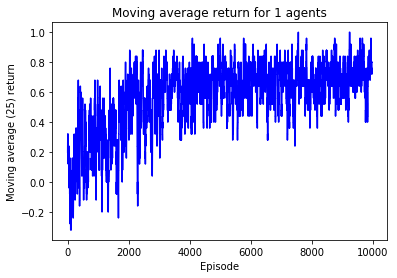

In [126]:
### Use this cell to produce the learning curve for Exercise 2b
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

class RandomAgent():
    
    def __init__(self):
        pass
    
    def choose_action(self, available_actions):
        return random.choice(available_actions)


class QLearningAgent():
    def __init__(self, alpha, gamma, epsilon):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = {}
        self.prev_state = None
        self.prev_q = 0.0
        self.prev_state_action = None
        
    def reset(self):
        self.prev_state = None
        self.prev_q = 0.0
        self.prev_state_action = None
    
    def choose_action(self, available_actions, state):
        self.prev_state = state
        
        if np.random.uniform(0, 1) < self.epsilon:
            action = random.choice(available_actions)
            self.prev_q = self.getQ(self.prev_state, action)
            self.prev_state_action = (self.prev_state, action)
            return action
        else:
            qs = [self.getQ(state, action) for action in available_actions]
            #if not qs:
            #print("qs:", qs)
            maxQ = max(qs)
            if qs.count(maxQ) > 1:
                best = [i for i in range(len(available_actions)) if qs[i] == maxQ]
                i = random.choice(best)
            else:
                i = qs.index(maxQ)
        
        action = available_actions[i]
        self.prev_q = self.getQ(self.prev_state, action)
        self.prev_state_action = (self.prev_state, action)
        
        return action
    
    def getQ(self, state, action):
        if(self.Q.get((state, action))) is None:
            self.Q[(state, action)] = 0.0
        return self.Q.get((state,action))
    
    def updateQ(self, state, new_state, reward, action, available_actions):
        qs = []
        for a in available_actions:
            qs.append(self.getQ(new_state, a))
        if qs:
            max_next_Q = max(qs)
        else:
            max_next_Q = 0.0
        self.Q[(state, action)] = ((1 - self.alpha) * self.Q.get((state, action), 0)) + (self.alpha * (reward + self.gamma * max_next_Q))



def play(q_agent, random_agent, n_episodes):
    for episode in range(n_episodes):

        reward = 0
        env = Tictactoe_Q()
        players = ["Q", "R"]
        random.shuffle(players)
        
        # If first player is the random agent, make a move
        if players[0] == "R":
            available_actions = env.get_available_actions()
            action = random_agent.choose_action(available_actions)
            env.make_move("R", action)
            
        while not env.is_done():

            state = np.copy(env.board)

            # Q-learning agent makes a move
            available_actions = env.get_available_actions()
            action = q_agent.choose_action(available_actions, tuple(state))
            env.make_move("Q", action)
            
            winner = env.check_win() # returns None, 0 = draw, 1 = player O won, 2 = player X won
            # If game is finished, random agent cannot make a move
            if winner != None:
                new_state = np.copy(env.board)
                reward = env.get_reward(winner)
                reward_array[episode] += reward

            else:
                # Random agent makes a move
                available_actions = env.get_available_actions()
                chosen_action = random_agent.choose_action(available_actions)
                env.make_move("R", chosen_action)
                new_state = np.copy(env.board)
            
                winner = env.check_win()
                if winner != None:
                    reward = env.get_reward(winner)
                    reward_array[episode] += reward

            
            #print("Action:", action)
            #print("Reward:", reward)
            available_actions = env.get_available_actions()
            print(state, new_state, reward, action, available_actions)
            q_agent.updateQ(tuple(state), tuple(new_state), reward, action, available_actions)
            #print("Q value:", q_agent.Q[(tuple(state), action)])
    
    Q_array.append(q_agent.Q)

    
alpha = 0.1
gamma = 1
epsilon = 0.1
#initial_Q = 0

n_episodes = 10000
n_agents = 1

reward_array = np.zeros(n_episodes)
Q_array = []

for i in range(n_agents):

    random_agent = RandomAgent()
    q_agent = QLearningAgent(alpha, gamma, epsilon)
    
    play(q_agent, random_agent, n_episodes)
    
    
#print(reward_array)            

#cum_reward_array = np.cumsum(reward_array)

#print(q_agent.Q)

average_returns = np.zeros(n_episodes)
for i in range(0, n_episodes):
    #print(reward_array[i], cum_reward_array[i])
    #average_returns[i] = (cum_reward_array[i] / n_agents) / (i + 1)
    average_returns[i] = (reward_array[i] / n_agents) #/ (i + 1)

# Moving average function is not mine and was taken from the following link:
# https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(a, n=25) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

moving_average_array = moving_average(reward_array) / n_agents

plt.plot(moving_average_array, color="blue", label="Average for 10 agents")
plt.title("Moving average return for "+ str(n_agents) + " agents")
plt.xlabel("Episode")
plt.ylabel("Moving average (25) return")
#plt.legend()
plt.show()

In 3 sentences or less, (1) explain the state representation you used, (2) discuss the learning curve you produced. 


### Exercise 2c: Optimal policy (20 marks)
What is the optimal play for the agent in the following state? You must answer by writing a function that takes a state as input and _prints_ the "after-state" that would result from playing an optimal action. The printed output can be primitive but the board has to be somewhat recognizable.   <img src="images/tic_tac_toe.png" style="width: 80px;"/> 

In [130]:
for a in [0,1,2]:
    for b in [0,1,2]:
        for c in [0,1,2]:
            for d in [0,1,2]:
                for e in [0,1,2]:
                    for f in [0,1,2]:
                        for g in [0,1,2]:
                            for h in [0,1,2]:
                                for i in [0,1,2]:
                                    print(np.array([a,b,c,d,e,f,g,h,i]))

[0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 2]
[0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 1 1]
[0 0 0 0 0 0 0 1 2]
[0 0 0 0 0 0 0 2 0]
[0 0 0 0 0 0 0 2 1]
[0 0 0 0 0 0 0 2 2]
[0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 1 0 1]
[0 0 0 0 0 0 1 0 2]
[0 0 0 0 0 0 1 1 0]
[0 0 0 0 0 0 1 1 1]
[0 0 0 0 0 0 1 1 2]
[0 0 0 0 0 0 1 2 0]
[0 0 0 0 0 0 1 2 1]
[0 0 0 0 0 0 1 2 2]
[0 0 0 0 0 0 2 0 0]
[0 0 0 0 0 0 2 0 1]
[0 0 0 0 0 0 2 0 2]
[0 0 0 0 0 0 2 1 0]
[0 0 0 0 0 0 2 1 1]
[0 0 0 0 0 0 2 1 2]
[0 0 0 0 0 0 2 2 0]
[0 0 0 0 0 0 2 2 1]
[0 0 0 0 0 0 2 2 2]
[0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 1 0 0 1]
[0 0 0 0 0 1 0 0 2]
[0 0 0 0 0 1 0 1 0]
[0 0 0 0 0 1 0 1 1]
[0 0 0 0 0 1 0 1 2]
[0 0 0 0 0 1 0 2 0]
[0 0 0 0 0 1 0 2 1]
[0 0 0 0 0 1 0 2 2]
[0 0 0 0 0 1 1 0 0]
[0 0 0 0 0 1 1 0 1]
[0 0 0 0 0 1 1 0 2]
[0 0 0 0 0 1 1 1 0]
[0 0 0 0 0 1 1 1 1]
[0 0 0 0 0 1 1 1 2]
[0 0 0 0 0 1 1 2 0]
[0 0 0 0 0 1 1 2 1]
[0 0 0 0 0 1 1 2 2]
[0 0 0 0 0 1 2 0 0]
[0 0 0 0 0 1 2 0 1]
[0 0 0 0 0 1 2 0 2]
[0 0 0 0 0 1 2 1 0]
[0 0 0 0 0 1 2 1 1]


[0 0 1 2 2 1 0 0 1]
[0 0 1 2 2 1 0 0 2]
[0 0 1 2 2 1 0 1 0]
[0 0 1 2 2 1 0 1 1]
[0 0 1 2 2 1 0 1 2]
[0 0 1 2 2 1 0 2 0]
[0 0 1 2 2 1 0 2 1]
[0 0 1 2 2 1 0 2 2]
[0 0 1 2 2 1 1 0 0]
[0 0 1 2 2 1 1 0 1]
[0 0 1 2 2 1 1 0 2]
[0 0 1 2 2 1 1 1 0]
[0 0 1 2 2 1 1 1 1]
[0 0 1 2 2 1 1 1 2]
[0 0 1 2 2 1 1 2 0]
[0 0 1 2 2 1 1 2 1]
[0 0 1 2 2 1 1 2 2]
[0 0 1 2 2 1 2 0 0]
[0 0 1 2 2 1 2 0 1]
[0 0 1 2 2 1 2 0 2]
[0 0 1 2 2 1 2 1 0]
[0 0 1 2 2 1 2 1 1]
[0 0 1 2 2 1 2 1 2]
[0 0 1 2 2 1 2 2 0]
[0 0 1 2 2 1 2 2 1]
[0 0 1 2 2 1 2 2 2]
[0 0 1 2 2 2 0 0 0]
[0 0 1 2 2 2 0 0 1]
[0 0 1 2 2 2 0 0 2]
[0 0 1 2 2 2 0 1 0]
[0 0 1 2 2 2 0 1 1]
[0 0 1 2 2 2 0 1 2]
[0 0 1 2 2 2 0 2 0]
[0 0 1 2 2 2 0 2 1]
[0 0 1 2 2 2 0 2 2]
[0 0 1 2 2 2 1 0 0]
[0 0 1 2 2 2 1 0 1]
[0 0 1 2 2 2 1 0 2]
[0 0 1 2 2 2 1 1 0]
[0 0 1 2 2 2 1 1 1]
[0 0 1 2 2 2 1 1 2]
[0 0 1 2 2 2 1 2 0]
[0 0 1 2 2 2 1 2 1]
[0 0 1 2 2 2 1 2 2]
[0 0 1 2 2 2 2 0 0]
[0 0 1 2 2 2 2 0 1]
[0 0 1 2 2 2 2 0 2]
[0 0 1 2 2 2 2 1 0]
[0 0 1 2 2 2 2 1 1]
[0 0 1 2 2 2 2 1 2]


[0 1 0 1 0 1 2 2 0]
[0 1 0 1 0 1 2 2 1]
[0 1 0 1 0 1 2 2 2]
[0 1 0 1 0 2 0 0 0]
[0 1 0 1 0 2 0 0 1]
[0 1 0 1 0 2 0 0 2]
[0 1 0 1 0 2 0 1 0]
[0 1 0 1 0 2 0 1 1]
[0 1 0 1 0 2 0 1 2]
[0 1 0 1 0 2 0 2 0]
[0 1 0 1 0 2 0 2 1]
[0 1 0 1 0 2 0 2 2]
[0 1 0 1 0 2 1 0 0]
[0 1 0 1 0 2 1 0 1]
[0 1 0 1 0 2 1 0 2]
[0 1 0 1 0 2 1 1 0]
[0 1 0 1 0 2 1 1 1]
[0 1 0 1 0 2 1 1 2]
[0 1 0 1 0 2 1 2 0]
[0 1 0 1 0 2 1 2 1]
[0 1 0 1 0 2 1 2 2]
[0 1 0 1 0 2 2 0 0]
[0 1 0 1 0 2 2 0 1]
[0 1 0 1 0 2 2 0 2]
[0 1 0 1 0 2 2 1 0]
[0 1 0 1 0 2 2 1 1]
[0 1 0 1 0 2 2 1 2]
[0 1 0 1 0 2 2 2 0]
[0 1 0 1 0 2 2 2 1]
[0 1 0 1 0 2 2 2 2]
[0 1 0 1 1 0 0 0 0]
[0 1 0 1 1 0 0 0 1]
[0 1 0 1 1 0 0 0 2]
[0 1 0 1 1 0 0 1 0]
[0 1 0 1 1 0 0 1 1]
[0 1 0 1 1 0 0 1 2]
[0 1 0 1 1 0 0 2 0]
[0 1 0 1 1 0 0 2 1]
[0 1 0 1 1 0 0 2 2]
[0 1 0 1 1 0 1 0 0]
[0 1 0 1 1 0 1 0 1]
[0 1 0 1 1 0 1 0 2]
[0 1 0 1 1 0 1 1 0]
[0 1 0 1 1 0 1 1 1]
[0 1 0 1 1 0 1 1 2]
[0 1 0 1 1 0 1 2 0]
[0 1 0 1 1 0 1 2 1]
[0 1 0 1 1 0 1 2 2]
[0 1 0 1 1 0 2 0 0]
[0 1 0 1 1 0 2 0 1]


[0 1 1 2 1 2 0 0 2]
[0 1 1 2 1 2 0 1 0]
[0 1 1 2 1 2 0 1 1]
[0 1 1 2 1 2 0 1 2]
[0 1 1 2 1 2 0 2 0]
[0 1 1 2 1 2 0 2 1]
[0 1 1 2 1 2 0 2 2]
[0 1 1 2 1 2 1 0 0]
[0 1 1 2 1 2 1 0 1]
[0 1 1 2 1 2 1 0 2]
[0 1 1 2 1 2 1 1 0]
[0 1 1 2 1 2 1 1 1]
[0 1 1 2 1 2 1 1 2]
[0 1 1 2 1 2 1 2 0]
[0 1 1 2 1 2 1 2 1]
[0 1 1 2 1 2 1 2 2]
[0 1 1 2 1 2 2 0 0]
[0 1 1 2 1 2 2 0 1]
[0 1 1 2 1 2 2 0 2]
[0 1 1 2 1 2 2 1 0]
[0 1 1 2 1 2 2 1 1]
[0 1 1 2 1 2 2 1 2]
[0 1 1 2 1 2 2 2 0]
[0 1 1 2 1 2 2 2 1]
[0 1 1 2 1 2 2 2 2]
[0 1 1 2 2 0 0 0 0]
[0 1 1 2 2 0 0 0 1]
[0 1 1 2 2 0 0 0 2]
[0 1 1 2 2 0 0 1 0]
[0 1 1 2 2 0 0 1 1]
[0 1 1 2 2 0 0 1 2]
[0 1 1 2 2 0 0 2 0]
[0 1 1 2 2 0 0 2 1]
[0 1 1 2 2 0 0 2 2]
[0 1 1 2 2 0 1 0 0]
[0 1 1 2 2 0 1 0 1]
[0 1 1 2 2 0 1 0 2]
[0 1 1 2 2 0 1 1 0]
[0 1 1 2 2 0 1 1 1]
[0 1 1 2 2 0 1 1 2]
[0 1 1 2 2 0 1 2 0]
[0 1 1 2 2 0 1 2 1]
[0 1 1 2 2 0 1 2 2]
[0 1 1 2 2 0 2 0 0]
[0 1 1 2 2 0 2 0 1]
[0 1 1 2 2 0 2 0 2]
[0 1 1 2 2 0 2 1 0]
[0 1 1 2 2 0 2 1 1]
[0 1 1 2 2 0 2 1 2]
[0 1 1 2 2 0 2 2 0]


[0 2 0 1 1 1 2 0 2]
[0 2 0 1 1 1 2 1 0]
[0 2 0 1 1 1 2 1 1]
[0 2 0 1 1 1 2 1 2]
[0 2 0 1 1 1 2 2 0]
[0 2 0 1 1 1 2 2 1]
[0 2 0 1 1 1 2 2 2]
[0 2 0 1 1 2 0 0 0]
[0 2 0 1 1 2 0 0 1]
[0 2 0 1 1 2 0 0 2]
[0 2 0 1 1 2 0 1 0]
[0 2 0 1 1 2 0 1 1]
[0 2 0 1 1 2 0 1 2]
[0 2 0 1 1 2 0 2 0]
[0 2 0 1 1 2 0 2 1]
[0 2 0 1 1 2 0 2 2]
[0 2 0 1 1 2 1 0 0]
[0 2 0 1 1 2 1 0 1]
[0 2 0 1 1 2 1 0 2]
[0 2 0 1 1 2 1 1 0]
[0 2 0 1 1 2 1 1 1]
[0 2 0 1 1 2 1 1 2]
[0 2 0 1 1 2 1 2 0]
[0 2 0 1 1 2 1 2 1]
[0 2 0 1 1 2 1 2 2]
[0 2 0 1 1 2 2 0 0]
[0 2 0 1 1 2 2 0 1]
[0 2 0 1 1 2 2 0 2]
[0 2 0 1 1 2 2 1 0]
[0 2 0 1 1 2 2 1 1]
[0 2 0 1 1 2 2 1 2]
[0 2 0 1 1 2 2 2 0]
[0 2 0 1 1 2 2 2 1]
[0 2 0 1 1 2 2 2 2]
[0 2 0 1 2 0 0 0 0]
[0 2 0 1 2 0 0 0 1]
[0 2 0 1 2 0 0 0 2]
[0 2 0 1 2 0 0 1 0]
[0 2 0 1 2 0 0 1 1]
[0 2 0 1 2 0 0 1 2]
[0 2 0 1 2 0 0 2 0]
[0 2 0 1 2 0 0 2 1]
[0 2 0 1 2 0 0 2 2]
[0 2 0 1 2 0 1 0 0]
[0 2 0 1 2 0 1 0 1]
[0 2 0 1 2 0 1 0 2]
[0 2 0 1 2 0 1 1 0]
[0 2 0 1 2 0 1 1 1]
[0 2 0 1 2 0 1 1 2]
[0 2 0 1 2 0 1 2 0]


[0 2 2 0 2 0 0 2 0]
[0 2 2 0 2 0 0 2 1]
[0 2 2 0 2 0 0 2 2]
[0 2 2 0 2 0 1 0 0]
[0 2 2 0 2 0 1 0 1]
[0 2 2 0 2 0 1 0 2]
[0 2 2 0 2 0 1 1 0]
[0 2 2 0 2 0 1 1 1]
[0 2 2 0 2 0 1 1 2]
[0 2 2 0 2 0 1 2 0]
[0 2 2 0 2 0 1 2 1]
[0 2 2 0 2 0 1 2 2]
[0 2 2 0 2 0 2 0 0]
[0 2 2 0 2 0 2 0 1]
[0 2 2 0 2 0 2 0 2]
[0 2 2 0 2 0 2 1 0]
[0 2 2 0 2 0 2 1 1]
[0 2 2 0 2 0 2 1 2]
[0 2 2 0 2 0 2 2 0]
[0 2 2 0 2 0 2 2 1]
[0 2 2 0 2 0 2 2 2]
[0 2 2 0 2 1 0 0 0]
[0 2 2 0 2 1 0 0 1]
[0 2 2 0 2 1 0 0 2]
[0 2 2 0 2 1 0 1 0]
[0 2 2 0 2 1 0 1 1]
[0 2 2 0 2 1 0 1 2]
[0 2 2 0 2 1 0 2 0]
[0 2 2 0 2 1 0 2 1]
[0 2 2 0 2 1 0 2 2]
[0 2 2 0 2 1 1 0 0]
[0 2 2 0 2 1 1 0 1]
[0 2 2 0 2 1 1 0 2]
[0 2 2 0 2 1 1 1 0]
[0 2 2 0 2 1 1 1 1]
[0 2 2 0 2 1 1 1 2]
[0 2 2 0 2 1 1 2 0]
[0 2 2 0 2 1 1 2 1]
[0 2 2 0 2 1 1 2 2]
[0 2 2 0 2 1 2 0 0]
[0 2 2 0 2 1 2 0 1]
[0 2 2 0 2 1 2 0 2]
[0 2 2 0 2 1 2 1 0]
[0 2 2 0 2 1 2 1 1]
[0 2 2 0 2 1 2 1 2]
[0 2 2 0 2 1 2 2 0]
[0 2 2 0 2 1 2 2 1]
[0 2 2 0 2 1 2 2 2]
[0 2 2 0 2 2 0 0 0]
[0 2 2 0 2 2 0 0 1]


KeyboardInterrupt: 

In [123]:
### You may use this code cell to answer Exercise 2c.

def optimal_policy(state):
    #count1 = 0
    #count2 = 0
    best_action = 9
    best_value = 0
    for Q_table in Q_array:
        print("test")
        for key, value in Q_table.items():
            #count1 += 1
            #print(key)
            if key[0] == tuple(state):
                if value > best_value:
                    best_action = key[1]
                #print("Found")
                print("Action:", key[1], "Value", value)
            #if value > 0:
            #    count2 += 1
    
    state[best_action] = 1
    print(np.reshape(state, (3,3)))
    
    #print(count1)
    #print(count2)

state = np.array([1, 2, 0, 0, 2, 0, 0, 1, 0])
#b = np.reshape(state, (3,3))
#print(b)

optimal_policy(state)

test
Action: 2 Value 0.0
Action: 3 Value 0.0
Action: 5 Value 0.0
Action: 6 Value 0.010000000000000002
Action: 8 Value 0.0
test
test
Action: 2 Value 0.0
Action: 3 Value 0.0
Action: 5 Value 0.0
Action: 6 Value 0.0
Action: 8 Value 0.0
test
Action: 2 Value 0.0
Action: 3 Value 0.0
Action: 5 Value 0.0
Action: 6 Value 0.0
Action: 8 Value 0.0
test
Action: 2 Value 0.0
Action: 3 Value 0.0
Action: 5 Value 0.0
Action: 6 Value 0.0
Action: 8 Value 0.0
test
Action: 2 Value 0.0
Action: 3 Value 0.0
Action: 5 Value 0.0
Action: 6 Value 0.0
Action: 8 Value 0.0
test
test
Action: 2 Value 0.0
Action: 3 Value 0.0
Action: 5 Value 0.0
Action: 6 Value 0.0
Action: 8 Value 0.0
test
test
Action: 2 Value 0.0
Action: 3 Value 0.0
Action: 5 Value 0.0
Action: 6 Value 0.0
Action: 8 Value 0.0
[[1 2 0]
 [0 2 0]
 [1 1 0]]


Please ignore this cell. We will use this cell to mark your answer. 


### Exercise 2d: Sarsa (40 marks)
Implement Sarsa to learn how to play Tic-tac-toe against a random player. Produce a learning curve. Also include the learning curve of your previously trained Q-learning agent in the same plot. Discuss the learning curves. For your reference, the pseudo-code for SARSA is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 6.4).
<img src="images/SARSA.png" style="width: 600px;"/>



In [ ]:
### Use this cell to produce the plot for Exercise 2d

import itertools
import matplotlib.pyplot as plt
%matplotlib inline

class RandomAgent():
    
    def __init__(self):
        pass
    
    def choose_action(self, available_actions):
        return random.choice(available_actions)


class SarsaAgent():
    def __init__(self, alpha, gamma, epsilon):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = {}
        self.prev_state = None
        self.prev_q = 0.0
        self.prev_state_action = None
        
    def reset(self):
        self.prev_state = None
        self.prev_q = 0.0
        self.prev_state_action = None
    
    def choose_action(self, available_actions, state):
        self.prev_state = state
        
        if np.random.uniform(0, 1) < self.epsilon:
            action = random.choice(available_actions)
            self.prev_q = self.getQ(self.prev_state, action)
            self.prev_state_action = (self.prev_state, action)
            return action
        else:
            qs = [self.getQ(state, action) for action in available_actions]
            #print("qs:", qs)
            maxQ = max(qs)
            if qs.count(maxQ) > 1:
                best = [i for i in range(len(available_actions)) if qs[i] == maxQ]
                i = random.choice(best)
            else:
                i = qs.index(maxQ)
        
        action = available_actions[i]
        self.prev_q = self.getQ(self.prev_state, action)
        self.prev_state_action = (self.prev_state, action)
        
        return action
    
    def getQ(self, state, action):
        if(self.Q.get((state, action))) is None:
            self.Q[(state, action)] = 0.0
        return self.Q.get((state,action))
    
    def updateQ(self, state, reward, available_actions):
        qs = []
        for action in available_actions:
            qs.append(self.getQ(tuple(state), action))
        if qs:
            max_next_Q = max(qs)
        else:
            max_next_Q = 0.0
        self.Q[self.prev_state_action] = ((1 - self.alpha) * self.prev_q) + (self.alpha * (reward + self.gamma * max_next_Q))

alpha = 0.1
gamma = 1
epsilon = 0.05
initial_Q = 0

n_episodes = 5000

reward_array = np.zeros(n_episodes)
Q_array = []

for i in range(10):

    random_agent = RandomAgent()
    sarsa_agent = SarsaAgent(alpha, gamma, epsilon)

    for episode in range(n_episodes):
        #print("\nEpisode\n")
        reward = 0
        env = Tictactoe_Q()
        players = ["Q", "R"]
        random.shuffle(players)
        i = 0
        while not env.is_done():
            player = players[i % 2]
            #print(player, "'s turn")
            state = env.board
            #env.print_board()
            available_actions = env.get_available_actions()

            if player == "Q":
                chosen_action = q_agent.choose_action(available_actions, tuple(state))
            else:
                chosen_action = random_agent.choose_action(available_actions)

            env.make_move(player, chosen_action)
            winner = env.check_win()
            if winner != None:
                #print("Winner:", winner)
                if winner == 0:
                    reward = 0
                    reward_array[episode] += 0
                elif winner == 1:
                    reward = 1
                    reward_array[episode] += 1
                elif winner == 2:
                    reward = -1
                    reward_array[episode] += -1
        
                q_agent.updateQ(tuple(state), reward, available_actions)
                
            i += 1
    
    Q_array.append(q_agent.Q)

#print(reward_array)            

cum_reward_array = np.cumsum(reward_array)

#print(q_agent.Q)

average_returns = np.zeros(n_episodes)
for i in range(0, n_episodes):
    average_returns[i] = (cum_reward_array[i] / 10) / (i + 1)

plt.plot(average_returns, color="blue", label="Average")
plt.xlabel("Episode")
plt.ylabel("Average return")
plt.legend()
plt.show()

Discuss the learning curves here in 10 sentences or less.
